# Set up

In [1]:
!pip install git+https://github.com/ficusss/PyGMNormalize.git
!pip install -U scikit-fuzzy

  Cloning https://github.com/ficusss/PyGMNormalize.git to /tmp/pip-req-build-127cbpbt
  Running command git clone -q https://github.com/ficusss/PyGMNormalize.git /tmp/pip-req-build-127cbpbt
  Created wheel for pygmnormalize: filename=pygmnormalize-0.2-cp36-none-any.whl size=4669 sha256=89595f2980842a4a77478502dfedc4c7946111060ecfaf598b9fbe93b3cae9a9
  Stored in directory: /tmp/pip-ephem-wheel-cache-5eqdpueb/wheels/22/f9/56/db07076bd0b3b986414f211fac814066ed164011fbf3596e2e
Successfully built pygmnormalize
Requirement already up-to-date: scikit-fuzzy in /usr/local/lib/python3.6/dist-packages (0.4.2)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA, SparsePCA
from sklearn.cluster import KMeans
import seaborn as sb
from skfuzzy.cluster import cmeans, cmeans_predict

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
## Upload files to colab first
test_data = pd.read_csv('test_data_processed.csv')
train_data = pd.read_csv('train_data_processed.csv')
test_lbl = pd.DataFrame(np.load('test_labels.csv.npy', allow_pickle = True))
train_lbl = pd.DataFrame(np.load('train_labels.csv.npy', allow_pickle = True))

In [0]:
train_data_lbl = pd.concat([train_data, train_lbl], axis = 1)
test_data_lbl = pd.concat([test_data, test_lbl], axis = 1)

train_data_lbl.columns.values[-1] = 'Grade'
test_data_lbl.columns.values[-1] = 'Grade'

In [0]:
def get_accuracy(true_labels, predicted_labels):
    accuracy = 0
    for i in range(len(true_labels)):
        if true_labels[i] == predicted_labels[i]:
            accuracy += 1
    return accuracy/len(true_labels)

# Factor Analysis

## Implement

In [0]:
from sklearn.decomposition import FactorAnalysis

In [0]:
factors = FactorAnalysis(n_components = 100, copy = True, random_state = 15)
fa_train_genes = factors.fit_transform(train_data)
fa_test_genes = factors.transform(test_data)

In [8]:
fa_train = pd.concat([pd.DataFrame(fa_train_genes), pd.DataFrame(train_lbl)], axis = 1)

col_titles = [f'Factor {x}' for x in range(1, 102)]
col_titles[-1] = 'Grade'
fa_train.columns = col_titles

fa_train.head()

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9,Factor 10,Factor 11,Factor 12,Factor 13,Factor 14,Factor 15,Factor 16,Factor 17,Factor 18,Factor 19,Factor 20,Factor 21,Factor 22,Factor 23,Factor 24,Factor 25,Factor 26,Factor 27,Factor 28,Factor 29,Factor 30,Factor 31,Factor 32,Factor 33,Factor 34,Factor 35,Factor 36,Factor 37,Factor 38,Factor 39,Factor 40,...,Factor 62,Factor 63,Factor 64,Factor 65,Factor 66,Factor 67,Factor 68,Factor 69,Factor 70,Factor 71,Factor 72,Factor 73,Factor 74,Factor 75,Factor 76,Factor 77,Factor 78,Factor 79,Factor 80,Factor 81,Factor 82,Factor 83,Factor 84,Factor 85,Factor 86,Factor 87,Factor 88,Factor 89,Factor 90,Factor 91,Factor 92,Factor 93,Factor 94,Factor 95,Factor 96,Factor 97,Factor 98,Factor 99,Factor 100,Grade
0,-0.767871,-0.385531,0.115836,2.388345,-0.383484,-0.467369,0.561467,-2.350664,0.418821,3.973832,1.393458,0.537795,-1.186955,0.241165,-2.461988,-0.384562,-0.998326,0.576849,1.282513,0.930144,-1.114290,-0.555400,0.582111,-1.286940,-0.756003,-0.851512,0.500168,-0.302530,-1.151444,1.133120,0.066960,-0.897220,0.713943,0.469944,0.523972,0.829169,-0.259754,0.334612,0.638612,0.837120,...,1.005647,0.667772,-0.687835,-1.093906,0.663421,1.777082,0.403360,1.039033,0.014080,0.939824,-0.798166,-0.012489,-1.292066,-1.089388,0.435321,1.080004,-0.580681,0.193973,-0.696573,0.209947,1.181998,1.581319,0.001383,-0.257150,0.536074,0.311319,0.998915,-0.095354,2.095175,0.483481,0.344128,1.088099,-1.533397,0.904053,-0.544323,-2.056798,1.683718,-0.716638,-0.717733,WHO II
1,0.539117,0.327107,0.852022,-0.332517,-0.004732,0.745542,0.420696,0.905649,-0.866477,1.996034,0.113299,-0.303487,-0.368289,-0.738100,-0.355224,-0.306828,1.579579,-0.624290,-0.943939,-0.140500,-0.371726,1.095854,-0.376742,-0.131920,1.156971,0.019174,0.526034,1.989616,1.022750,0.108739,-0.671821,-0.700076,0.210346,0.400768,-0.186391,-1.013761,1.210125,0.822048,-0.608654,0.412536,...,0.826723,-1.716859,0.398347,0.363219,0.184676,-0.871169,2.087683,-2.375473,4.507718,0.359282,0.120722,-1.184790,-1.131110,0.596269,-1.417280,3.027256,-1.059554,-1.926482,-1.727431,0.575586,-1.020027,-0.035904,-0.445189,0.958550,1.122069,-1.147704,1.916830,0.175825,-1.755637,-0.108784,0.047249,-2.818945,2.346825,-2.154707,-0.128855,-1.230194,0.923162,-1.032598,0.883319,WHO IV
2,-0.914146,-0.218124,-0.782675,1.019773,0.375657,0.519532,0.913710,-1.079186,-0.907992,1.785236,0.315228,0.503691,-0.523415,0.600933,-0.377421,1.659806,0.111216,-0.507630,0.373521,1.309040,2.158432,-0.649656,2.112633,-0.537144,-0.300375,0.304272,-1.232271,-0.303918,-0.466015,-0.998909,0.478124,0.124541,-0.578029,-0.843605,0.154575,0.143870,-0.867417,-0.063425,0.102344,-0.828719,...,0.717151,-0.342601,-1.091383,0.584348,0.084750,-0.297700,0.573446,-0.372649,0.069827,-0.060793,0.694590,1.544628,1.004739,1.563913,-0.019049,0.554957,0.060621,-0.619902,0.381322,0.727567,-0.004370,-0.079075,1.533853,-0.318394,0.100634,-0.178083,-0.220553,0.727758,-1.449127,0.138948,0.788301,0.348312,0.520673,1.320611,-0.702829,-0.331891,-0.452675,-0.783852,-0.367775,WHO II
3,-0.010240,-0.408593,-1.194213,-0.386557,0.003723,-1.695766,-0.276458,0.752302,1.858447,-0.038924,-0.494421,-0.505349,-1.804313,-0.779621,-1.425660,0.286663,0.260123,1.654794,-0.879751,-0.318515,0.663504,-0.573909,-0.654317,0.076841,-1.708391,-1.136160,-0.360114,0.521692,0.938267,-0.223938,-0.616241,-0.095428,-0.039779,1.251148,-0.454566,0.253899,-1.674527,0.542885,-0.161628,-0.132685,...,0.616032,0.414760,-1.054944,-0.810270,0.392132,0.229581,-0.028218,1.044777,0.852055,-0.145478,0.086758,-0.776033,0.473123,0.725105,0.000560,0.576832,-0.573361,-0.678358,1.069336,-0.443874,1.552338,-0.308504,-0.923042,-1.355427,0.088791,0.648256,-0.374091,-0.184248,-0.618326,-0.348110,1.108395,-0.278188,-0.167396,-0.417089,-0.212686,0.996606,0.270324,0.030926,0.107322,WHO II
4,-0.785148,-0.501948,-1.059175,-0.116568,-0.353897,1.322514,1.409249,-0.578670,0.985555,-0.809191,0.794120,0.010905,0.750028,0.052386,0.721943,0.340907,-1

In [9]:
fa_test = pd.concat([pd.DataFrame(fa_test_genes), pd.DataFrame(test_lbl)], axis = 1)

col_titles = [f'Factor {x}' for x in range(1, 102)]
col_titles[-1] = 'Grade'
fa_test.columns = col_titles

fa_test.head()

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9,Factor 10,Factor 11,Factor 12,Factor 13,Factor 14,Factor 15,Factor 16,Factor 17,Factor 18,Factor 19,Factor 20,Factor 21,Factor 22,Factor 23,Factor 24,Factor 25,Factor 26,Factor 27,Factor 28,Factor 29,Factor 30,Factor 31,Factor 32,Factor 33,Factor 34,Factor 35,Factor 36,Factor 37,Factor 38,Factor 39,Factor 40,...,Factor 62,Factor 63,Factor 64,Factor 65,Factor 66,Factor 67,Factor 68,Factor 69,Factor 70,Factor 71,Factor 72,Factor 73,Factor 74,Factor 75,Factor 76,Factor 77,Factor 78,Factor 79,Factor 80,Factor 81,Factor 82,Factor 83,Factor 84,Factor 85,Factor 86,Factor 87,Factor 88,Factor 89,Factor 90,Factor 91,Factor 92,Factor 93,Factor 94,Factor 95,Factor 96,Factor 97,Factor 98,Factor 99,Factor 100,Grade
0,-0.293440,2.538886,-0.681511,0.568800,-0.486379,-0.779511,0.319821,1.345924,-0.322250,-1.543843,0.583401,1.232805,1.015854,0.371118,0.726277,-1.793935,0.595507,1.381473,0.146248,-0.627867,1.816056,-1.514732,1.279376,-0.541915,-0.503033,0.677510,-2.602009,0.990409,-1.203804,-1.624827,1.442395,0.003285,-0.806711,-2.130532,-0.922185,1.211113,0.675092,0.930663,-0.030370,0.327993,...,-0.665342,0.181058,1.941298,-2.222015,-0.918663,-1.127551,0.955807,-0.755799,0.019922,3.750914,-0.136771,2.480472,1.341996,1.514001,-1.479348,-2.774186,2.167005,1.845020,-0.688455,-1.843069,-0.394638,2.116943,-0.407150,0.818184,-0.816016,0.064942,0.986092,0.205071,1.520231,-0.337685,-1.020581,-0.319427,-2.768241,0.609570,0.387526,-0.541136,0.203349,0.843216,-0.207020,WHO IV
1,0.324620,0.320905,-0.001379,3.038895,1.789471,0.165920,-2.021166,-1.015364,0.394811,-2.838859,-0.892280,-2.068333,0.330254,0.075194,-0.361176,0.709951,1.915603,-1.290557,-0.529883,1.427255,-0.678221,0.282330,0.281810,0.989438,0.133487,-0.813798,0.024551,1.098699,1.331911,-0.247413,1.089651,1.520390,2.552489,0.659972,0.443962,-1.244502,-0.129881,-0.534517,-0.642364,-0.998721,...,1.131960,-1.190419,0.839269,-0.432565,-0.610082,0.100808,-0.780341,-1.514881,0.213097,0.493203,-1.221235,0.915697,0.513288,0.614149,-0.283112,0.548249,-0.632030,1.084227,0.111545,1.039633,-0.012621,0.441137,0.886790,-0.718504,-1.305706,0.202242,-0.760016,1.094748,-0.414678,0.618624,-0.250067,-0.622165,-0.176920,1.646883,-1.226587,0.509953,0.791242,-0.390949,-0.668325,WHO IV
2,-1.149085,-0.725466,-0.161190,0.100292,-0.135751,0.447639,1.397324,0.732199,0.198626,-0.174552,0.252575,0.098434,-0.201954,1.109297,-0.362313,0.611463,0.252529,-0.328643,0.187580,-0.351575,1.453071,-0.282818,0.086284,-0.131108,-0.075098,0.546457,-0.347318,0.404466,0.175415,-0.935541,0.697452,0.543868,-1.326968,-0.798311,0.110845,-1.492511,-0.294801,0.442117,-0.170704,-1.192030,...,0.263661,-0.183156,-0.440594,0.938233,-0.046092,-0.661072,0.329273,-0.586578,0.515794,-0.039014,0.324517,0.114069,-0.110840,0.209480,-0.006129,-0.641516,0.481802,0.213864,0.377849,0.004588,-0.405983,-0.021938,1.210337,0.795871,-0.848095,0.590221,0.391976,-0.268752,-0.157662,-0.176234,0.056113,-0.188803,-0.267155,0.447616,-0.704491,0.614786,0.263612,0.665294,-0.383083,WHO II
3,-1.171114,0.380817,-0.509393,-0.778159,0.568190,0.228791,0.408663,-1.304155,0.910656,-0.400083,0.108526,-0.780755,-0.610037,-0.624102,-1.455385,0.215294,-1.350310,-0.298107,-0.909006,0.128485,-0.005939,-1.041672,0.504513,0.006271,0.233487,0.173494,-0.586015,0.290266,-0.825464,0.271224,0.395707,-0.256013,0.119838,-0.852398,0.395025,-0.068228,-0.552795,-0.170839,0.146349,-0.367205,...,0.193013,0.171287,-0.204903,0.103397,-0.068474,0.006126,-0.111813,0.439918,0.409053,0.541837,-0.766683,-0.208610,0.150967,0.201722,0.477650,0.570681,-0.450848,-0.179122,-0.210300,-0.046033,-0.044556,-0.177725,-0.080124,-0.229516,0.140195,0.034021,0.122877,0.360044,0.347633,0.132775,0.123528,0.107490,0.339592,-0.311282,0.034030,-0.348044,0.098321,-0.154382,-0.752504,WHO II
4,-0.999554,0.257892,-0.399793,-0.399037,0.653508,-0.356721,0.683092,-0.835377,2.041559,-0.493432,0.701805,-0.706554,-1.159834,-0.390775,-0.939134,0.467496,-0.0

## Plot factors

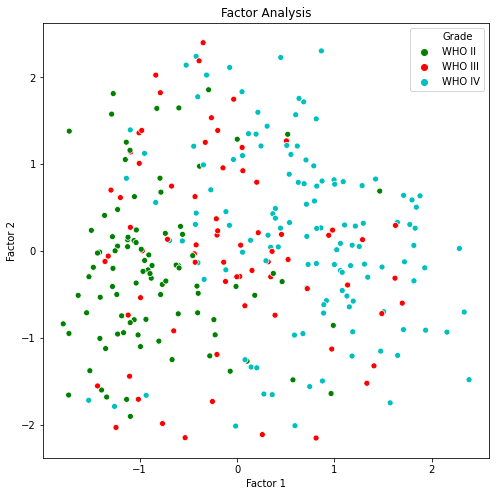

In [10]:
x = fa_train['Factor 1']
y = fa_train['Factor 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = fa_train['Grade'], palette = ['g', 'r', 'c'], hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("Factor Analysis")
plt.show()

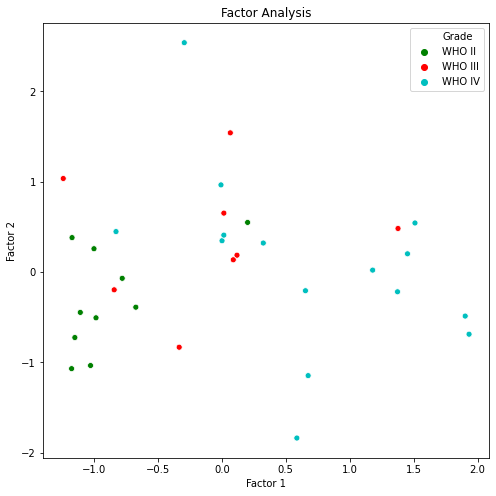

In [11]:
x = fa_test['Factor 1']
y = fa_test['Factor 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = fa_test['Grade'], palette = ['g', 'r', 'c'], hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("Factor Analysis")
plt.show()

## Identify important genes

In [12]:
### Find the 100 top features for top PCs
all_weights = pd.DataFrame(factors.components_)
col_names = train_data.columns.values
all_weights.columns = col_names
all_weights.head()

,0,2,4,7,15,28,31,32,33,38,39,42,43,44,45,47,50,55,56,61,62,64,65,66,67,68,69,70,78,79,82,86,88,89,96,98,102,103,106,107,...,24150,24155,24156,24160,24163,24164,24165,24168,24184,24191,24202,24203,24207,24214,24215,24220,24223,24224,24237,24244,24253,24255,24256,24260,24261,24271,24272,24273,24277,24283,24285,24288,24291,24296,24308,24309,24313,24316,24317,24323
0,0.394535,0.686760,-0.793877,0.360274,-0.120240,-1.073860,-0.928904,0.008527,0.309969,-0.463421,-0.404720,0.305538,0.390072,0.312580,0.123763,-0.309546,0.699998,0.091294,0.478405,2.151520,-0.041044,0.141447,0.045779,-0.053478,-1.502464,-0.110747,0.507746,-0.282826,-0.516769,-0.514027,-0.285012,-0.399564,-0.483148,-0.493682,-0.459505,-0.061641,-0.559857,-0.186352,0.711557,-0.117918,...,-0.318457,-0.112810,-0.131265,-0.343320,-0.442717,-0.208567,-0.479205,0.117654,-0.324475,-0.334541,0.145330,-0.287848,-0.814989,0.248605,0.209345,0.042402,-0.371714,-0.315404,-0.488269,-0.083497,-0.181307,-0.226476,0.295612,0.010933,-0.813638,0.410216,-0.198011,-0.288114,0.543581,-0.150288,-0.628002,0.062737,-0.174492,-0.538345,0.232680,-0.482441,0.144702,0.342350,0.463540,0.824403
1,-0.365092,-0.308476,-0.506988,-0.464917,-0.324035,-0.850296,-0.035858,0.062682,-0.059075,-0.308486,-0.677046,-0.722874,-0.567031,-0.443744,-0.549277,-0.401505,0.088854,-0.310717,0.089248,-0.279759,-0.006797,-0.376615,-0.055678,-0.093861,-0.305259,-0.378854,-0.081368,-0.339470,-0.209851,-0.542684,-0.473866,-1.059023,-0.285787,0.026818,-0.189734,0.066158,-0.199383,-0.564098,-0.466285,-0.231032,...,0.378543,0.689172,0.459955,0.731361,0.296188,0.423435,0.397988,-0.044376,-0.045264,0.095649,0.037665,0.061768,0.237743,-0.423039,0.199891,-0.092132,-0.164534,0.362356,0.026411,0.393754,0.166431,0.387866,0.501716,0.612015,0.127472,-0.286495,0.055565,0.118039,-0.523248,-0.076079,-0.046152,-0.234878,-0.205588,0.400540,0.367268,0.119743,-0.083416,0.311430,0.779608,0.064631
2,0.053511,-0.214387,-0.497603,0.144263,0.471806,-0.298401,-0.170068,0.070859,-0.415713,-0.225586,-0.109313,0.573530,-0.137415,0.057423,-0.216757,-0.057985,-0.042092,0.413433,-0.027255,0.416236,-0.378010,-0.275605,-0.060572,-0.255059,-0.077373,-0.128937,-0.135708,0.425625,-0.222800,0.854402,-0.031826,0.235360,0.063446,-0.035069,-0.103102,0.085296,-0.293820,0.346790,-0.416195,-0.867555,...,-0.072683,0.095240,0.021864,-0.053968,-0.094921,-0.103319,-0.070674,0.143013,-0.060735,-0.039310,-0.020146,0.039400,-0.072841,-0.549922,-0.164976,-0.078914,-0.269970,-0.110258,-0.176039,-0.000604,-0.070783,-0.012414,0.003029,-0.122696,0.405555,-0.156949,-0.095267,-0.096055,0.217537,-0.095917,-0.195742,-0.084611,0.062812,-0.254547,0.058194,-0.213946,0.005693,0.253435,0.245738,0.210490
3,0.375425,-0.201619,0.229096,0.030218,0.053694,0.157241,0.078677,0.432345,-0.180992,0.334877,0.279586,-0.049308,-0.228047,0.370557,-0.238934,0.221651,0.313943,0.021352,0.128731,0.268483,-0.108241,0.369930,0.402155,0.431709,0.593654,-0.236625,0.180729,-0.309003,-0.055278,-0.022848,0.397324,-0.111221,0.322530,0.017234,-0.155658,-0.430064,0.023653,0.159534,0.131136,-0.295012,...,-0.074272,-0.350022,0.319413,0.107344,-0.114033,0.251350,0.182713,0.154355,-0.113162,0.260760,-0.090089,0.001279,-0.106950,-0.034895,-0.113645,-0.137721,-0.010671,0.024138,-0.033835,-0.158404,0.160279,-0.101910,0.394061,-0.003358,0.206732,-0.123152,-0.133733,-0.259931,0.207891,0.211978,0.675565,0.005485,0.207299,-0.349961,0.158213,-0.030908,0.534420,0.086908,0.147582,0.113144
4,-0.194167,-0.216237,0.942580,-0.175547,-0.039104,-0.789547,0.391960,0.069670,0.148736,0.138910,-0.430728,0.104015,-0.094954,0.194195,-0.095556,0.103591,-0.100789,0.019701,-0.084990,0.291680,-0.004978,0.237814,0.406409,0.423284,0.031007,0.275728,0.026385,0.477183,0.130073,0.120325,0.360704,-0.563221,0.081320,0.128988,-0.307715,0.084985,-0.223643,0.251542,-0.219176,-0.048057,...,-0.107376,-0.234130,-0.220133,-0.385818,-0.134099,-0.269876,-0.213664,-0.108191,0.196692,-0.230299,-0.043239,-0.016933,-0.401253,-0.137849,-0.027067,-0.009740,-0.367276

In [0]:
fa_important_genes = []
temp = pd.DataFrame(np.abs(all_weights)).T
for i in range(50):
    fa_important_genes.extend(temp.nlargest(100, i).index.values)
fa_important_genes = np.unique(fa_important_genes)

In [14]:
# Make new training and testing sets with these genes
fa_important_train = train_data[fa_important_genes]
fa_important_test = test_data[fa_important_genes]
fa_important_train.head()

,10006,10013,10042,10057,10070,10101,10108,10124,10127,10129,1013,10130,10136,1016,10176,10190,10191,10197,10200,10231,10257,10282,10286,10291,10293,10314,10329,10336,10340,10344,10386,10396,10405,10410,10414,10422,10426,10457,10463,10465,...,9644,9667,9687,9689,9744,9745,9746,9754,977,9817,9821,9822,9834,9837,9841,9843,9846,9853,9854,9855,9856,9863,9867,9870,9871,9876,9877,9882,9888,9891,9895,9897,9901,9903,9906,9930,9948,9955,9963,9976
0,1.774303,0.792760,2.385850,1.204737,0.875901,1.158044,0.638037,4.442473,3.391916,2.034238,2.134118,0.943540,3.379758,5.602296,0.336381,3.197829,0.852631,8.562009,-0.767955,-0.159146,2.049668,-2.182993,0.080042,-0.045489,4.166325,4.788934,1.810983,2.134118,1.711016,4.398961,1.417911,0.986932,0.898801,-3.767955,1.417911,-0.389444,-0.630452,-0.045489,3.564753,3.681606,...,1.186241,-0.231902,1.080042,-0.697566,1.353060,0.997579,5.048388,6.448791,2.586074,2.008149,0.954511,1.915741,2.460863,-0.089883,5.576784,1.786634,0.954511,0.213897,1.417911,5.611856,6.871566,0.624362,5.026461,0.943540,2.904470,3.519295,1.638037,2.298134,1.561168,2.029058,5.612722,0.099941,7.131855,0.039400,-0.256993,3.918545,-1.630452,-1.135687,4.937331,3.393932
1,1.484901,0.756814,1.266067,-0.525825,-1.733933,3.334382,0.302903,4.252791,2.308952,1.000543,2.734515,0.557833,4.449745,1.958832,3.231453,0.474175,-1.269986,1.597910,-3.132483,-1.733933,-2.891475,-0.269986,-3.006952,-0.234362,4.468782,2.062722,-0.288134,1.895926,3.681881,3.736761,-1.784559,-0.614634,-1.784559,-3.269986,-2.132483,-0.116181,1.838538,0.000000,4.176270,2.547637,...,0.474175,-1.006952,-0.132483,-1.948058,0.408086,0.350600,2.037442,6.545557,0.808965,-0.288134,-2.006952,2.218657,1.842714,0.597910,5.977704,1.506118,-1.948058,-1.100061,0.266067,5.535758,3.071644,-2.199597,2.208986,-0.504452,1.542512,2.698104,0.867517,1.030137,0.899939,0.547637,2.438753,-0.288134,5.451455,0.385366,0.302903,1.587995,-0.022059,3.918850,2.471481,2.929686
2,1.722956,0.753983,1.985119,0.300932,0.647855,1.490949,0.023823,6.180962,5.353369,3.184287,-0.319479,-2.298105,5.635065,4.254677,0.545169,4.752704,-0.800606,5.623561,-0.028016,-1.578213,-0.657648,-0.063640,0.408848,-1.800606,4.145813,4.138974,2.965371,1.913640,1.814104,4.443362,-2.926137,2.161326,2.614432,0.421787,-2.926137,-1.256285,-2.926137,-1.298105,1.647855,4.243788,...,0.459922,0.355899,1.006749,0.214345,-0.478678,0.899834,4.569355,6.269515,1.774303,0.199394,1.369319,1.428213,3.325238,0.199394,3.982938,-1.298105,-1.800606,-0.277044,2.487876,6.191389,6.202678,-1.862006,4.590280,0.871820,1.799307,2.503175,1.362625,1.895203,-0.341174,0.794341,4.525824,-1.741712,5.663259,-1.100166,-0.478678,1.032284,0.591712,3.349141,3.699240,1.769250
3,0.496771,1.487249,1.081734,0.666696,1.784119,2.134540,0.552625,5.439286,3.478864,3.040007,1.870896,1.597572,4.477663,3.113030,1.062625,3.322985,0.203040,6.859292,0.969943,-0.685067,1.113030,-1.465754,-0.078731,0.833806,2.732660,2.140628,1.372965,0.131487,1.649723,1.615166,2.579761,3.942331,1.173656,0.803433,0.615166,0.030204,-1.465754,1.524968,1.167707,2.628222,...,0.935344,-0.918266,0.623883,0.003731,1.732660,1.423770,3.280890,6.562436,1.700055,-0.151243,1.069023,2.052975,5.032661,-0.918266,1.463163,-0.393604,1.795738,-0.181301,2.119209,5.432789,3.584234,0.069023,4.615712,1.472846,1.803433,2.125361,1.487249,3.244611,1.243197,0.780225,2.791876,1.293238,4.961371,0.398591,-0.728788,0.534246,-0.685067,4.143662,2.545760,1.287763
4,-0.342156,2.211946,-0.071508,-0.109982,1.196264,1.046887,-1.412545,4.553239,4.379269,3.746654,0.474980,0.448749,4.557849,3.387924,2.569308,7.113367,-3.512081,4.984345,-0.090617,-0.190152,0.000000,-0.512081,0.513455,-1.860004,3.957852,2.374052,1.628932,1.374052,2.590458,3.834117,-1.071508,3.684785,4.385333,-0.795873,-1.734473,-0.149510,-2.319435,-2.618996,2.276754,5.856738,...,-0.512081,0.563208,0.550929,1.081444,-0.436792,2.200201,3.939131,6.253265,3.186376,-1.675579,-1.149510,1.860474,2.799506,-0.342156,2.954360,-3.997507,0.928492,0.295274,3.372308,4.649951,7.126743,-0.2

# PCA

## Implement

In [0]:
scaler = StandardScaler()
train_genes_scaled = scaler.fit_transform(train_data)
test_genes_scaled = scaler.transform(test_data)

In [0]:
pca = PCA(100)
pca_train_genes = pca.fit_transform(train_genes_scaled)
pca_test_genes = pca.transform(test_genes_scaled)

In [17]:
pca_test = pd.concat([pd.DataFrame(pca_test_genes), pd.DataFrame(test_lbl)], axis = 1)

col_titles = [f'PC {x}' for x in range(1, 102)]
col_titles[-1] = 'Grade'
pca_test.columns = col_titles

pca_test.head()

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,PC 11,PC 12,PC 13,PC 14,PC 15,PC 16,PC 17,PC 18,PC 19,PC 20,PC 21,PC 22,PC 23,PC 24,PC 25,PC 26,PC 27,PC 28,PC 29,PC 30,PC 31,PC 32,PC 33,PC 34,PC 35,PC 36,PC 37,PC 38,PC 39,PC 40,...,PC 62,PC 63,PC 64,PC 65,PC 66,PC 67,PC 68,PC 69,PC 70,PC 71,PC 72,PC 73,PC 74,PC 75,PC 76,PC 77,PC 78,PC 79,PC 80,PC 81,PC 82,PC 83,PC 84,PC 85,PC 86,PC 87,PC 88,PC 89,PC 90,PC 91,PC 92,PC 93,PC 94,PC 95,PC 96,PC 97,PC 98,PC 99,PC 100,Grade
0,-17.018512,-76.678514,15.561575,3.062705,-7.722775,-8.775855,-4.664845,23.154769,0.509306,7.973493,-3.623431,5.865838,-4.550082,12.146977,-1.392681,-18.247655,6.898328,0.944234,11.385726,6.992770,12.331238,11.713086,0.710077,2.287172,-13.372765,6.968041,-10.298332,8.281167,-2.427184,-1.382116,-4.428495,1.189871,9.345460,11.165574,8.224162,0.316288,-5.162597,6.389885,9.948396,-1.074746,...,11.614931,-3.197128,-0.143310,-1.270086,7.528369,2.055503,-5.333428,6.268508,0.078297,-3.276162,-0.453180,1.323430,-9.156285,8.630677,5.765287,6.622815,3.409527,-9.926912,-6.116751,5.465556,-0.973197,-3.731823,6.626961,-4.109379,-0.879745,0.127893,-3.803998,3.614193,0.048250,-2.899580,-1.551742,4.094361,-0.328319,-2.426534,3.283960,-4.978379,-2.093411,-4.246000,1.392405,WHO IV
1,10.671509,6.637014,61.410853,35.650646,23.106030,-2.143411,-25.585952,-1.896259,-3.161317,29.643123,20.772154,-8.631343,10.109134,-4.321388,-1.290504,12.302256,5.606665,10.250756,-11.291593,8.424251,-7.446641,0.821122,6.364189,-1.287883,-0.528536,-2.792364,-0.898207,3.480841,13.059164,9.267527,-0.347305,-0.757466,9.309101,-10.087992,-1.771065,-4.107091,1.861269,-1.857201,0.604133,4.200106,...,4.907153,1.809971,-2.988788,0.647669,2.470109,-2.665681,-1.667134,5.049326,5.713522,-2.427822,-3.809754,3.298483,2.034078,1.610837,-2.650715,0.027485,1.787696,2.078637,-2.181849,-0.176825,3.988677,0.841327,0.843844,-4.294727,-2.569276,-3.677456,2.771831,3.985848,1.352749,-4.459143,-4.306666,-0.474310,0.815713,1.557357,-0.717527,-3.843549,-2.087681,3.733449,0.008205,WHO IV
2,-47.478944,19.938839,0.775281,-5.393338,1.060001,-1.258295,18.845096,10.749328,8.432678,-1.510646,2.499019,2.215205,-3.571154,5.633107,3.777485,3.711312,-0.019695,-0.570238,-3.033789,4.688640,9.407064,-0.977668,-0.793261,0.618236,-4.136842,8.104762,1.443780,2.798849,-0.375756,-5.154681,-0.702524,3.024305,7.074151,6.507438,-4.232588,-4.472853,2.409570,-2.027083,-0.704039,5.608382,...,-0.065139,1.095985,-0.129219,-2.472738,1.127178,-3.152503,-0.426621,-2.651263,-2.184907,1.679962,-0.023509,1.857405,0.330693,-0.111450,-1.890244,3.137612,2.764058,-3.171187,0.351696,1.795306,-3.253062,0.999530,1.235816,0.087417,-0.315057,-2.167105,-2.291935,-2.714354,0.613106,0.767404,1.055777,-0.316400,0.281573,0.362711,-0.987278,2.479443,1.605464,-1.518974,0.128048,WHO II
3,-46.293701,-8.338783,-8.556460,-11.787487,7.931988,-12.844719,6.540818,-18.449527,8.280566,2.268330,6.155864,6.697970,12.439044,-3.760193,3.322000,1.446556,-10.136128,-5.682184,-2.643613,3.815846,-2.070176,7.834681,-0.858004,-0.564004,-3.170614,-0.353465,-2.031324,3.339676,-3.248661,3.050186,3.204771,-0.560890,0.363286,3.926756,-1.125296,-1.214816,-0.560080,1.225001,-1.566592,0.479275,...,0.470785,2.890916,-0.705937,-0.002263,0.538249,0.925144,-0.943887,-0.997912,-0.542422,-0.795057,1.968297,3.123509,0.191454,0.629973,-0.802764,1.378244,1.614012,0.906229,2.049833,-0.569304,0.790234,-0.425043,-2.275452,1.844780,1.288615,-0.603150,0.371771,1.635540,-0.873952,1.444501,-1.680922,-0.551190,-0.391136,-0.765349,0.254669,2.381193,0.293890,-1.085323,-0.797865,WHO II
4,-39.708933,-1.918164,-1.080752,-5.932954,7.909139,-28.034350,4.023441,-14.541410,18.140569,-0.283968,4.532058,6.897554,6.876141,-6.633340,1.865254,2.966991,-10.198865,1.619051,-1.489895,2.532259,4.959692,6.446161,-2.915481,-0.140089,-4.472868,4.331271,-2.180906,0.614712,-1.106064,-1.564332,-3.963458,-4.127570,-1.506200,0.807357,-1.416793,-0.039085,0.160181,-0.614034,1.396443,-0.092935,...,0.246546,2.369309,0.646424,-1.479211,0.584148,2

In [18]:
pca_train = pd.concat([pd.DataFrame(pca_train_genes), pd.DataFrame(train_lbl)], axis = 1)

col_titles = [f'PC {x}' for x in range(1, 102)]
col_titles[-1] = 'Grade'
pca_train.columns = col_titles

pca_train.head()

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,PC 11,PC 12,PC 13,PC 14,PC 15,PC 16,PC 17,PC 18,PC 19,PC 20,PC 21,PC 22,PC 23,PC 24,PC 25,PC 26,PC 27,PC 28,PC 29,PC 30,PC 31,PC 32,PC 33,PC 34,PC 35,PC 36,PC 37,PC 38,PC 39,PC 40,...,PC 62,PC 63,PC 64,PC 65,PC 66,PC 67,PC 68,PC 69,PC 70,PC 71,PC 72,PC 73,PC 74,PC 75,PC 76,PC 77,PC 78,PC 79,PC 80,PC 81,PC 82,PC 83,PC 84,PC 85,PC 86,PC 87,PC 88,PC 89,PC 90,PC 91,PC 92,PC 93,PC 94,PC 95,PC 96,PC 97,PC 98,PC 99,PC 100,Grade
0,-33.435050,22.490684,38.097767,33.143324,-17.619484,-3.171189,20.422848,-43.082417,-8.627835,-40.189724,-5.465844,12.660643,6.474901,1.849231,17.776083,3.826548,5.573438,-7.040284,5.135255,-1.664143,-6.166108,4.009497,-1.826724,9.007044,6.159015,-7.805794,-4.325186,1.482421,-4.201913,4.000561,3.878437,-5.415432,-7.375138,-0.160841,-0.510255,2.192920,-2.173354,0.006804,-1.058477,-3.204084,...,0.949233,5.008607,4.860570,4.643102,-0.535064,3.778756,0.622315,-2.530857,4.880558,1.727614,2.745107,4.730745,-1.841157,-0.922712,-2.406000,3.271590,5.472156,-3.876619,-1.981077,0.952377,-0.021147,1.547086,1.605269,4.035455,-1.445632,2.115250,5.634296,5.456446,0.133883,-1.037756,-1.739495,-0.737192,1.721679,-2.759915,2.641812,6.675747,-5.530448,2.266418,4.370240,WHO II
1,23.423648,-7.423201,-17.507606,8.792664,6.431291,18.670121,9.897023,4.258872,-5.588874,-21.095125,-0.321909,0.209251,0.053999,-8.668732,0.180358,-4.388500,-2.999501,16.385283,-4.155462,-6.636527,-1.222793,-4.239253,5.987897,2.546961,-3.713511,1.623914,11.720301,4.274339,6.207523,2.401989,4.092058,-1.791507,-5.777590,-3.696712,6.245213,-4.232292,2.452928,-8.434929,10.449914,-0.615956,...,17.033703,-0.177286,5.996773,-4.823631,-2.647002,-9.367976,-10.885565,-8.859610,1.501207,-6.202868,2.906427,-1.303148,5.989333,0.385217,-0.763037,-3.998872,4.238178,-2.304791,2.287783,-3.320622,-2.134242,7.699306,-10.091441,4.306083,8.596004,5.962502,1.032129,-7.437804,1.079408,4.134540,1.039711,4.062908,-4.534138,-4.315585,-1.729684,2.638636,0.672170,2.707216,-2.451562,WHO IV
2,-40.110197,7.114938,26.472899,-2.714789,2.348760,10.846684,24.951122,-15.587004,-12.524130,-13.831128,-8.257988,3.049685,-0.538335,4.341137,2.305903,13.010602,2.595942,-4.470677,-2.298029,17.880752,8.246806,7.951111,7.983959,4.172903,-6.476397,6.306320,-5.137204,0.316387,-6.379483,-3.291119,-3.082158,2.749579,4.906964,5.152140,-1.855474,-0.824835,-5.212199,-0.619580,-0.234999,2.049923,...,-1.639353,4.424833,0.820835,-5.940682,1.485920,-0.638603,-1.068303,-0.719452,-1.932281,-0.022624,-2.848085,0.989540,-2.472028,-1.842685,-7.521721,-0.533741,1.000672,-0.399758,-2.406002,-1.631125,-2.001025,-0.436460,-2.966490,0.405604,-1.663369,-4.180945,2.441507,2.205418,-1.501229,-7.001969,-1.207149,0.160861,-0.084642,-0.494133,4.142929,1.720335,0.097721,1.767304,-1.775615,WHO II
3,-4.322818,5.918644,3.995310,-19.628973,-7.751300,-32.174274,-13.651554,2.071610,15.121478,-6.344321,-5.886538,0.644106,14.281353,-13.589629,9.364735,4.462571,-8.259393,2.416554,8.725246,0.637509,6.550074,2.068744,-4.283571,-0.981149,4.214905,1.755215,-3.518319,1.838896,7.655245,-3.166945,-6.106775,0.376025,-2.966488,-3.766382,-1.383230,-4.179557,-7.832833,-2.305416,3.079826,5.916520,...,0.155139,2.708370,0.059107,0.979330,-0.170404,5.636206,3.116163,-4.319594,-2.107568,-2.268727,-1.356017,1.838254,-2.516068,-0.840261,2.778595,-5.101432,0.086985,4.971005,3.675710,-2.676070,2.651018,-0.397403,-0.418024,2.366223,-3.909779,-3.999657,1.217934,3.429463,-0.535684,-0.427905,-2.719327,-6.443787,0.926428,-3.243689,-0.012364,-1.114525,1.036728,-1.833460,4.305802,WHO II
4,-32.589107,10.796249,10.908327,-21.124218,-3.384022,1.144420,17.386548,-5.382829,19.263883,8.949041,2.557392,6.291835,-4.473040,8.318883,-10.763494,0.588640,-2.126829,-7.916746,-0.148645,-3.248871,-7.025282,-4.662379,1.824813,1.262275,1.846083,-0.825017,-4.342887,-1.906904,7.044814,-4.714351,4.018129,5.869568,3.870139,7.186362,-0.670991,0.010142,-2.045424,0.002795,5.167696,-1.381443,...,4.638795,-1.502334,1.260479,-0.364275,-2.

## Identify important genes

In [19]:
### Find the 100 top features for top PCs
all_weights = pd.DataFrame(pca.components_)
col_names = train_data.columns.values
all_weights.columns = col_names
all_weights.head()

,0,2,4,7,15,28,31,32,33,38,39,42,43,44,45,47,50,55,56,61,62,64,65,66,67,68,69,70,78,79,82,86,88,89,96,98,102,103,106,107,...,24150,24155,24156,24160,24163,24164,24165,24168,24184,24191,24202,24203,24207,24214,24215,24220,24223,24224,24237,24244,24253,24255,24256,24260,24261,24271,24272,24273,24277,24283,24285,24288,24291,24296,24308,24309,24313,24316,24317,24323
0,0.008215,0.016406,-0.010689,0.009826,-0.002291,-0.014719,-0.019281,0.000038,0.007378,-0.010204,-0.008444,0.006166,0.006864,0.007682,0.002823,-0.007670,0.013360,0.003646,0.015329,0.020299,-0.002254,0.003059,0.000745,-0.001481,-0.017192,-0.002346,0.016853,-0.004423,-0.011929,-0.007855,-0.005333,-0.004929,-0.014132,-0.012180,-0.014556,-0.001615,-0.016073,-0.004268,0.015283,-0.002419,...,-0.009631,-0.002611,-0.004240,-0.006697,-0.015077,-0.007282,-0.015820,0.003599,-0.010264,-0.008822,0.004549,-0.009973,-0.013086,0.003135,0.006203,0.001225,-0.006325,-0.010789,-0.014232,-0.002744,-0.006257,-0.007014,0.006986,-0.000561,-0.010456,0.014137,-0.004011,-0.007450,0.010110,-0.003341,-0.009956,0.001303,-0.005647,-0.012069,0.007486,-0.014391,0.002447,0.011021,0.008919,0.019882
1,0.010133,0.007019,0.010700,0.016851,0.013382,0.014902,0.002296,-0.000596,-0.000456,0.009795,0.019583,0.019373,0.012362,0.016415,0.013536,0.015230,-0.002216,0.014717,-0.005440,0.004128,-0.002641,0.012619,0.002804,0.003632,0.006611,0.011924,0.002164,0.012195,0.006557,0.017826,0.015282,0.020667,0.013959,0.000432,0.007279,-0.003463,0.005683,0.025088,0.010539,0.001298,...,-0.015841,-0.021275,-0.017192,-0.018330,-0.014529,-0.019302,-0.017630,0.002287,0.002258,-0.003214,-0.001341,-0.002426,-0.005430,0.005922,-0.010857,0.002837,0.002411,-0.016669,-0.000413,-0.016175,-0.007584,-0.015666,-0.017689,-0.025847,-0.000683,0.011098,-0.001436,-0.005099,0.014662,0.002980,0.001662,0.005600,0.011218,-0.012990,-0.018025,-0.005489,0.003824,-0.013364,-0.021723,-0.002692
2,0.010485,-0.001818,0.014249,-0.002143,-0.010963,0.004033,0.005557,0.013898,0.005769,0.016484,0.009433,-0.008153,-0.002725,0.014941,-0.002445,0.010128,0.011254,-0.010650,0.008396,0.002557,0.006664,0.022361,0.014301,0.020399,0.009900,-0.003377,0.015421,-0.015055,0.002562,-0.015580,0.014719,-0.007490,0.011575,0.001479,-0.007099,-0.024822,0.006416,-0.001621,0.013488,0.006309,...,-0.003561,-0.015788,0.011181,0.001637,-0.005160,0.012062,0.007310,0.001669,-0.003128,0.009171,-0.003511,-0.002051,-0.003657,0.006852,-0.000111,-0.002737,0.002568,0.003324,0.003294,-0.007634,0.008616,-0.005291,0.014703,0.001155,-0.002678,0.000754,-0.001848,-0.008510,0.004562,0.009544,0.017944,0.001994,0.009198,-0.006928,0.005139,0.003710,0.017180,-0.004890,-0.002584,-0.000243
3,0.006638,-0.016023,-0.010486,0.002594,0.017510,-0.006042,-0.004240,0.012981,-0.022607,-0.002218,-0.000903,0.011227,-0.010482,0.008432,-0.016430,0.001288,0.006825,0.015273,0.002928,0.007061,-0.024279,-0.004608,0.004649,-0.001154,0.006353,-0.014659,-0.003452,0.004256,-0.010644,0.022129,0.005077,-0.000631,0.010525,0.000565,-0.010086,-0.009876,-0.013365,0.013516,-0.015186,-0.027227,...,-0.001037,0.001834,0.016328,0.007060,-0.003674,0.009537,0.008789,0.011210,-0.007515,0.008229,-0.001052,0.004803,0.000477,-0.014624,-0.009885,-0.007484,-0.006846,-0.000814,-0.008254,0.000735,0.005011,0.003413,0.016315,0.001078,0.013050,-0.017458,-0.006079,-0.010839,0.007073,0.000881,0.006720,-0.003362,0.008552,-0.012437,0.013011,-0.008160,0.011702,0.020079,0.016825,0.009623
4,-0.009823,-0.016222,0.026893,-0.013655,-0.001620,-0.026712,0.020842,0.003620,0.005219,-0.002409,-0.020375,0.007958,-0.007485,0.002511,-0.003382,0.003071,-0.007164,0.005550,-0.010132,0.002402,-0.005051,0.006252,0.018155,0.016187,-0.002965,0.013226,-0.001752,0.029818,0.008160,0.004919,0.011740,-0.016480,0.002641,0.005293,-0.020545,0.011760,-0.019199,0.016120,-0.016093,-0.009784,...,-0.001732,-0.002173,-0.010615,-0.010737,-0.007133,-0.013909,-0.013819,-0.005588,0.015991,-0.012758,-0.005936,0.003163,-0.019795,-0.007802,0.001254,-0.001929,-0.017858,0.008798,0.012538,-0.000179

In [0]:
important_genes = []
temp = pd.DataFrame(np.abs(all_weights)).T
for i in range(50):
    important_genes.extend(temp.nlargest(100, i).index.values)
important_genes = np.unique(important_genes)

In [0]:
# Make new training and testing sets with these genes
important_train = train_data[important_genes]
important_test = test_data[important_genes]

# Sparse (L1 Regularized) PCA

## Implement

In [0]:
from sklearn.decomposition import MiniBatchSparsePCA

In [0]:
n = 2
sparse_pca = MiniBatchSparsePCA(n_components = n).fit(train_genes_scaled)
sparse_train_genes = sparse_pca.transform(train_genes_scaled)
sparse_test_genes = sparse_pca.transform(test_genes_scaled)

In [24]:
sparse_test = pd.concat([pd.DataFrame(sparse_test_genes), pd.DataFrame(test_lbl)], axis = 1)

col_titles = [f'PC {x}' for x in range(1, n+2)]
col_titles[-1] = 'Grade'
sparse_test.columns = col_titles

sparse_test.head()

,PC 1,PC 2,Grade
0,12.643017,-77.676817,WHO IV
1,10.648963,4.422605,WHO IV
2,-51.132604,5.446989,WHO II
3,-40.303974,-20.365345,WHO II
4,-35.936849,-13.596389,WHO II


In [25]:
sparse_train = pd.concat([pd.DataFrame(sparse_train_genes), pd.DataFrame(train_lbl)], axis = 1)

col_titles = [f'PC {x}' for x in range(1, n+2)]
col_titles[-1] = 'Grade'
sparse_train.columns = col_titles

sparse_train.head()

,PC 1,PC 2,Grade
0,-36.413191,4.815777,WHO II
1,24.458767,0.265303,WHO IV
2,-39.690841,-5.777740,WHO II
3,-6.991711,4.505546,WHO II
4,-34.857176,2.318579,WHO II


## Plot components

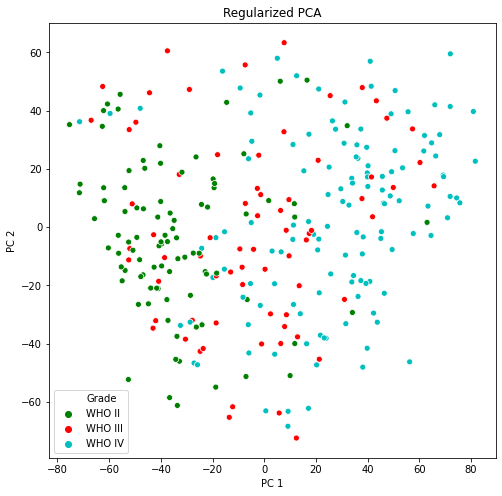

In [26]:
x = sparse_train['PC 1']
y = sparse_train['PC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = sparse_train['Grade'], palette = ['g', 'r', 'c'], hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("Regularized PCA")
plt.show()

## Identify important genes

In [27]:
### Find the 100 top features for top PCs
all_weights = pd.DataFrame(sparse_pca.components_)
col_names = train_data.columns.values
all_weights.columns = col_names
all_weights.head()

,0,2,4,7,15,28,31,32,33,38,39,42,43,44,45,47,50,55,56,61,62,64,65,66,67,68,69,70,78,79,82,86,88,89,96,98,102,103,106,107,...,24150,24155,24156,24160,24163,24164,24165,24168,24184,24191,24202,24203,24207,24214,24215,24220,24223,24224,24237,24244,24253,24255,24256,24260,24261,24271,24272,24273,24277,24283,24285,24288,24291,24296,24308,24309,24313,24316,24317,24323
0,0.004557,0.012671,-0.013243,0.003607,-0.004009,-0.019223,-0.020149,0.0,0.005211,-0.012948,-0.013634,0.000000,0.001216,0.001992,-0.000341,-0.011175,0.014608,0.000000,0.017199,0.019398,-0.001249,0.000000,0.000000,-0.000322,-0.018951,-0.005082,0.015641,-0.006557,-0.013696,-0.011007,-0.008225,-0.010373,-0.017299,-0.011634,-0.016832,-0.000371,-0.018436,-0.010423,0.010754,-0.002568,...,-0.003219,0.002804,0.000837,0.000000,-0.010069,0.00000,-0.008610,0.002637,-0.009905,-0.006157,0.003959,-0.007857,-0.010655,0.000000,0.008098,0.000000,-0.006448,-0.004522,-0.014221,0.000615,-0.002305,-0.000199,0.013128,0.006313,-0.008883,0.009050,-0.002761,-0.005077,0.005209,-0.002775,-0.009132,0.00000,-0.006677,-0.007679,0.012565,-0.012345,0.000881,0.015965,0.016264,0.021192
1,0.011318,0.013532,0.005513,0.020620,0.009450,0.006807,-0.002375,0.0,0.001867,0.003182,0.014318,0.021249,0.014960,0.016583,0.015575,0.010575,0.000000,0.015124,0.000000,0.010314,-0.000578,0.011773,0.000183,0.000000,0.000000,0.011656,0.006790,0.010994,0.001224,0.011467,0.009996,0.017954,0.004534,-0.003287,0.000000,0.000000,0.000000,0.022007,0.015684,0.000112,...,-0.019122,-0.021365,-0.019644,-0.021963,-0.019921,-0.02343,-0.026081,0.000589,0.000000,-0.006780,0.000000,-0.004725,-0.010669,0.006831,-0.005997,0.002047,0.000000,-0.020674,-0.004099,-0.016056,-0.009737,-0.019630,-0.015938,-0.025954,-0.004002,0.017536,-0.000851,-0.005142,0.016781,0.000000,-0.002919,0.00446,0.006392,-0.016184,-0.015724,-0.009823,0.000851,-0.008929,-0.019187,0.002418


In [0]:
sparse_important_genes = []
temp = pd.DataFrame(np.abs(all_weights)).T
for i in range(n):
    sparse_important_genes.extend(temp.nlargest(100, i).index.values)
important_genes = np.unique(sparse_important_genes)

In [29]:
# Make new training and testing sets with these genes
sparse_important_train = train_data[sparse_important_genes]
sparse_important_test = test_data[sparse_important_genes]
sparse_important_train.head()

,19765,13579,4638,2296,20368,12265,3782,10338,18610,11711,19748,4518,7554,21206,4517,19360,3366,10439,2071,19511,7796,12381,9856,4738,3934,22099,20203,10846,1448,4544,2309,22051,4053,9939,8145,8144,7594,11238,8110,3354,...,11510,23846,6344,11364,4701,14597,3489,5621,8469,992,15189,11188,19356,14544,12570,10463,4588,14610,22247,19944,11539,11558,13078,20632,7462,21065,6189,20084,5809,21225,22535,20470,15615,15079,23316,8139,14292,19785,8067,14731
0,3.834929,4.793524,2.023859,7.560607,4.417911,6.420139,4.949721,2.039400,3.371596,3.638037,7.043580,2.401970,6.684492,2.186241,1.319508,8.751534,4.389897,3.234297,5.353578,6.878243,7.248017,10.136980,6.871566,4.935948,2.104873,2.978895,0.353060,2.034238,5.761085,3.468537,5.540384,5.252191,-1.089883,5.912580,5.153886,3.747745,2.018641,5.754430,8.015207,5.025160,...,3.082544,1.457011,3.476171,6.377977,5.140738,2.119570,5.256076,3.054775,1.761866,1.780481,5.513279,4.546741,0.524826,3.405972,0.449275,3.564753,5.460382,7.171918,4.771979,3.415928,0.267669,2.658309,1.804934,2.694751,5.496487,5.574119,2.437594,-0.256993,-1.135687,4.743797,1.603604,1.546741,2.674988,1.393932,0.385850,-0.135687,3.278623,4.243272,3.393932,1.997579
1,6.789899,6.162138,0.240976,4.635100,3.786380,4.003343,7.119215,5.288434,1.259835,7.384113,3.503483,7.286041,7.640581,4.505459,6.014259,7.524105,6.230457,4.391079,3.323965,5.713577,5.488903,7.935746,3.071644,3.398190,4.745708,7.050363,1.851029,4.472155,3.426286,5.164225,4.360827,4.529619,2.516610,5.691174,5.122760,1.101573,3.226668,4.985986,6.963034,6.862128,...,1.511373,0.977941,4.627859,5.578950,4.737882,1.073422,6.964472,4.716993,2.869565,1.332898,3.338823,6.579732,0.954980,3.343251,1.419313,4.176270,5.071199,5.541549,4.051040,2.253576,1.747936,0.875691,2.547637,3.462011,6.878617,6.083381,3.901941,-0.637718,1.356453,4.872631,2.447005,2.524430,3.644100,2.648877,1.747936,0.859297,2.865466,5.238997,3.656013,0.108525
2,3.980754,5.092696,1.568628,7.438893,4.375983,5.735642,4.657459,1.985119,2.987297,3.307919,5.404373,1.484797,6.307047,2.463055,1.620056,8.585347,4.683210,2.459922,4.041745,6.136523,8.258288,10.552323,6.202678,4.944789,2.786859,1.515299,0.369319,0.447322,5.506216,3.990557,6.261890,5.117264,-0.713143,5.355477,6.189735,3.342352,1.927315,5.791851,8.250037,4.659509,...,1.993810,0.774303,2.325238,5.144350,5.831178,1.509250,5.915070,4.307047,1.472413,1.484797,4.238313,2.828751,-0.100166,2.583099,-0.176115,1.647855,4.781223,5.650262,4.125196,3.042792,-0.045718,2.902144,1.145813,3.017444,5.520195,6.697579,2.642338,1.153591,0.229142,4.801165,-0.363200,0.881218,2.453636,0.603117,0.945349,0.497075,3.256484,5.256032,4.757815,0.484797
3,3.973358,5.263910,2.010395,5.807982,3.889992,5.091194,4.413122,2.797666,1.969943,3.662472,4.293238,3.114577,5.789456,2.722550,2.043260,7.561443,4.725590,3.328329,3.685555,5.593972,7.296564,9.614244,3.584234,4.480065,3.213185,3.533090,1.666696,3.097467,4.688675,5.004566,6.134921,5.168824,0.458297,4.822491,5.768971,3.310890,3.503872,5.175510,7.797606,5.024866,...,1.320306,1.357368,2.143662,5.643842,5.552054,2.752670,4.975913,4.229697,1.036746,3.221824,3.827217,2.325659,-0.036911,2.926564,1.687636,1.167707,6.820952,5.737437,3.646518,2.069023,1.287763,1.679296,1.708275,3.100593,6.163790,6.437896,3.959650,0.191358,0.081734,5.249548,1.185482,0.691787,1.601991,2.205946,1.423770,0.293238,4.241782,5.679819,4.545760,1.704171
4,4.019301,4.660704,1.324421,6.053702,4.096306,5.101051,4.298032,3.154270,1.741260,3.965967,4.588957,2.930863,5.844529,2.680565,1.367065,8.198295,4.737879,2.631849,3.455352,6.656233,7.777527,10.555030,7.126743,5.040314,3.282335,2.529188,0.956689,0.947351,5.236112,4.128681,6.314241,5.254685,-1.071508,5.001365,6.482071,3.178416,1.952028,5.264117,8.126679,5.499945,...,1.814991,1.937952,2.478226,5.614255,5.463972,1.435452,7.251132,5.371436,1.219723,2.015955,4.407634,6.072077,-0.342156,1.942659,-0.090617,2.276754,4.585199,5.156804,3.823948,4.051252,0.563208,2.634761,1.830312,3.567785,6.984203,5.401664,3.522915,2.741260,0.435452,5.

# ICA

Mushes all the grades together...

## Implement

In [0]:
from sklearn.decomposition import FastICA

In [0]:
ica = FastICA(n_components = 100, random_state = 20)
ica_train_genes = ica.fit_transform(train_data)
ica_test_genes = ica.transform(test_data)

In [32]:
ica_train = pd.concat([pd.DataFrame(ica_train_genes), pd.DataFrame(train_lbl)], axis = 1)

col_titles = [f'IC {x}' for x in range(1, 102)]
col_titles[-1] = 'Grade'
ica_train.columns = col_titles

ica_train.head()

,IC 1,IC 2,IC 3,IC 4,IC 5,IC 6,IC 7,IC 8,IC 9,IC 10,IC 11,IC 12,IC 13,IC 14,IC 15,IC 16,IC 17,IC 18,IC 19,IC 20,IC 21,IC 22,IC 23,IC 24,IC 25,IC 26,IC 27,IC 28,IC 29,IC 30,IC 31,IC 32,IC 33,IC 34,IC 35,IC 36,IC 37,IC 38,IC 39,IC 40,...,IC 62,IC 63,IC 64,IC 65,IC 66,IC 67,IC 68,IC 69,IC 70,IC 71,IC 72,IC 73,IC 74,IC 75,IC 76,IC 77,IC 78,IC 79,IC 80,IC 81,IC 82,IC 83,IC 84,IC 85,IC 86,IC 87,IC 88,IC 89,IC 90,IC 91,IC 92,IC 93,IC 94,IC 95,IC 96,IC 97,IC 98,IC 99,IC 100,Grade
0,-0.024892,-0.026553,-0.031295,0.044281,-0.016689,0.016236,0.011504,-0.002484,-0.005134,-0.042523,0.025649,0.004078,-0.046206,-0.023730,-0.023125,-0.016336,-0.079113,-0.029297,-0.013379,0.015406,0.017809,-0.004880,-0.018456,0.046492,-0.008638,-0.021926,0.057777,-0.020803,0.015301,0.065104,0.000086,-0.007389,0.063497,0.011684,-0.013803,-0.047519,0.046525,-0.020263,0.015216,0.004842,...,-0.002358,0.039483,-0.034860,-0.003683,0.002887,-0.017687,0.024139,-0.000010,-0.033229,-0.002652,-0.003184,0.029388,0.005704,0.046959,0.057714,-0.042393,-0.015355,-0.023684,0.013283,0.002144,0.035239,-0.004947,0.015449,-0.041978,-0.049139,0.048463,-0.040759,0.011584,-0.017101,0.017137,0.010199,0.023654,-0.004111,-0.030139,-0.062884,0.015086,0.001281,-0.005549,-0.007344,WHO II
1,0.030773,-0.014559,0.003330,-0.028359,0.073011,-0.073407,0.064684,-0.001069,0.050736,0.014502,-0.033376,0.007396,0.053320,0.055479,0.056058,0.121976,-0.064176,0.076244,0.073353,0.025457,-0.070740,-0.077235,0.022098,0.064892,0.017763,-0.013709,0.016840,-0.485835,-0.103589,0.029467,0.010680,0.019103,0.091009,-0.037791,0.006331,-0.010541,0.040557,-0.044080,-0.026665,0.024751,...,0.000523,0.011377,0.013826,0.043922,0.059652,0.029930,0.034406,0.014604,0.052743,-0.040722,0.052533,-0.012543,0.035659,0.033024,-0.053706,-0.007083,-0.156478,-0.101585,0.076805,0.016818,-0.046192,0.023160,0.023273,0.032346,0.027969,-0.060847,-0.139456,0.070925,0.007396,0.028788,0.021103,-0.027946,0.006460,-0.004648,0.019420,0.041436,-0.020413,0.012379,-0.037993,WHO IV
2,-0.122491,0.002435,-0.013051,0.025362,-0.067789,0.042747,0.008077,0.021326,0.022937,-0.040037,0.021995,0.021812,-0.298378,-0.057525,0.004386,-0.039483,-0.002284,-0.001665,0.025180,-0.009601,-0.014044,-0.003535,0.009927,0.009083,0.005125,0.090180,0.031072,0.005474,0.046919,-0.099111,-0.012092,0.024270,0.001222,-0.010428,-0.023893,-0.029318,0.023560,-0.009001,-0.044721,0.047337,...,0.006448,-0.000926,0.004622,0.006969,0.030452,-0.023007,0.045485,0.034261,0.017149,0.007224,0.007177,-0.011211,-0.004873,0.036852,0.007107,-0.021665,0.032317,0.014220,0.033621,-0.017850,0.023880,-0.017178,0.005351,0.045905,0.055108,-0.001308,0.000875,-0.017823,-0.018242,0.011731,-0.009508,0.048659,-0.011813,0.011921,-0.039908,-0.038101,0.059089,0.025299,-0.056331,WHO II
3,-0.024014,-0.006886,0.012895,0.061364,-0.062479,0.019430,0.029769,0.075644,0.019235,-0.025494,-0.005309,-0.003187,0.006800,0.007620,-0.027490,-0.003022,0.093353,-0.034276,-0.008835,-0.007470,-0.024614,-0.019935,0.003715,0.004296,-0.007168,-0.028074,0.032835,0.050557,-0.085523,0.130698,-0.036486,-0.014708,0.017662,-0.006879,0.018421,0.006384,0.024011,0.005371,0.009230,0.037298,...,-0.025745,0.010284,0.006717,-0.030871,-0.017372,-0.133733,0.019027,-0.027725,-0.036115,-0.012622,0.043466,0.005224,0.049664,0.005540,0.056181,0.030664,0.068503,-0.074788,0.061647,0.000874,0.006705,0.037748,-0.016516,-0.084876,0.013664,-0.032540,0.059381,0.029820,0.021077,0.013772,0.020017,0.033889,-0.025273,-0.013015,0.000361,-0.035344,-0.025798,-0.020149,-0.047183,WHO II
4,0.078726,0.041614,0.023761,0.007195,0.009681,0.004315,-0.008001,0.037354,0.036482,-0.121841,-0.016071,0.013803,0.028610,-0.000164,0.016430,-0.082554,0.024858,-0.005218,-0.029265,-0.083612,-0.022902,-0.000073,0.000632,0.093391,-0.005006,-0.063850,-0.033379,-0.014860,-0.003723,0.026593,-0.016982,0.028182,-0.063813,0.069045,0.016799,-0.063688,0.055732,-0.007944,0.003509,-0.059149,...,0.042084,-0.083910,-0.007298,-0.024866,-0.042950,0.022528,-0.027833,0.026365,0.021540,0.011555,-0.0

In [33]:
ica_test = pd.concat([pd.DataFrame(ica_test_genes), pd.DataFrame(test_lbl)], axis = 1)

col_titles = [f'IC {x}' for x in range(1, 102)]
col_titles[-1] = 'Grade'
ica_test.columns = col_titles

ica_test.head()

,IC 1,IC 2,IC 3,IC 4,IC 5,IC 6,IC 7,IC 8,IC 9,IC 10,IC 11,IC 12,IC 13,IC 14,IC 15,IC 16,IC 17,IC 18,IC 19,IC 20,IC 21,IC 22,IC 23,IC 24,IC 25,IC 26,IC 27,IC 28,IC 29,IC 30,IC 31,IC 32,IC 33,IC 34,IC 35,IC 36,IC 37,IC 38,IC 39,IC 40,...,IC 62,IC 63,IC 64,IC 65,IC 66,IC 67,IC 68,IC 69,IC 70,IC 71,IC 72,IC 73,IC 74,IC 75,IC 76,IC 77,IC 78,IC 79,IC 80,IC 81,IC 82,IC 83,IC 84,IC 85,IC 86,IC 87,IC 88,IC 89,IC 90,IC 91,IC 92,IC 93,IC 94,IC 95,IC 96,IC 97,IC 98,IC 99,IC 100,Grade
0,-0.022452,-0.017044,-0.039098,-0.018152,0.049632,0.039395,0.016128,-0.055896,0.076133,0.007682,-0.020223,0.005609,-0.078320,-0.018122,0.049586,-0.014327,0.049009,0.071758,-0.049112,0.007391,0.040160,0.027825,0.013073,-0.015881,0.006889,0.039512,0.007270,-0.032878,-0.013534,-0.070222,-0.007427,0.055227,-0.080231,0.071168,0.026200,-0.026413,-0.031946,0.019239,0.007703,-0.032709,...,-0.004422,-0.045201,0.011857,-0.048545,-0.038545,-0.012329,-0.010706,-0.021088,-0.006798,0.069852,0.022052,0.019224,0.024492,0.008726,-0.067658,0.031016,-0.003491,0.007849,-0.029168,0.014205,-0.015610,0.051195,0.034083,0.017587,0.100685,-0.001122,-0.004519,-0.027572,-0.001213,-0.032451,-0.010095,0.054252,-0.501063,-0.020016,-0.006691,0.004380,-0.072856,0.007047,0.053422,WHO IV
1,0.043283,-0.071810,0.065661,-0.006895,0.006318,0.002340,-0.096008,-0.013866,-0.003865,0.084008,-0.025542,0.044643,0.032408,0.121185,0.072176,-0.027356,-0.151485,-0.030046,0.055294,0.000189,-0.010962,-0.056665,-0.019056,0.062821,0.025314,0.020141,-0.002053,0.067824,0.048972,-0.088896,-0.000685,0.076418,-0.011401,-0.014362,-0.008547,0.043960,0.082543,-0.014155,0.012514,0.094415,...,0.003976,-0.024071,-0.021041,-0.017225,0.044922,-0.095748,-0.019182,-0.047815,0.055133,-0.061492,0.066120,0.003218,-0.066506,0.035848,0.018261,-0.111377,0.056367,0.026975,0.027227,-0.035354,-0.044259,-0.006250,-0.021523,0.020530,0.004527,0.040589,0.020045,-0.025089,0.011842,-0.197077,0.022854,0.044266,-0.033786,0.009673,0.037060,0.018169,0.066827,0.045754,-0.074330,WHO IV
2,-0.021560,0.040134,0.005045,-0.005684,-0.041170,-0.002212,-0.014911,-0.057014,-0.009061,-0.048304,0.007430,-0.005707,-0.106870,-0.024589,-0.025580,-0.044979,0.032324,-0.000437,0.032680,-0.015631,-0.009144,-0.022430,-0.013546,0.045129,-0.011824,-0.040437,0.023818,-0.000379,0.031313,0.025361,-0.017309,0.029948,-0.028997,0.065187,0.027294,-0.032785,0.065688,-0.014799,-0.016633,0.002083,...,-0.000806,-0.035970,-0.010959,0.000352,0.000480,0.063091,0.017777,0.001789,0.071692,0.008763,-0.033944,-0.015961,0.005024,0.019456,0.002454,0.013129,-0.027203,0.023110,0.019585,0.006208,-0.025757,0.058812,-0.006094,-0.017307,0.060926,-0.037126,0.024496,0.002852,0.007570,0.012783,-0.052778,0.025588,0.000909,-0.002267,-0.040362,-0.014941,0.016416,0.015628,-0.006854,WHO II
3,0.014173,0.017930,-0.017505,-0.020460,0.006094,-0.004059,-0.046312,-0.013807,0.011394,-0.066782,0.020424,0.008329,0.006201,0.010339,-0.024931,0.015325,0.039231,-0.011575,0.030774,0.005296,0.006436,0.022436,-0.013805,0.038383,-0.005673,0.021960,0.015739,0.031518,0.021341,0.040586,0.017509,0.013228,0.046307,-0.010174,-0.012437,-0.005776,0.010076,-0.013720,-0.009870,0.005564,...,0.019252,-0.011474,-0.017015,0.005622,0.003057,-0.063800,0.061223,0.004684,0.033042,0.016109,0.008562,-0.022873,0.008593,0.020033,0.011839,0.027461,-0.030837,0.002498,0.020768,0.002869,-0.003261,0.058136,0.011940,-0.026030,-0.035538,-0.004411,-0.029406,-0.004272,-0.020492,0.021475,0.011624,0.059743,-0.014667,0.001841,-0.012451,-0.004262,0.051155,0.016284,-0.051383,WHO II
4,0.007319,-0.004302,-0.000410,-0.005711,-0.000865,0.012824,0.022764,0.012495,-0.011153,-0.100278,0.024108,0.009220,-0.026002,-0.001333,-0.005275,0.036657,0.047907,0.007420,0.051040,-0.002965,0.019972,-0.005500,-0.013727,0.015898,-0.017770,0.001039,-0.000694,0.024403,0.030043,0.095235,-0.013931,-0.016728,0.010993,0.014352,-0.012095,-0.008394,-0.010372,-0.000343,0.014076,0.031911,...,0.013327,-0.017330,-0.020059,0.034078,-0.019223,-0.123368,0.053067,0.039446,0.038042,0.00191

## Plot ICs

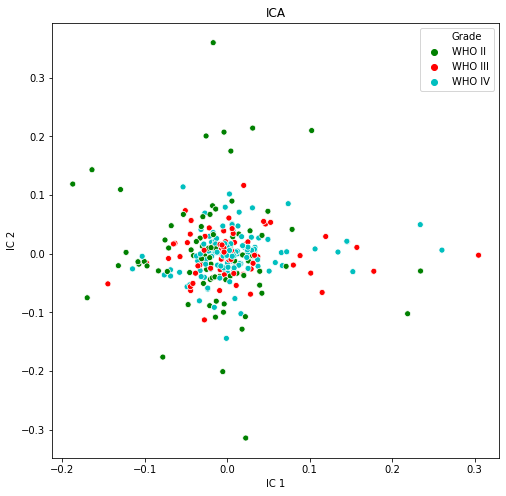

In [34]:
x = ica_train['IC 1']
y = ica_train['IC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = ica_train['Grade'], palette = ['g', 'r', 'c'], hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("ICA")
plt.show()

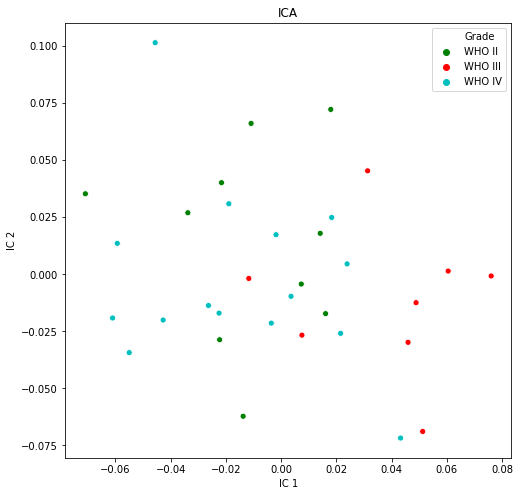

In [35]:
x = ica_test['IC 1']
y = ica_test['IC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = ica_test['Grade'], palette = ['g', 'r', 'c'], hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("ICA")
plt.show()

## Identify important genes

In [36]:
### Find the 100 top features for top PCs
all_weights = pd.DataFrame(ica.components_)
col_names = train_data.columns.values
all_weights.columns = col_names
all_weights.head()

,0,2,4,7,15,28,31,32,33,38,39,42,43,44,45,47,50,55,56,61,62,64,65,66,67,68,69,70,78,79,82,86,88,89,96,98,102,103,106,107,...,24150,24155,24156,24160,24163,24164,24165,24168,24184,24191,24202,24203,24207,24214,24215,24220,24223,24224,24237,24244,24253,24255,24256,24260,24261,24271,24272,24273,24277,24283,24285,24288,24291,24296,24308,24309,24313,24316,24317,24323
0,-0.000004,0.000114,-0.000015,0.000045,0.000033,-3.216819e-05,0.000034,0.000273,-0.000132,0.000016,0.000023,0.000074,0.000189,0.000057,-0.000104,0.000160,0.000188,-0.000061,-0.000036,-0.000119,-0.000054,0.000152,0.000128,0.000111,-0.000012,-1.982437e-07,-0.000058,-0.000077,0.000075,-0.000030,0.000028,-0.000186,6.640323e-05,0.000137,-0.000071,0.000099,0.000070,-0.000094,0.000004,-0.000222,...,0.000101,0.000074,0.000107,0.000087,-0.000010,0.000001,0.000004,0.000033,0.000018,0.000019,-0.000006,0.000025,0.000110,-0.000072,0.000012,-0.000077,0.000188,0.000012,-9.750660e-08,0.000007,0.000008,-0.000106,0.000030,-0.000039,0.000065,0.000040,0.000021,0.000045,0.000056,-0.000036,0.000055,-0.000181,-0.000015,-0.000027,-0.000039,0.000025,-0.000020,-0.000040,-0.000037,-0.000037
1,0.000123,0.000051,-0.000026,0.000037,0.000062,-2.090187e-05,0.000006,-0.000034,0.000112,-0.000032,-0.000019,0.000107,-0.000074,0.000104,-0.000002,0.000139,0.000062,0.000098,-0.000021,0.000168,0.000055,0.000159,0.000139,0.000089,0.000009,-2.484744e-06,0.000060,-0.000005,0.000084,0.000078,0.000212,-0.000130,1.730936e-05,-0.000017,-0.000033,-0.000047,-0.000028,0.000087,-0.000024,-0.000174,...,0.000027,0.000068,-0.000009,-0.000109,-0.000015,-0.000025,0.000038,0.000077,-0.000060,0.000012,0.000049,0.000004,0.000011,0.000001,-0.000005,-0.000016,-0.000074,0.000037,4.881630e-06,0.000102,0.000084,0.000009,0.000106,0.000102,-0.000227,-0.000001,0.000103,-0.000069,-0.000214,0.000022,-0.000009,0.000135,0.000038,0.000063,-0.000057,0.000027,0.000115,0.000026,0.000145,0.000003
2,-0.000024,-0.000027,0.000077,0.000120,0.000033,1.330304e-05,-0.000123,-0.000021,-0.000060,0.000033,0.000017,-0.000082,-0.000082,0.000061,0.000083,0.000034,0.000113,0.000067,0.000033,0.000080,-0.000048,-0.000079,-0.000226,-0.000145,0.000208,5.602911e-05,0.000029,-0.000011,0.000007,0.000058,-0.000059,-0.000031,-7.076294e-07,-0.000098,0.000051,-0.000037,0.000040,-0.000013,0.000083,0.000050,...,-0.000067,0.000037,-0.000080,-0.000131,-0.000099,0.000004,-0.000044,-0.000008,-0.000096,0.000018,0.000006,-0.000046,-0.000130,0.000318,-0.000007,-0.000044,0.000173,-0.000096,-1.005806e-04,-0.000054,-0.000097,0.000048,0.000048,-0.000085,0.000018,-0.000014,0.000031,-0.000018,-0.000036,0.000032,-0.000134,-0.000005,0.000023,-0.000108,-0.000055,-0.000039,-0.000082,0.000031,0.000094,0.000047
3,0.000166,-0.000031,-0.000170,0.000004,-0.000087,-4.033348e-05,0.000082,-0.000035,-0.000013,-0.000015,0.000019,-0.000075,-0.000151,-0.000103,-0.000088,-0.000011,-0.000011,0.000003,0.000017,0.000125,0.000113,-0.000064,-0.000028,0.000067,-0.000033,-6.055586e-06,0.000026,-0.000098,-0.000007,-0.000211,-0.000001,-0.000189,7.108199e-05,0.000116,-0.000007,-0.000106,0.000023,-0.000085,0.000052,0.000102,...,-0.000022,0.000030,0.000003,0.000011,-0.000008,-0.000053,0.000028,0.000255,-0.000126,0.000013,0.000026,0.000039,0.000051,-0.000124,0.000094,0.000165,0.000066,-0.000016,1.774557e-06,0.000033,0.000026,0.000052,0.000011,-0.000006,-0.000032,-0.000028,-0.000126,-0.000012,0.000050,0.000061,0.000137,-0.000023,0.000126,-0.000061,-0.000010,0.000088,0.000049,-0.000007,-0.000029,0.000012
4,-0.000065,0.000016,0.000023,0.000073,-0.000007,-4.847712e-07,0.000070,0.000097,0.000146,-0.000025,-0.000006,0.000007,-0.000064,0.000057,-0.000001,-0.000009,-0.000145,0.000120,0.000031,-0.000066,0.000030,-0.000198,-0.000021,0.000063,-0.000051,9.369915e-05,0.000075,0.000126,0.000070,-0.000049,0.000026,0.000192,-1.413601e-05,-0.000070,-0.000006,0.000095,-0.000006,0.000088,-0.000040,0.000013,...,-0.000028,0.000138,-0.000069,-0.000051,-0.000004,-0.000054,-0.000030,-0.000008,-0.000009,0.000028,-0.000028,0.000064,-0.0

In [0]:
ica_important_genes = []
temp = pd.DataFrame(np.abs(all_weights)).T
for i in range(50):
    ica_important_genes.extend(temp.nlargest(100, i).index.values)
ica_important_genes = np.unique(ica_important_genes)

In [38]:
# Make new training and testing sets with these genes
ica_important_train = train_data[ica_important_genes]
ica_important_test = test_data[ica_important_genes]
ica_important_train.head()

,0,10013,10030,10042,10057,10083,10093,10111,1013,10144,10146,1016,10170,10173,10176,10190,10191,10197,10199,10200,10205,10213,10240,10257,10261,10282,10286,10291,10293,10311,10329,10344,10391,10396,10410,10414,10422,10426,10465,10466,...,9667,9684,9689,9706,9708,9744,9746,9757,977,9817,9819,9821,9826,9834,9837,984,9841,9843,9853,9863,9867,9870,9871,9876,9877,9883,9884,9888,9891,9897,9901,9904,9906,9910,9921,9930,9948,9955,9967,9982
0,4.216178,0.792760,1.158044,2.385850,1.204737,2.472359,5.247738,2.510029,2.134118,4.025160,5.153886,5.602296,3.462786,2.114688,0.336381,3.197829,0.852631,8.562009,0.755607,-0.767955,2.553973,2.310996,-0.282529,2.049668,-0.361963,-2.182993,0.080042,-0.045489,4.166325,1.954511,1.810983,4.398961,1.425816,0.986932,-3.767955,1.417911,-0.389444,-0.630452,3.681606,3.425816,...,-0.231902,1.018641,-0.697566,-1.135687,1.080042,1.353060,5.048388,4.384837,2.586074,2.008149,0.176903,0.954511,2.069988,2.460863,-0.089883,0.596617,5.576784,1.786634,0.213897,0.624362,5.026461,0.943540,2.904470,3.519295,1.638037,3.457011,1.176903,1.561168,2.029058,0.099941,7.131855,1.893110,-0.256993,2.340569,-0.159146,3.918545,-1.630452,-1.135687,0.596617,1.834929
1,1.284603,0.756814,0.495548,1.266067,-0.525825,-0.037326,4.697528,1.176270,2.734515,5.791790,2.921813,1.958832,0.290729,-0.919489,3.231453,0.474175,-1.269986,1.597910,-2.343987,-3.132483,-0.784559,2.983625,-1.234362,-2.891475,-1.685024,-0.269986,-3.006952,-0.234362,4.468782,0.962674,-0.288134,3.736761,-0.661177,-0.614634,-3.269986,-2.132483,-0.116181,1.838538,2.547637,3.627254,...,-1.006952,0.000000,-1.948058,1.162973,1.993048,0.408086,2.037442,3.945304,0.808965,-0.288134,-0.685024,-2.006952,0.240976,1.842714,0.597910,-1.637718,5.977704,1.506118,-1.100061,-2.199597,2.208986,-0.504452,1.542512,2.698104,0.867517,-0.661177,-0.363096,0.899939,0.547637,-0.288134,5.451455,1.385366,0.302903,0.350600,-1.837027,1.587995,-0.022059,3.918850,-1.685024,3.340300
2,3.088138,0.753983,1.286857,1.985119,0.300932,0.408848,5.377229,3.769250,-0.319479,3.604536,4.390042,4.254677,3.469300,2.053224,0.545169,4.752704,-0.800606,5.623561,-0.862006,-0.028016,2.647855,2.169021,-1.741712,-0.657648,0.000000,-0.063640,0.408848,-1.800606,4.145813,1.936360,2.965371,4.443362,2.304430,2.161326,0.421787,-2.926137,-1.256285,-2.926137,4.243788,3.176674,...,0.355899,-0.277044,0.214345,-0.478678,-1.478678,-0.478678,4.569355,4.933539,1.774303,0.199394,-2.478678,1.369319,3.023823,3.325238,0.199394,-2.063640,3.982938,-1.298105,-0.277044,-1.862006,4.590280,0.871820,1.799307,2.503175,1.362625,2.304430,1.971984,-0.341174,0.794341,-1.741712,5.663259,0.434611,-0.478678,1.733373,-0.604208,1.032284,0.591712,3.349141,0.258288,1.701895
3,2.106825,1.487249,2.167707,1.081734,0.666696,0.143662,4.318965,0.748690,1.870896,3.820597,3.979314,3.113030,3.103712,0.561727,1.062625,3.322985,0.203040,6.859292,2.856174,0.969943,3.146689,1.945811,0.203040,1.113030,-1.050716,-1.465754,-0.078731,0.833806,2.732660,0.708275,1.372965,1.615166,2.681386,3.942331,0.803433,0.615166,0.030204,-1.465754,2.628222,3.057808,...,-0.918266,0.346876,0.003731,0.428753,2.260071,1.732660,3.280890,4.477663,1.700055,-0.151243,0.378127,1.069023,3.065827,5.032661,-0.918266,1.043260,1.463163,-0.393604,-0.181301,0.069023,4.615712,1.472846,1.803433,2.125361,1.487249,-0.601409,-0.023236,1.243197,0.780225,1.293238,4.961371,3.512113,-0.728788,2.091194,0.969943,0.534246,-0.685067,4.143662,-1.503229,1.736684
4,4.037017,2.211946,1.131776,-0.071508,-0.109982,1.544751,4.716738,1.928492,0.474980,1.918969,3.982061,3.387924,3.862959,-0.052649,2.569308,7.113367,-3.512081,4.984345,1.461924,-0.090617,1.646349,2.468467,-1.412545,0.000000,-2.860004,-0.512081,0.513455,-1.860004,3.957852,0.840436,1.628932,3.834117,2.360045,3.684785,-0.795873,-1.734473,-0.149510,-2.319435,5.856738,3.416966,...,0.563208,-1.997507,1.081444,1.422032,-0.675579,-0.436792,3.939131,5.205106,3.186376,-1.675579,-1.860004,-1.149510,2.688993,2.799506,-0.342156,-1.319435,2.954360,-3.997507,0.295274,-0.297068,4.

# K-Means

## On all 8000+ genes

### Implement

In [0]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)

kmeans.fit(train_data)
test_pred = kmeans.predict(test_data)

In [40]:
kmeans_test = pd.concat([pd.DataFrame(pca_test_genes), pd.DataFrame(test_pred), pd.DataFrame(test_lbl)], axis = 1)

col_titles = [f'PC {x}' for x in range(1, 103)]
col_titles[-2:] = ['K-Means Group', 'Grade']
kmeans_test.columns = col_titles

kmeans_test = kmeans_test.replace({'K-Means Group': {0:'WHO III', 2:'WHO IV', 1:'WHO II'}})

kmeans_test.head()

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,PC 11,PC 12,PC 13,PC 14,PC 15,PC 16,PC 17,PC 18,PC 19,PC 20,PC 21,PC 22,PC 23,PC 24,PC 25,PC 26,PC 27,PC 28,PC 29,PC 30,PC 31,PC 32,PC 33,PC 34,PC 35,PC 36,PC 37,PC 38,PC 39,PC 40,...,PC 63,PC 64,PC 65,PC 66,PC 67,PC 68,PC 69,PC 70,PC 71,PC 72,PC 73,PC 74,PC 75,PC 76,PC 77,PC 78,PC 79,PC 80,PC 81,PC 82,PC 83,PC 84,PC 85,PC 86,PC 87,PC 88,PC 89,PC 90,PC 91,PC 92,PC 93,PC 94,PC 95,PC 96,PC 97,PC 98,PC 99,PC 100,K-Means Group,Grade
0,-17.018512,-76.678514,15.561575,3.062705,-7.722775,-8.775855,-4.664845,23.154769,0.509306,7.973493,-3.623431,5.865838,-4.550082,12.146977,-1.392681,-18.247655,6.898328,0.944234,11.385726,6.992770,12.331238,11.713086,0.710077,2.287172,-13.372765,6.968041,-10.298332,8.281167,-2.427184,-1.382116,-4.428495,1.189871,9.345460,11.165574,8.224162,0.316288,-5.162597,6.389885,9.948396,-1.074746,...,-3.197128,-0.143310,-1.270086,7.528369,2.055503,-5.333428,6.268508,0.078297,-3.276162,-0.453180,1.323430,-9.156285,8.630677,5.765287,6.622815,3.409527,-9.926912,-6.116751,5.465556,-0.973197,-3.731823,6.626961,-4.109379,-0.879745,0.127893,-3.803998,3.614193,0.048250,-2.899580,-1.551742,4.094361,-0.328319,-2.426534,3.283960,-4.978379,-2.093411,-4.246000,1.392405,WHO III,WHO IV
1,10.671509,6.637014,61.410853,35.650646,23.106030,-2.143411,-25.585952,-1.896259,-3.161317,29.643123,20.772154,-8.631343,10.109134,-4.321388,-1.290504,12.302256,5.606665,10.250756,-11.291593,8.424251,-7.446641,0.821122,6.364189,-1.287883,-0.528536,-2.792364,-0.898207,3.480841,13.059164,9.267527,-0.347305,-0.757466,9.309101,-10.087992,-1.771065,-4.107091,1.861269,-1.857201,0.604133,4.200106,...,1.809971,-2.988788,0.647669,2.470109,-2.665681,-1.667134,5.049326,5.713522,-2.427822,-3.809754,3.298483,2.034078,1.610837,-2.650715,0.027485,1.787696,2.078637,-2.181849,-0.176825,3.988677,0.841327,0.843844,-4.294727,-2.569276,-3.677456,2.771831,3.985848,1.352749,-4.459143,-4.306666,-0.474310,0.815713,1.557357,-0.717527,-3.843549,-2.087681,3.733449,0.008205,WHO IV,WHO IV
2,-47.478944,19.938839,0.775281,-5.393338,1.060001,-1.258295,18.845096,10.749328,8.432678,-1.510646,2.499019,2.215205,-3.571154,5.633107,3.777485,3.711312,-0.019695,-0.570238,-3.033789,4.688640,9.407064,-0.977668,-0.793261,0.618236,-4.136842,8.104762,1.443780,2.798849,-0.375756,-5.154681,-0.702524,3.024305,7.074151,6.507438,-4.232588,-4.472853,2.409570,-2.027083,-0.704039,5.608382,...,1.095985,-0.129219,-2.472738,1.127178,-3.152503,-0.426621,-2.651263,-2.184907,1.679962,-0.023509,1.857405,0.330693,-0.111450,-1.890244,3.137612,2.764058,-3.171187,0.351696,1.795306,-3.253062,0.999530,1.235816,0.087417,-0.315057,-2.167105,-2.291935,-2.714354,0.613106,0.767404,1.055777,-0.316400,0.281573,0.362711,-0.987278,2.479443,1.605464,-1.518974,0.128048,WHO II,WHO II
3,-46.293701,-8.338783,-8.556460,-11.787487,7.931988,-12.844719,6.540818,-18.449527,8.280566,2.268330,6.155864,6.697970,12.439044,-3.760193,3.322000,1.446556,-10.136128,-5.682184,-2.643613,3.815846,-2.070176,7.834681,-0.858004,-0.564004,-3.170614,-0.353465,-2.031324,3.339676,-3.248661,3.050186,3.204771,-0.560890,0.363286,3.926756,-1.125296,-1.214816,-0.560080,1.225001,-1.566592,0.479275,...,2.890916,-0.705937,-0.002263,0.538249,0.925144,-0.943887,-0.997912,-0.542422,-0.795057,1.968297,3.123509,0.191454,0.629973,-0.802764,1.378244,1.614012,0.906229,2.049833,-0.569304,0.790234,-0.425043,-2.275452,1.844780,1.288615,-0.603150,0.371771,1.635540,-0.873952,1.444501,-1.680922,-0.551190,-0.391136,-0.765349,0.254669,2.381193,0.293890,-1.085323,-0.797865,WHO III,WHO II
4,-39.708933,-1.918164,-1.080752,-5.932954,7.909139,-28.034350,4.023441,-14.541410,18.140569,-0.283968,4.532058,6.897554,6.876141,-6.633340,1.865254,2.966991,-10.198865,1.619051,-1.489895,2.532259,4.959692,6.446161,-2.915481,-0.140089,-4.472868,4.331271,-2.180906,0.614712,-1.106064,-1.564332,-3.963458,-4.127570,-1.506200,0.807357,-1.416793,-0.039085,0.160181,-0.614034,1.396443,-0.092935,...,2.369309,0.646424,-1.479211,0.584148,2.040954,-

In [41]:
kmeans_train = pd.concat([pd.DataFrame(pca_train_genes), pd.DataFrame(kmeans.labels_), pd.DataFrame(train_lbl)], axis = 1)

col_titles = [f'PC {x}' for x in range(1, 103)]
col_titles[-2:] = ['K-Means Group', 'Grade']
kmeans_train.columns = col_titles

kmeans_train = kmeans_train.replace({'K-Means Group': {0:'WHO III', 2:'WHO IV', 1:'WHO II'}})

kmeans_train.head()

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,PC 11,PC 12,PC 13,PC 14,PC 15,PC 16,PC 17,PC 18,PC 19,PC 20,PC 21,PC 22,PC 23,PC 24,PC 25,PC 26,PC 27,PC 28,PC 29,PC 30,PC 31,PC 32,PC 33,PC 34,PC 35,PC 36,PC 37,PC 38,PC 39,PC 40,...,PC 63,PC 64,PC 65,PC 66,PC 67,PC 68,PC 69,PC 70,PC 71,PC 72,PC 73,PC 74,PC 75,PC 76,PC 77,PC 78,PC 79,PC 80,PC 81,PC 82,PC 83,PC 84,PC 85,PC 86,PC 87,PC 88,PC 89,PC 90,PC 91,PC 92,PC 93,PC 94,PC 95,PC 96,PC 97,PC 98,PC 99,PC 100,K-Means Group,Grade
0,-33.435050,22.490684,38.097767,33.143324,-17.619484,-3.171189,20.422848,-43.082417,-8.627835,-40.189724,-5.465844,12.660643,6.474901,1.849231,17.776083,3.826548,5.573438,-7.040284,5.135255,-1.664143,-6.166108,4.009497,-1.826724,9.007044,6.159015,-7.805794,-4.325186,1.482421,-4.201913,4.000561,3.878437,-5.415432,-7.375138,-0.160841,-0.510255,2.192920,-2.173354,0.006804,-1.058477,-3.204084,...,5.008607,4.860570,4.643102,-0.535064,3.778756,0.622315,-2.530857,4.880558,1.727614,2.745107,4.730745,-1.841157,-0.922712,-2.406000,3.271590,5.472156,-3.876619,-1.981077,0.952377,-0.021147,1.547086,1.605269,4.035455,-1.445632,2.115250,5.634296,5.456446,0.133883,-1.037756,-1.739495,-0.737192,1.721679,-2.759915,2.641812,6.675747,-5.530448,2.266418,4.370240,WHO II,WHO II
1,23.423648,-7.423201,-17.507606,8.792664,6.431291,18.670121,9.897023,4.258872,-5.588874,-21.095125,-0.321909,0.209251,0.053999,-8.668732,0.180358,-4.388500,-2.999501,16.385283,-4.155462,-6.636527,-1.222793,-4.239253,5.987897,2.546961,-3.713511,1.623914,11.720301,4.274339,6.207523,2.401989,4.092058,-1.791507,-5.777590,-3.696712,6.245213,-4.232292,2.452928,-8.434929,10.449914,-0.615956,...,-0.177286,5.996773,-4.823631,-2.647002,-9.367976,-10.885565,-8.859610,1.501207,-6.202868,2.906427,-1.303148,5.989333,0.385217,-0.763037,-3.998872,4.238178,-2.304791,2.287783,-3.320622,-2.134242,7.699306,-10.091441,4.306083,8.596004,5.962502,1.032129,-7.437804,1.079408,4.134540,1.039711,4.062908,-4.534138,-4.315585,-1.729684,2.638636,0.672170,2.707216,-2.451562,WHO IV,WHO IV
2,-40.110197,7.114938,26.472899,-2.714789,2.348760,10.846684,24.951122,-15.587004,-12.524130,-13.831128,-8.257988,3.049685,-0.538335,4.341137,2.305903,13.010602,2.595942,-4.470677,-2.298029,17.880752,8.246806,7.951111,7.983959,4.172903,-6.476397,6.306320,-5.137204,0.316387,-6.379483,-3.291119,-3.082158,2.749579,4.906964,5.152140,-1.855474,-0.824835,-5.212199,-0.619580,-0.234999,2.049923,...,4.424833,0.820835,-5.940682,1.485920,-0.638603,-1.068303,-0.719452,-1.932281,-0.022624,-2.848085,0.989540,-2.472028,-1.842685,-7.521721,-0.533741,1.000672,-0.399758,-2.406002,-1.631125,-2.001025,-0.436460,-2.966490,0.405604,-1.663369,-4.180945,2.441507,2.205418,-1.501229,-7.001969,-1.207149,0.160861,-0.084642,-0.494133,4.142929,1.720335,0.097721,1.767304,-1.775615,WHO III,WHO II
3,-4.322818,5.918644,3.995310,-19.628973,-7.751300,-32.174274,-13.651554,2.071610,15.121478,-6.344321,-5.886538,0.644106,14.281353,-13.589629,9.364735,4.462571,-8.259393,2.416554,8.725246,0.637509,6.550074,2.068744,-4.283571,-0.981149,4.214905,1.755215,-3.518319,1.838896,7.655245,-3.166945,-6.106775,0.376025,-2.966488,-3.766382,-1.383230,-4.179557,-7.832833,-2.305416,3.079826,5.916520,...,2.708370,0.059107,0.979330,-0.170404,5.636206,3.116163,-4.319594,-2.107568,-2.268727,-1.356017,1.838254,-2.516068,-0.840261,2.778595,-5.101432,0.086985,4.971005,3.675710,-2.676070,2.651018,-0.397403,-0.418024,2.366223,-3.909779,-3.999657,1.217934,3.429463,-0.535684,-0.427905,-2.719327,-6.443787,0.926428,-3.243689,-0.012364,-1.114525,1.036728,-1.833460,4.305802,WHO III,WHO II
4,-32.589107,10.796249,10.908327,-21.124218,-3.384022,1.144420,17.386548,-5.382829,19.263883,8.949041,2.557392,6.291835,-4.473040,8.318883,-10.763494,0.588640,-2.126829,-7.916746,-0.148645,-3.248871,-7.025282,-4.662379,1.824813,1.262275,1.846083,-0.825017,-4.342887,-1.906904,7.044814,-4.714351,4.018129,5.869568,3.870139,7.186362,-0.670991,0.010142,-2.045424,0.002795,5.167696,-1.381443,...,-1.502334,1.260479,-0.364275,-2.770996,-2

### Plot Clusters

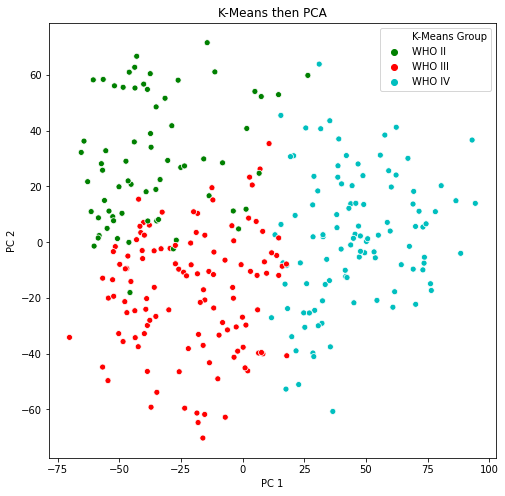

In [42]:
x = kmeans_train['PC 1']
y = kmeans_train['PC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = kmeans_train['K-Means Group'], palette = ['g', 'r', 'c'], hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("K-Means then PCA")
plt.show()

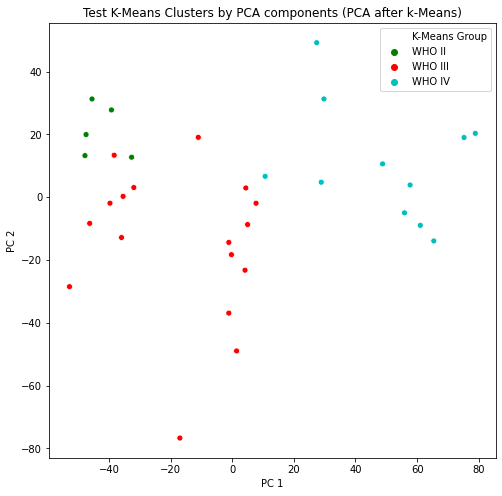

In [43]:
x = kmeans_test['PC 1']
y = kmeans_test['PC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = kmeans_test['K-Means Group'], palette = ['g', 'r', 'c'], hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("Test K-Means Clusters by PCA components (PCA after k-Means)")
plt.show()

### Compare Clusters to Grades

#### Visually

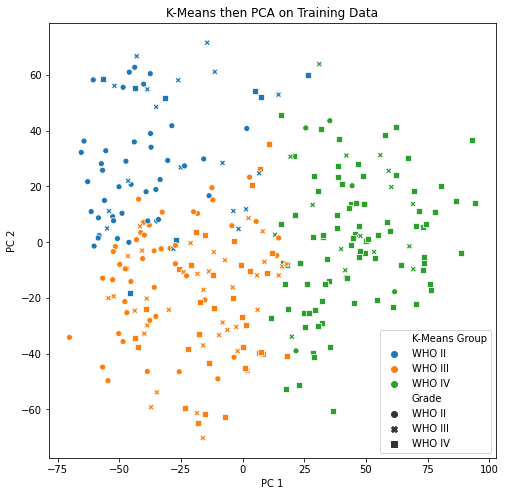

In [44]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'K-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = kmeans_train)
# edges = pca_kmeans_train.replace({'K-Means Group' : {'WHO II': 'black', "WHO III": 'gold', "WHO IV": 'magenta'}})
# sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'Grade',  
              #  edgecolor = edges['K-Means Group'], data = pca_kmeans_train)
plt.title("K-Means then PCA on Training Data")
plt.show()

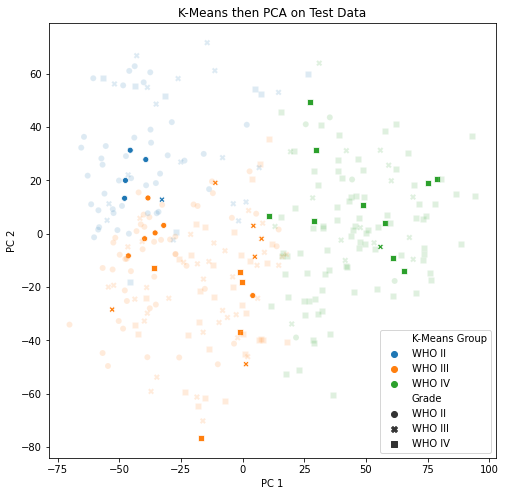

In [45]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'K-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = kmeans_test)
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'K-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = kmeans_train, alpha = .15, legend = False)
# edges = pca_kmeans_train.replace({'K-Means Group' : {'WHO II': 'black', "WHO III": 'gold', "WHO IV": 'magenta'}})
# sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'Grade',  
              #  edgecolor = edges['K-Means Group'], data = pca_kmeans_train)
plt.title("K-Means then PCA on Test Data")
plt.show()

#### Accuracy score

In [46]:
get_accuracy(kmeans_train['Grade'], kmeans_train['K-Means Group'])

0.5616438356164384

In [47]:
get_accuracy(kmeans_test['Grade'], kmeans_test['K-Means Group'])

0.6060606060606061

## On 100 PCs

### Implement

In [0]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)

kmeans.fit(pca_train_genes)
test_pred = kmeans.predict(pca_test_genes)

In [49]:
pca_kmeans_test = pd.concat([pd.DataFrame(pca_test_genes), pd.DataFrame(test_pred), pd.DataFrame(test_lbl)], axis = 1)

col_titles = [f'PC {x}' for x in range(1, 103)]
col_titles[-2:] = ['K-Means Group', 'Grade']
pca_kmeans_test.columns = col_titles

pca_kmeans_test = pca_kmeans_test.replace({'K-Means Group': {0:'WHO III', 1:'WHO IV', 2:'WHO II'}})

pca_kmeans_test.head()

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,PC 11,PC 12,PC 13,PC 14,PC 15,PC 16,PC 17,PC 18,PC 19,PC 20,PC 21,PC 22,PC 23,PC 24,PC 25,PC 26,PC 27,PC 28,PC 29,PC 30,PC 31,PC 32,PC 33,PC 34,PC 35,PC 36,PC 37,PC 38,PC 39,PC 40,...,PC 63,PC 64,PC 65,PC 66,PC 67,PC 68,PC 69,PC 70,PC 71,PC 72,PC 73,PC 74,PC 75,PC 76,PC 77,PC 78,PC 79,PC 80,PC 81,PC 82,PC 83,PC 84,PC 85,PC 86,PC 87,PC 88,PC 89,PC 90,PC 91,PC 92,PC 93,PC 94,PC 95,PC 96,PC 97,PC 98,PC 99,PC 100,K-Means Group,Grade
0,-17.018512,-76.678514,15.561575,3.062705,-7.722775,-8.775855,-4.664845,23.154769,0.509306,7.973493,-3.623431,5.865838,-4.550082,12.146977,-1.392681,-18.247655,6.898328,0.944234,11.385726,6.992770,12.331238,11.713086,0.710077,2.287172,-13.372765,6.968041,-10.298332,8.281167,-2.427184,-1.382116,-4.428495,1.189871,9.345460,11.165574,8.224162,0.316288,-5.162597,6.389885,9.948396,-1.074746,...,-3.197128,-0.143310,-1.270086,7.528369,2.055503,-5.333428,6.268508,0.078297,-3.276162,-0.453180,1.323430,-9.156285,8.630677,5.765287,6.622815,3.409527,-9.926912,-6.116751,5.465556,-0.973197,-3.731823,6.626961,-4.109379,-0.879745,0.127893,-3.803998,3.614193,0.048250,-2.899580,-1.551742,4.094361,-0.328319,-2.426534,3.283960,-4.978379,-2.093411,-4.246000,1.392405,WHO III,WHO IV
1,10.671509,6.637014,61.410853,35.650646,23.106030,-2.143411,-25.585952,-1.896259,-3.161317,29.643123,20.772154,-8.631343,10.109134,-4.321388,-1.290504,12.302256,5.606665,10.250756,-11.291593,8.424251,-7.446641,0.821122,6.364189,-1.287883,-0.528536,-2.792364,-0.898207,3.480841,13.059164,9.267527,-0.347305,-0.757466,9.309101,-10.087992,-1.771065,-4.107091,1.861269,-1.857201,0.604133,4.200106,...,1.809971,-2.988788,0.647669,2.470109,-2.665681,-1.667134,5.049326,5.713522,-2.427822,-3.809754,3.298483,2.034078,1.610837,-2.650715,0.027485,1.787696,2.078637,-2.181849,-0.176825,3.988677,0.841327,0.843844,-4.294727,-2.569276,-3.677456,2.771831,3.985848,1.352749,-4.459143,-4.306666,-0.474310,0.815713,1.557357,-0.717527,-3.843549,-2.087681,3.733449,0.008205,WHO IV,WHO IV
2,-47.478944,19.938839,0.775281,-5.393338,1.060001,-1.258295,18.845096,10.749328,8.432678,-1.510646,2.499019,2.215205,-3.571154,5.633107,3.777485,3.711312,-0.019695,-0.570238,-3.033789,4.688640,9.407064,-0.977668,-0.793261,0.618236,-4.136842,8.104762,1.443780,2.798849,-0.375756,-5.154681,-0.702524,3.024305,7.074151,6.507438,-4.232588,-4.472853,2.409570,-2.027083,-0.704039,5.608382,...,1.095985,-0.129219,-2.472738,1.127178,-3.152503,-0.426621,-2.651263,-2.184907,1.679962,-0.023509,1.857405,0.330693,-0.111450,-1.890244,3.137612,2.764058,-3.171187,0.351696,1.795306,-3.253062,0.999530,1.235816,0.087417,-0.315057,-2.167105,-2.291935,-2.714354,0.613106,0.767404,1.055777,-0.316400,0.281573,0.362711,-0.987278,2.479443,1.605464,-1.518974,0.128048,WHO II,WHO II
3,-46.293701,-8.338783,-8.556460,-11.787487,7.931988,-12.844719,6.540818,-18.449527,8.280566,2.268330,6.155864,6.697970,12.439044,-3.760193,3.322000,1.446556,-10.136128,-5.682184,-2.643613,3.815846,-2.070176,7.834681,-0.858004,-0.564004,-3.170614,-0.353465,-2.031324,3.339676,-3.248661,3.050186,3.204771,-0.560890,0.363286,3.926756,-1.125296,-1.214816,-0.560080,1.225001,-1.566592,0.479275,...,2.890916,-0.705937,-0.002263,0.538249,0.925144,-0.943887,-0.997912,-0.542422,-0.795057,1.968297,3.123509,0.191454,0.629973,-0.802764,1.378244,1.614012,0.906229,2.049833,-0.569304,0.790234,-0.425043,-2.275452,1.844780,1.288615,-0.603150,0.371771,1.635540,-0.873952,1.444501,-1.680922,-0.551190,-0.391136,-0.765349,0.254669,2.381193,0.293890,-1.085323,-0.797865,WHO II,WHO II
4,-39.708933,-1.918164,-1.080752,-5.932954,7.909139,-28.034350,4.023441,-14.541410,18.140569,-0.283968,4.532058,6.897554,6.876141,-6.633340,1.865254,2.966991,-10.198865,1.619051,-1.489895,2.532259,4.959692,6.446161,-2.915481,-0.140089,-4.472868,4.331271,-2.180906,0.614712,-1.106064,-1.564332,-3.963458,-4.127570,-1.506200,0.807357,-1.416793,-0.039085,0.160181,-0.614034,1.396443,-0.092935,...,2.369309,0.646424,-1.479211,0.584148,2.040954,-0

In [50]:
pca_kmeans_train = pd.concat([pd.DataFrame(pca_train_genes), pd.DataFrame(kmeans.labels_), 
                              pd.DataFrame(train_lbl)], axis = 1)

col_titles = [f'PC {x}' for x in range(1, 103)]
col_titles[-2:] = ['K-Means Group', 'Grade']
pca_kmeans_train.columns = col_titles

pca_kmeans_train = pca_kmeans_train.replace({'K-Means Group': {0:'WHO III', 1:'WHO IV', 2:'WHO II'}})

pca_kmeans_train.head()

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,PC 11,PC 12,PC 13,PC 14,PC 15,PC 16,PC 17,PC 18,PC 19,PC 20,PC 21,PC 22,PC 23,PC 24,PC 25,PC 26,PC 27,PC 28,PC 29,PC 30,PC 31,PC 32,PC 33,PC 34,PC 35,PC 36,PC 37,PC 38,PC 39,PC 40,...,PC 63,PC 64,PC 65,PC 66,PC 67,PC 68,PC 69,PC 70,PC 71,PC 72,PC 73,PC 74,PC 75,PC 76,PC 77,PC 78,PC 79,PC 80,PC 81,PC 82,PC 83,PC 84,PC 85,PC 86,PC 87,PC 88,PC 89,PC 90,PC 91,PC 92,PC 93,PC 94,PC 95,PC 96,PC 97,PC 98,PC 99,PC 100,K-Means Group,Grade
0,-33.435050,22.490684,38.097767,33.143324,-17.619484,-3.171189,20.422848,-43.082417,-8.627835,-40.189724,-5.465844,12.660643,6.474901,1.849231,17.776083,3.826548,5.573438,-7.040284,5.135255,-1.664143,-6.166108,4.009497,-1.826724,9.007044,6.159015,-7.805794,-4.325186,1.482421,-4.201913,4.000561,3.878437,-5.415432,-7.375138,-0.160841,-0.510255,2.192920,-2.173354,0.006804,-1.058477,-3.204084,...,5.008607,4.860570,4.643102,-0.535064,3.778756,0.622315,-2.530857,4.880558,1.727614,2.745107,4.730745,-1.841157,-0.922712,-2.406000,3.271590,5.472156,-3.876619,-1.981077,0.952377,-0.021147,1.547086,1.605269,4.035455,-1.445632,2.115250,5.634296,5.456446,0.133883,-1.037756,-1.739495,-0.737192,1.721679,-2.759915,2.641812,6.675747,-5.530448,2.266418,4.370240,WHO II,WHO II
1,23.423648,-7.423201,-17.507606,8.792664,6.431291,18.670121,9.897023,4.258872,-5.588874,-21.095125,-0.321909,0.209251,0.053999,-8.668732,0.180358,-4.388500,-2.999501,16.385283,-4.155462,-6.636527,-1.222793,-4.239253,5.987897,2.546961,-3.713511,1.623914,11.720301,4.274339,6.207523,2.401989,4.092058,-1.791507,-5.777590,-3.696712,6.245213,-4.232292,2.452928,-8.434929,10.449914,-0.615956,...,-0.177286,5.996773,-4.823631,-2.647002,-9.367976,-10.885565,-8.859610,1.501207,-6.202868,2.906427,-1.303148,5.989333,0.385217,-0.763037,-3.998872,4.238178,-2.304791,2.287783,-3.320622,-2.134242,7.699306,-10.091441,4.306083,8.596004,5.962502,1.032129,-7.437804,1.079408,4.134540,1.039711,4.062908,-4.534138,-4.315585,-1.729684,2.638636,0.672170,2.707216,-2.451562,WHO IV,WHO IV
2,-40.110197,7.114938,26.472899,-2.714789,2.348760,10.846684,24.951122,-15.587004,-12.524130,-13.831128,-8.257988,3.049685,-0.538335,4.341137,2.305903,13.010602,2.595942,-4.470677,-2.298029,17.880752,8.246806,7.951111,7.983959,4.172903,-6.476397,6.306320,-5.137204,0.316387,-6.379483,-3.291119,-3.082158,2.749579,4.906964,5.152140,-1.855474,-0.824835,-5.212199,-0.619580,-0.234999,2.049923,...,4.424833,0.820835,-5.940682,1.485920,-0.638603,-1.068303,-0.719452,-1.932281,-0.022624,-2.848085,0.989540,-2.472028,-1.842685,-7.521721,-0.533741,1.000672,-0.399758,-2.406002,-1.631125,-2.001025,-0.436460,-2.966490,0.405604,-1.663369,-4.180945,2.441507,2.205418,-1.501229,-7.001969,-1.207149,0.160861,-0.084642,-0.494133,4.142929,1.720335,0.097721,1.767304,-1.775615,WHO II,WHO II
3,-4.322818,5.918644,3.995310,-19.628973,-7.751300,-32.174274,-13.651554,2.071610,15.121478,-6.344321,-5.886538,0.644106,14.281353,-13.589629,9.364735,4.462571,-8.259393,2.416554,8.725246,0.637509,6.550074,2.068744,-4.283571,-0.981149,4.214905,1.755215,-3.518319,1.838896,7.655245,-3.166945,-6.106775,0.376025,-2.966488,-3.766382,-1.383230,-4.179557,-7.832833,-2.305416,3.079826,5.916520,...,2.708370,0.059107,0.979330,-0.170404,5.636206,3.116163,-4.319594,-2.107568,-2.268727,-1.356017,1.838254,-2.516068,-0.840261,2.778595,-5.101432,0.086985,4.971005,3.675710,-2.676070,2.651018,-0.397403,-0.418024,2.366223,-3.909779,-3.999657,1.217934,3.429463,-0.535684,-0.427905,-2.719327,-6.443787,0.926428,-3.243689,-0.012364,-1.114525,1.036728,-1.833460,4.305802,WHO III,WHO II
4,-32.589107,10.796249,10.908327,-21.124218,-3.384022,1.144420,17.386548,-5.382829,19.263883,8.949041,2.557392,6.291835,-4.473040,8.318883,-10.763494,0.588640,-2.126829,-7.916746,-0.148645,-3.248871,-7.025282,-4.662379,1.824813,1.262275,1.846083,-0.825017,-4.342887,-1.906904,7.044814,-4.714351,4.018129,5.869568,3.870139,7.186362,-0.670991,0.010142,-2.045424,0.002795,5.167696,-1.381443,...,-1.502334,1.260479,-0.364275,-2.770996,-2.

### Plot Clusters


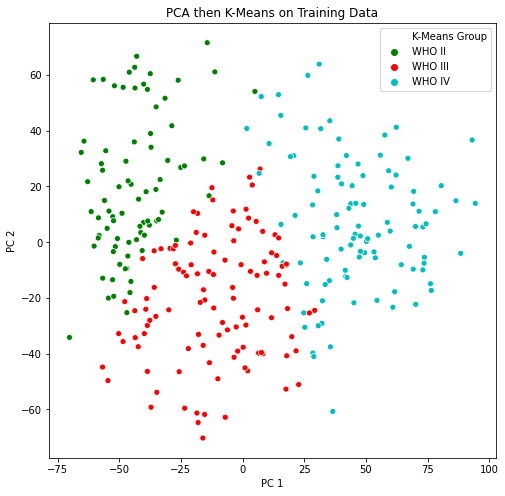

In [51]:
x = pca_kmeans_train['PC 1']
y = pca_kmeans_train['PC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = pca_kmeans_train['K-Means Group'], palette = ['g', 'r', 'c'], hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("PCA then K-Means on Training Data")
plt.show()

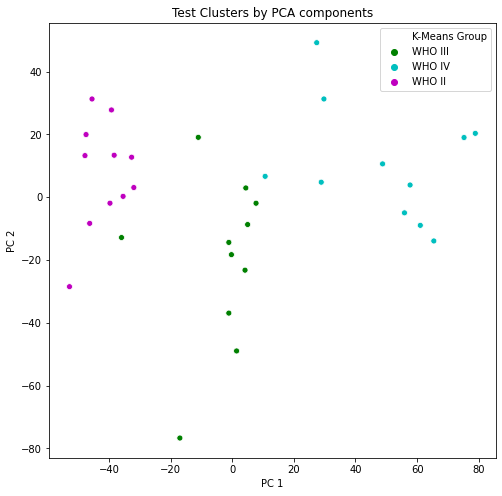

In [52]:
x = pca_kmeans_test['PC 1']
y = pca_kmeans_test['PC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = pca_kmeans_test['K-Means Group'], palette = ['g', 'c','m'])
plt.title("Test Clusters by PCA components")
plt.show()

### Compare Clusters to Grades

#### Visually

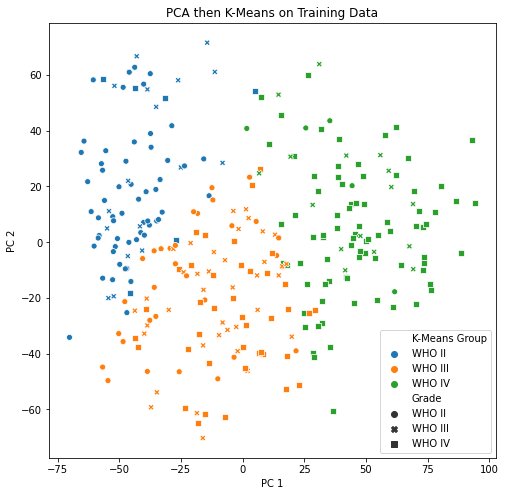

In [53]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'K-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = pca_kmeans_train)
plt.title("PCA then K-Means on Training Data")
plt.show()

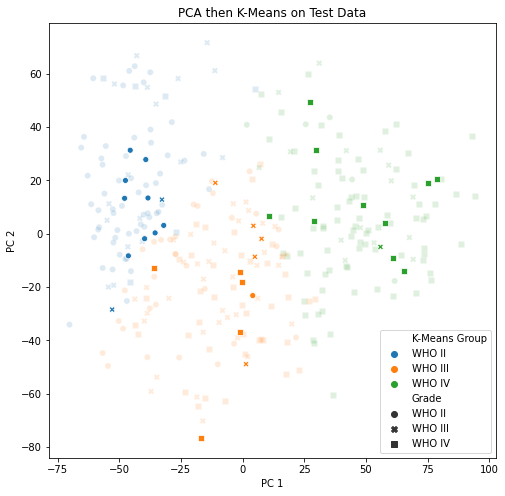

In [54]:
plt.figure(figsize = (8,8))
# edges = pca_kmeans_test.replace({'K-Means Group' : {'WHO II': 'blue', "WHO III": 'red', "WHO IV": 'black'}})
# sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'Grade',  
#                edgecolor = edges['K-Means Group'], data = pca_kmeans_test)

# edges = pca_kmeans_train.replace({'K-Means Group' : {'WHO II': 'blue', "WHO III": 'red', "WHO IV": 'black'}})
# sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'Grade', data = pca_kmeans_train, alpha = .15, legend = False)
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'K-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = pca_kmeans_train, alpha = .15)
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'K-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = pca_kmeans_test, legend = False)
plt.title("PCA then K-Means on Test Data")
plt.show()

#### Accuracy score

In [55]:
get_accuracy(pca_kmeans_train['Grade'], pca_kmeans_train['K-Means Group'])

0.6027397260273972

In [56]:
get_accuracy(pca_kmeans_test['Grade'], pca_kmeans_test['K-Means Group'])

0.7272727272727273

## On genes identified by PCA

### Implement

In [0]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)

kmeans.fit(important_train)
test_pred = kmeans.predict(important_test)

In [178]:
top_kmeans_test = pd.concat([pd.DataFrame(important_test), pd.DataFrame(test_pred), pd.DataFrame(test_lbl)], axis = 1)

col_titles[:-2] = important_train.columns.values
col_titles[-2:] = ['K-Means Group', 'Grade']
top_kmeans_test.columns = col_titles

top_kmeans_test = top_kmeans_test.replace({'K-Means Group': {0:'WHO III', 1:'WHO IV', 2:'WHO II'}})

top_kmeans_test.head()

,10001,10013,10016,10023,10031,10037,10041,10044,10049,10050,10052,10054,10060,10069,10070,10072,10073,10076,10080,10084,10108,10111,10112,10121,10124,10125,10127,10129,10131,10135,10136,10151,10156,10163,10165,10173,10176,1018,10185,1019,...,9762,9765,9766,9779,978,9787,979,9790,9805,9815,982,9821,9822,9826,9837,9843,9855,9856,9858,9867,9868,9869,9874,9889,989,9896,9897,9903,9909,9910,9917,9930,9948,9955,9959,9962,9963,9985,K-Means Group,Grade
0,3.932932,0.043894,0.614781,3.613602,2.910062,2.328937,0.927249,-0.555144,2.972103,-0.998751,3.280720,0.586212,3.662315,4.052621,-1.835252,5.922257,4.101386,5.566846,1.276256,1.043894,-3.320679,0.824999,3.581395,0.507140,5.927960,1.323177,1.652014,0.633517,3.958235,-2.835252,5.290715,4.035993,2.428855,-0.711870,-1.119045,1.390816,3.040388,5.020506,3.008445,4.062161,...,1.674806,1.050880,3.795145,-1.357205,-1.433154,0.000000,4.986750,1.043894,0.979445,-1.688411,0.714945,-1.119045,2.071638,2.955445,-2.394680,-3.320679,3.536058,2.672543,2.911982,1.340387,0.202883,-0.998751,1.919635,0.904287,2.075069,3.528570,-0.534083,-0.199664,-1.835252,1.938594,2.745410,-0.555144,1.537302,5.011581,2.331808,0.783658,1.015604,-3.472682,WHO III,WHO IV
1,4.391580,-0.125221,1.736499,1.679916,3.998288,3.212137,1.224363,4.943412,4.940173,1.464903,1.574025,-1.020524,2.385468,3.285447,5.840439,4.911632,5.343698,4.844405,3.166927,1.831475,-0.188647,1.500527,0.335620,-0.963940,4.908320,2.090507,2.751362,2.097171,4.679361,1.924334,1.693172,1.897862,2.657548,0.630241,2.221316,-1.494455,0.464903,6.893323,3.401709,4.921991,...,0.369043,1.894041,2.585918,4.396991,3.519255,0.380014,4.125968,1.583547,1.510546,-0.687100,1.823460,4.560225,3.283987,1.423083,-1.454927,-0.172527,3.782703,3.751362,4.048147,2.859182,0.077087,-1.140818,2.090507,4.065241,2.992045,3.558415,1.807295,4.962698,-1.664380,1.648503,3.725789,0.433652,3.173248,4.264878,0.401709,-1.909493,2.404398,2.537744,WHO IV,WHO IV
2,6.991915,2.270290,2.962168,3.799381,2.994872,3.342440,1.721853,-1.725606,4.415805,0.369552,2.058137,-0.302394,1.480299,0.792243,4.124439,5.445685,6.207817,4.902425,0.100365,0.994872,-0.327056,2.515402,4.072350,1.215842,6.518217,4.477631,5.121024,2.977354,4.745700,-0.975584,5.360892,2.330662,4.072350,2.185650,2.159259,0.515402,1.487388,3.726355,4.074706,4.480299,...,2.145880,2.062890,1.691480,1.999838,3.511930,0.241227,4.649434,2.034131,1.715829,0.136891,0.369552,2.081749,3.200825,3.420442,1.314809,2.754542,5.292721,6.956591,6.093122,4.670610,1.666712,0.487388,2.599598,4.060515,4.408354,5.084089,-1.230841,0.043781,2.181285,1.536062,5.347319,2.515402,0.709780,-3.377682,2.294743,-1.327056,3.941667,1.072350,WHO II,WHO II
3,5.480287,1.175103,2.124581,3.006455,2.686167,2.734530,1.445904,0.899161,4.347621,1.109378,2.306220,-0.363874,0.584287,1.340478,0.811698,5.190715,5.586485,5.251183,-0.143908,1.469909,0.046914,3.738488,2.732547,0.968202,4.144853,2.794691,2.215420,1.215420,3.142615,0.034090,3.574357,3.078484,3.773630,1.133626,-0.234106,0.994920,1.562126,2.669679,4.337219,3.599600,...,1.484123,1.694341,1.249103,0.877787,2.783241,-0.234106,4.264969,0.180932,1.909730,-0.313833,1.661364,0.292825,1.909730,2.932368,-1.281412,-0.234106,4.954230,6.477626,5.833603,4.471099,1.584287,-0.173352,2.548663,3.759091,3.269763,4.452545,-0.234106,-0.750897,0.892071,2.421492,5.412540,2.163373,-1.487862,-1.415713,2.366287,1.072225,2.327398,-0.143908,WHO II,WHO II
4,6.272283,1.441327,2.268776,3.256902,3.015759,2.898372,1.650922,1.865516,3.858658,1.557208,2.343664,0.507964,0.704361,1.884933,2.382433,5.267667,5.883727,4.858167,0.877198,1.609502,0.024540,3.546273,3.319606,1.349266,5.942129,2.855708,3.346468,2.349266,4.059138,0.829892,4.676775,2.621127,3.795420,1.360407,0.268776,1.482697,1.145394,3.151820,4.273204,3.504202,...,1.717417,1.825879,2.430796,1.926754,2.564451,-2.340033,4.375586,0.244930,1.941665,2.072749,2.099590,2.003375,2.289324,3.047123,-0.219018,-0.340033,5.417857,7.135397,6.055073,4.844842,1.497910,0.517948,2.537711,3.404128,3.753781,4.890228,1.632660,

In [179]:
top_kmeans_train = pd.concat([pd.DataFrame(important_train), pd.DataFrame(kmeans.labels_), pd.DataFrame(train_lbl)], axis = 1)

col_titles[:-2] = important_train.columns.values
col_titles[-2:] = ['K-Means Group', 'Grade']
top_kmeans_train.columns = col_titles

top_kmeans_train = top_kmeans_train.replace({'K-Means Group': {0:'WHO III', 1:'WHO IV', 2:'WHO II'}})

top_kmeans_train.head()

,10001,10013,10016,10023,10031,10037,10041,10044,10049,10050,10052,10054,10060,10069,10070,10072,10073,10076,10080,10084,10108,10111,10112,10121,10124,10125,10127,10129,10131,10135,10136,10151,10156,10163,10165,10173,10176,1018,10185,1019,...,9762,9765,9766,9779,978,9787,979,9790,9805,9815,982,9821,9822,9826,9837,9843,9855,9856,9858,9867,9868,9869,9874,9889,989,9896,9897,9903,9909,9910,9917,9930,9948,9955,9959,9962,9963,9985,K-Means Group,Grade
0,5.727900,0.792760,2.373641,2.377722,3.707778,3.094992,2.049668,1.743007,5.635909,1.090026,1.840854,-1.389444,0.976206,0.921344,0.875901,4.718276,4.286242,5.225832,0.080042,1.792760,0.638037,2.510029,2.539473,1.008149,4.442473,3.521141,3.391916,2.034238,3.039400,-0.135687,3.379758,3.619200,4.047108,1.080042,0.691476,2.114688,0.336381,3.544928,3.803418,2.707778,...,2.276439,3.160415,1.723898,1.780481,3.596617,1.267669,4.637186,1.926925,3.746167,0.638037,1.828980,0.954511,1.915741,2.069988,-0.089883,1.786634,5.611856,6.871566,5.761866,5.026461,0.898801,-2.389444,3.190887,4.551265,3.092511,3.671668,0.099941,0.039400,0.539473,2.340569,5.395946,3.918545,-1.630452,-1.135687,1.369548,-0.045489,4.937331,-0.207240,WHO II,WHO II
1,5.279606,0.756814,2.460654,2.332898,1.373870,1.752382,2.055544,-1.421989,3.046522,-0.977205,1.396770,-0.891475,2.725498,1.859297,-1.733933,3.843756,5.592961,4.442197,-0.382461,2.996800,0.302903,1.176270,3.460654,0.765638,4.252791,4.062722,2.308952,1.000543,5.857234,0.791790,4.449745,3.581763,3.746822,3.508748,0.842714,-0.919489,3.231453,6.903441,3.409494,4.508748,...,1.108525,-0.006952,2.941415,2.681881,3.231453,0.817477,5.297970,0.278450,0.851029,-0.052756,1.247289,-2.006952,2.218657,0.240976,0.597910,1.506118,5.535758,3.071644,3.953050,2.208986,0.907932,0.506118,3.438753,5.088445,3.595438,2.776592,-0.288134,0.385366,0.022795,0.350600,4.791790,1.587995,-0.022059,3.918850,2.350600,-0.661177,2.471481,-0.919489,WHO IV,WHO IV
2,5.540728,0.753983,1.214345,2.254677,2.345751,2.114278,1.408848,-0.502925,4.545908,0.395792,0.591712,-1.926137,1.023823,0.395792,0.647855,4.660192,4.484797,5.429014,-1.137641,-0.408288,0.023823,3.769250,3.764179,0.945349,6.180962,2.804256,5.353369,3.184287,4.189025,-2.215643,5.635065,2.904451,3.909053,0.814104,-0.604208,2.053224,0.545169,3.862359,4.314872,3.707189,...,1.614432,3.055301,1.375983,0.369319,3.212484,-0.830979,4.776194,1.753983,3.013176,-0.028016,0.434611,1.369319,1.428213,3.023823,0.199394,-1.298105,6.191389,6.202678,5.213415,4.590280,0.355899,-0.830979,3.155528,4.083056,4.128159,4.121235,-1.741712,-1.100166,0.701895,1.733373,5.544430,1.032284,0.591712,3.349141,2.082037,-0.959303,3.699240,-0.630681,WHO II,WHO II
3,5.700313,1.487249,2.197211,1.732660,2.998713,2.623883,0.870896,1.463163,3.418769,0.892700,2.883655,0.293238,0.956203,2.406191,1.784119,5.584792,5.853629,4.108379,0.716449,1.687636,0.552625,0.748690,2.200129,1.728624,5.439286,3.002061,3.478864,3.040007,5.045695,1.113030,4.477663,2.728624,3.925682,0.928324,-0.136446,0.561727,1.062625,4.431238,3.898100,4.415007,...,1.799591,0.658235,3.117666,0.314933,3.030204,0.131487,5.002896,1.049744,1.352132,1.788003,2.730643,1.069023,2.052975,3.065827,-0.918266,-0.393604,5.432789,3.584234,4.786062,4.615712,1.845034,-0.050716,2.211740,4.211017,5.632548,4.516801,1.293238,0.398591,-0.581231,2.091194,6.104686,0.534246,-0.685067,4.143662,1.610788,1.520307,2.545760,-0.341765,WHO III,WHO II
4,5.865440,2.211946,2.148170,4.633306,3.365313,2.743960,0.880237,-0.169688,4.270216,0.280477,2.405078,0.072882,0.789089,-0.231973,1.196264,5.531533,6.476604,5.124026,-0.461454,0.669249,-1.412545,1.928492,3.492742,1.581431,4.553239,2.418657,4.379269,3.746654,4.511080,-0.591515,4.557849,3.465199,4.336989,1.855490,0.487919,-0.052649,2.569308,3.996846,4.044699,4.456998,...,2.768027,2.077169,1.713988,1.196264,3.319000,-0.538076,4.713299,1.820116,2.219723,-0.675579,0.381004,-1.149510,1.860474,2.688993,-0.342156,-3.997507,4.649951,7.126743,3.597937,4.340560,2.381004,1.242807,2.842956,3.156298,4.676332,4.705704,-1.071508

### Plot clusters

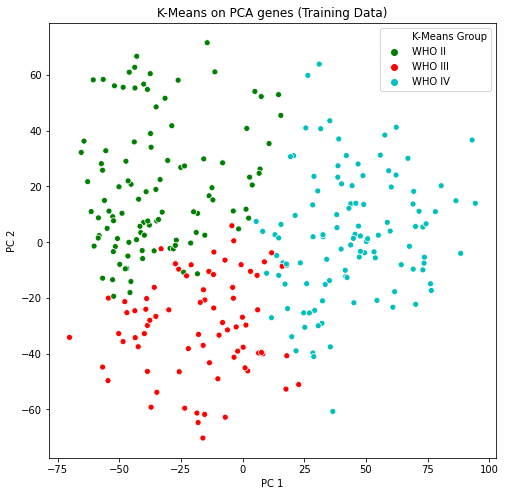

In [180]:
x = pca_kmeans_train['PC 1']
y = pca_kmeans_train['PC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = top_kmeans_train['K-Means Group'], palette = ['g', 'r', 'c'], hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("K-Means on PCA genes (Training Data)")
plt.show()

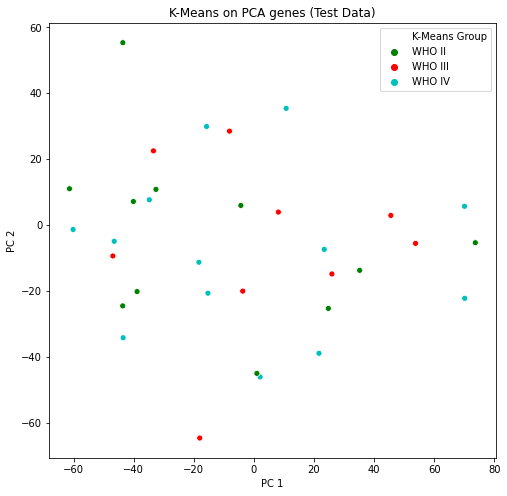

In [181]:
x = pca_kmeans_train['PC 1']
y = pca_kmeans_train['PC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = top_kmeans_test['K-Means Group'], palette = ['g', 'r', 'c'], hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("K-Means on PCA genes (Test Data)")
plt.show()

### Compare Clusters to Grades

#### Accuracy Score

In [182]:
get_accuracy(top_kmeans_train['Grade'], top_kmeans_train['K-Means Group'])

0.6027397260273972

In [183]:
get_accuracy(top_kmeans_test['Grade'], top_kmeans_test['K-Means Group'])

0.6666666666666666

## On 100 Factors

### Implement

In [0]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)

kmeans.fit(fa_train_genes)
test_pred = kmeans.predict(fa_test_genes)

In [65]:
fa_kmeans_test = pd.concat([pd.DataFrame(fa_test), pd.DataFrame(test_pred)], axis = 1)

col_titles[:-2] = fa_train.columns.values[:-1]
col_titles[-2:] = ['Grade', 'K-Means Group']
fa_kmeans_test.columns = col_titles

fa_kmeans_test = fa_kmeans_test.replace({'K-Means Group': {2:'WHO III', 0:'WHO IV', 1:'WHO II'}})

fa_kmeans_test.head()

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9,Factor 10,Factor 11,Factor 12,Factor 13,Factor 14,Factor 15,Factor 16,Factor 17,Factor 18,Factor 19,Factor 20,Factor 21,Factor 22,Factor 23,Factor 24,Factor 25,Factor 26,Factor 27,Factor 28,Factor 29,Factor 30,Factor 31,Factor 32,Factor 33,Factor 34,Factor 35,Factor 36,Factor 37,Factor 38,Factor 39,Factor 40,...,Factor 63,Factor 64,Factor 65,Factor 66,Factor 67,Factor 68,Factor 69,Factor 70,Factor 71,Factor 72,Factor 73,Factor 74,Factor 75,Factor 76,Factor 77,Factor 78,Factor 79,Factor 80,Factor 81,Factor 82,Factor 83,Factor 84,Factor 85,Factor 86,Factor 87,Factor 88,Factor 89,Factor 90,Factor 91,Factor 92,Factor 93,Factor 94,Factor 95,Factor 96,Factor 97,Factor 98,Factor 99,Factor 100,Grade,K-Means Group
0,-0.293440,2.538886,-0.681511,0.568800,-0.486379,-0.779511,0.319821,1.345924,-0.322250,-1.543843,0.583401,1.232805,1.015854,0.371118,0.726277,-1.793935,0.595507,1.381473,0.146248,-0.627867,1.816056,-1.514732,1.279376,-0.541915,-0.503033,0.677510,-2.602009,0.990409,-1.203804,-1.624827,1.442395,0.003285,-0.806711,-2.130532,-0.922185,1.211113,0.675092,0.930663,-0.030370,0.327993,...,0.181058,1.941298,-2.222015,-0.918663,-1.127551,0.955807,-0.755799,0.019922,3.750914,-0.136771,2.480472,1.341996,1.514001,-1.479348,-2.774186,2.167005,1.845020,-0.688455,-1.843069,-0.394638,2.116943,-0.407150,0.818184,-0.816016,0.064942,0.986092,0.205071,1.520231,-0.337685,-1.020581,-0.319427,-2.768241,0.609570,0.387526,-0.541136,0.203349,0.843216,-0.207020,WHO IV,WHO II
1,0.324620,0.320905,-0.001379,3.038895,1.789471,0.165920,-2.021166,-1.015364,0.394811,-2.838859,-0.892280,-2.068333,0.330254,0.075194,-0.361176,0.709951,1.915603,-1.290557,-0.529883,1.427255,-0.678221,0.282330,0.281810,0.989438,0.133487,-0.813798,0.024551,1.098699,1.331911,-0.247413,1.089651,1.520390,2.552489,0.659972,0.443962,-1.244502,-0.129881,-0.534517,-0.642364,-0.998721,...,-1.190419,0.839269,-0.432565,-0.610082,0.100808,-0.780341,-1.514881,0.213097,0.493203,-1.221235,0.915697,0.513288,0.614149,-0.283112,0.548249,-0.632030,1.084227,0.111545,1.039633,-0.012621,0.441137,0.886790,-0.718504,-1.305706,0.202242,-0.760016,1.094748,-0.414678,0.618624,-0.250067,-0.622165,-0.176920,1.646883,-1.226587,0.509953,0.791242,-0.390949,-0.668325,WHO IV,WHO II
2,-1.149085,-0.725466,-0.161190,0.100292,-0.135751,0.447639,1.397324,0.732199,0.198626,-0.174552,0.252575,0.098434,-0.201954,1.109297,-0.362313,0.611463,0.252529,-0.328643,0.187580,-0.351575,1.453071,-0.282818,0.086284,-0.131108,-0.075098,0.546457,-0.347318,0.404466,0.175415,-0.935541,0.697452,0.543868,-1.326968,-0.798311,0.110845,-1.492511,-0.294801,0.442117,-0.170704,-1.192030,...,-0.183156,-0.440594,0.938233,-0.046092,-0.661072,0.329273,-0.586578,0.515794,-0.039014,0.324517,0.114069,-0.110840,0.209480,-0.006129,-0.641516,0.481802,0.213864,0.377849,0.004588,-0.405983,-0.021938,1.210337,0.795871,-0.848095,0.590221,0.391976,-0.268752,-0.157662,-0.176234,0.056113,-0.188803,-0.267155,0.447616,-0.704491,0.614786,0.263612,0.665294,-0.383083,WHO II,WHO II
3,-1.171114,0.380817,-0.509393,-0.778159,0.568190,0.228791,0.408663,-1.304155,0.910656,-0.400083,0.108526,-0.780755,-0.610037,-0.624102,-1.455385,0.215294,-1.350310,-0.298107,-0.909006,0.128485,-0.005939,-1.041672,0.504513,0.006271,0.233487,0.173494,-0.586015,0.290266,-0.825464,0.271224,0.395707,-0.256013,0.119838,-0.852398,0.395025,-0.068228,-0.552795,-0.170839,0.146349,-0.367205,...,0.171287,-0.204903,0.103397,-0.068474,0.006126,-0.111813,0.439918,0.409053,0.541837,-0.766683,-0.208610,0.150967,0.201722,0.477650,0.570681,-0.450848,-0.179122,-0.210300,-0.046033,-0.044556,-0.177725,-0.080124,-0.229516,0.140195,0.034021,0.122877,0.360044,0.347633,0.132775,0.123528,0.107490,0.339592,-0.311282,0.034030,-0.348044,0.098321,-0.154382,-0.752504,WHO II,WHO II
4,-0.999554,0.257892,-0.399793,-0.399037,0.653508,-0.356721,0.683092,-0.835377,2.041559,-0.493432,0.701805,-0.706554,-1.159834,-0.390775,-0.939134,0.467496,-0.002841

In [66]:
fa_kmeans_train = pd.concat([pd.DataFrame(fa_train), pd.DataFrame(kmeans.labels_)], axis = 1)

col_titles[:-2] = fa_train.columns.values[:-1]
col_titles[-2:] = ['Grade', 'K-Means Group']
fa_kmeans_train.columns = col_titles

fa_kmeans_train = fa_kmeans_train.replace({'K-Means Group': {2:'WHO III', 0:'WHO IV', 1:'WHO II'}})

fa_kmeans_train.head()

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9,Factor 10,Factor 11,Factor 12,Factor 13,Factor 14,Factor 15,Factor 16,Factor 17,Factor 18,Factor 19,Factor 20,Factor 21,Factor 22,Factor 23,Factor 24,Factor 25,Factor 26,Factor 27,Factor 28,Factor 29,Factor 30,Factor 31,Factor 32,Factor 33,Factor 34,Factor 35,Factor 36,Factor 37,Factor 38,Factor 39,Factor 40,...,Factor 63,Factor 64,Factor 65,Factor 66,Factor 67,Factor 68,Factor 69,Factor 70,Factor 71,Factor 72,Factor 73,Factor 74,Factor 75,Factor 76,Factor 77,Factor 78,Factor 79,Factor 80,Factor 81,Factor 82,Factor 83,Factor 84,Factor 85,Factor 86,Factor 87,Factor 88,Factor 89,Factor 90,Factor 91,Factor 92,Factor 93,Factor 94,Factor 95,Factor 96,Factor 97,Factor 98,Factor 99,Factor 100,Grade,K-Means Group
0,-0.767871,-0.385531,0.115836,2.388345,-0.383484,-0.467369,0.561467,-2.350664,0.418821,3.973832,1.393458,0.537795,-1.186955,0.241165,-2.461988,-0.384562,-0.998326,0.576849,1.282513,0.930144,-1.114290,-0.555400,0.582111,-1.286940,-0.756003,-0.851512,0.500168,-0.302530,-1.151444,1.133120,0.066960,-0.897220,0.713943,0.469944,0.523972,0.829169,-0.259754,0.334612,0.638612,0.837120,...,0.667772,-0.687835,-1.093906,0.663421,1.777082,0.403360,1.039033,0.014080,0.939824,-0.798166,-0.012489,-1.292066,-1.089388,0.435321,1.080004,-0.580681,0.193973,-0.696573,0.209947,1.181998,1.581319,0.001383,-0.257150,0.536074,0.311319,0.998915,-0.095354,2.095175,0.483481,0.344128,1.088099,-1.533397,0.904053,-0.544323,-2.056798,1.683718,-0.716638,-0.717733,WHO II,WHO II
1,0.539117,0.327107,0.852022,-0.332517,-0.004732,0.745542,0.420696,0.905649,-0.866477,1.996034,0.113299,-0.303487,-0.368289,-0.738100,-0.355224,-0.306828,1.579579,-0.624290,-0.943939,-0.140500,-0.371726,1.095854,-0.376742,-0.131920,1.156971,0.019174,0.526034,1.989616,1.022750,0.108739,-0.671821,-0.700076,0.210346,0.400768,-0.186391,-1.013761,1.210125,0.822048,-0.608654,0.412536,...,-1.716859,0.398347,0.363219,0.184676,-0.871169,2.087683,-2.375473,4.507718,0.359282,0.120722,-1.184790,-1.131110,0.596269,-1.417280,3.027256,-1.059554,-1.926482,-1.727431,0.575586,-1.020027,-0.035904,-0.445189,0.958550,1.122069,-1.147704,1.916830,0.175825,-1.755637,-0.108784,0.047249,-2.818945,2.346825,-2.154707,-0.128855,-1.230194,0.923162,-1.032598,0.883319,WHO IV,WHO II
2,-0.914146,-0.218124,-0.782675,1.019773,0.375657,0.519532,0.913710,-1.079186,-0.907992,1.785236,0.315228,0.503691,-0.523415,0.600933,-0.377421,1.659806,0.111216,-0.507630,0.373521,1.309040,2.158432,-0.649656,2.112633,-0.537144,-0.300375,0.304272,-1.232271,-0.303918,-0.466015,-0.998909,0.478124,0.124541,-0.578029,-0.843605,0.154575,0.143870,-0.867417,-0.063425,0.102344,-0.828719,...,-0.342601,-1.091383,0.584348,0.084750,-0.297700,0.573446,-0.372649,0.069827,-0.060793,0.694590,1.544628,1.004739,1.563913,-0.019049,0.554957,0.060621,-0.619902,0.381322,0.727567,-0.004370,-0.079075,1.533853,-0.318394,0.100634,-0.178083,-0.220553,0.727758,-1.449127,0.138948,0.788301,0.348312,0.520673,1.320611,-0.702829,-0.331891,-0.452675,-0.783852,-0.367775,WHO II,WHO II
3,-0.010240,-0.408593,-1.194213,-0.386557,0.003723,-1.695766,-0.276458,0.752302,1.858447,-0.038924,-0.494421,-0.505349,-1.804313,-0.779621,-1.425660,0.286663,0.260123,1.654794,-0.879751,-0.318515,0.663504,-0.573909,-0.654317,0.076841,-1.708391,-1.136160,-0.360114,0.521692,0.938267,-0.223938,-0.616241,-0.095428,-0.039779,1.251148,-0.454566,0.253899,-1.674527,0.542885,-0.161628,-0.132685,...,0.414760,-1.054944,-0.810270,0.392132,0.229581,-0.028218,1.044777,0.852055,-0.145478,0.086758,-0.776033,0.473123,0.725105,0.000560,0.576832,-0.573361,-0.678358,1.069336,-0.443874,1.552338,-0.308504,-0.923042,-1.355427,0.088791,0.648256,-0.374091,-0.184248,-0.618326,-0.348110,1.108395,-0.278188,-0.167396,-0.417089,-0.212686,0.996606,0.270324,0.030926,0.107322,WHO II,WHO II
4,-0.785148,-0.501948,-1.059175,-0.116568,-0.353897,1.322514,1.409249,-0.578670,0.985555,-0.809191,0.794120,0.010905,0.750028,0.052386,0.721943,0.340907,-1.095

### Plot clusters

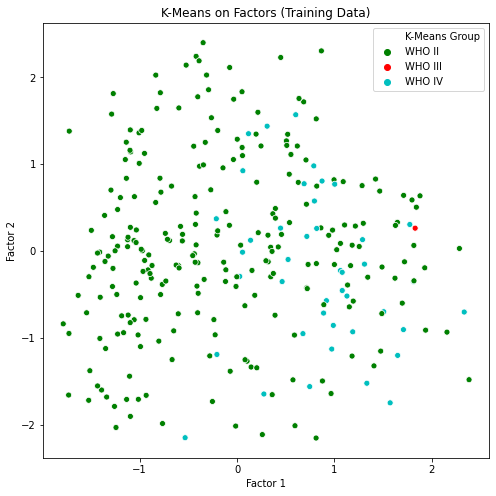

In [67]:
x = fa_kmeans_train['Factor 1']
y = fa_kmeans_train['Factor 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = fa_kmeans_train['K-Means Group'], palette = ['g', 'r', 'c'], hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("K-Means on Factors (Training Data)")
plt.show()

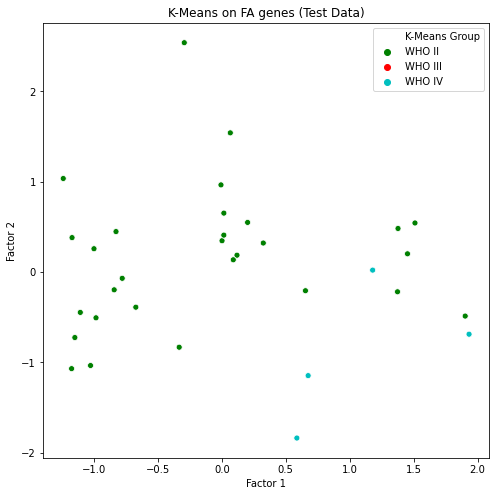

In [68]:
x = fa_kmeans_test['Factor 1']
y = fa_kmeans_test['Factor 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = fa_kmeans_test['K-Means Group'], palette = ['g', 'r', 'c'], hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("K-Means on FA genes (Test Data)")
plt.show()

### Compare Clusters to Grades

#### Accuracy Score

In [69]:
get_accuracy(fa_kmeans_train['Grade'], fa_kmeans_train['K-Means Group'])

0.4178082191780822

In [70]:
get_accuracy(fa_kmeans_test['Grade'], fa_kmeans_test['K-Means Group'])

0.42424242424242425

## On genes identified by Factor Analysis

### Implement

In [0]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)

kmeans.fit(fa_important_train)
test_pred = kmeans.predict(fa_important_test)

In [192]:
fa_top_kmeans_test = pd.concat([pd.DataFrame(fa_test), pd.DataFrame(test_pred)], axis = 1)

col_titles[:-2] = fa_train.columns.values[:-1]
col_titles[-2:] = ['Grade', 'K-Means Group']
fa_top_kmeans_test.columns = col_titles

fa_top_kmeans_test = fa_top_kmeans_test.replace({'K-Means Group': {0:'WHO III', 1:'WHO IV', 2:'WHO II'}})

fa_top_kmeans_test.head()

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9,Factor 10,Factor 11,Factor 12,Factor 13,Factor 14,Factor 15,Factor 16,Factor 17,Factor 18,Factor 19,Factor 20,Factor 21,Factor 22,Factor 23,Factor 24,Factor 25,Factor 26,Factor 27,Factor 28,Factor 29,Factor 30,Factor 31,Factor 32,Factor 33,Factor 34,Factor 35,Factor 36,Factor 37,Factor 38,Factor 39,Factor 40,...,Factor 63,Factor 64,Factor 65,Factor 66,Factor 67,Factor 68,Factor 69,Factor 70,Factor 71,Factor 72,Factor 73,Factor 74,Factor 75,Factor 76,Factor 77,Factor 78,Factor 79,Factor 80,Factor 81,Factor 82,Factor 83,Factor 84,Factor 85,Factor 86,Factor 87,Factor 88,Factor 89,Factor 90,Factor 91,Factor 92,Factor 93,Factor 94,Factor 95,Factor 96,Factor 97,Factor 98,Factor 99,Factor 100,Grade,K-Means Group
0,-0.293440,2.538886,-0.681511,0.568800,-0.486379,-0.779511,0.319821,1.345924,-0.322250,-1.543843,0.583401,1.232805,1.015854,0.371118,0.726277,-1.793935,0.595507,1.381473,0.146248,-0.627867,1.816056,-1.514732,1.279376,-0.541915,-0.503033,0.677510,-2.602009,0.990409,-1.203804,-1.624827,1.442395,0.003285,-0.806711,-2.130532,-0.922185,1.211113,0.675092,0.930663,-0.030370,0.327993,...,0.181058,1.941298,-2.222015,-0.918663,-1.127551,0.955807,-0.755799,0.019922,3.750914,-0.136771,2.480472,1.341996,1.514001,-1.479348,-2.774186,2.167005,1.845020,-0.688455,-1.843069,-0.394638,2.116943,-0.407150,0.818184,-0.816016,0.064942,0.986092,0.205071,1.520231,-0.337685,-1.020581,-0.319427,-2.768241,0.609570,0.387526,-0.541136,0.203349,0.843216,-0.207020,WHO IV,WHO III
1,0.324620,0.320905,-0.001379,3.038895,1.789471,0.165920,-2.021166,-1.015364,0.394811,-2.838859,-0.892280,-2.068333,0.330254,0.075194,-0.361176,0.709951,1.915603,-1.290557,-0.529883,1.427255,-0.678221,0.282330,0.281810,0.989438,0.133487,-0.813798,0.024551,1.098699,1.331911,-0.247413,1.089651,1.520390,2.552489,0.659972,0.443962,-1.244502,-0.129881,-0.534517,-0.642364,-0.998721,...,-1.190419,0.839269,-0.432565,-0.610082,0.100808,-0.780341,-1.514881,0.213097,0.493203,-1.221235,0.915697,0.513288,0.614149,-0.283112,0.548249,-0.632030,1.084227,0.111545,1.039633,-0.012621,0.441137,0.886790,-0.718504,-1.305706,0.202242,-0.760016,1.094748,-0.414678,0.618624,-0.250067,-0.622165,-0.176920,1.646883,-1.226587,0.509953,0.791242,-0.390949,-0.668325,WHO IV,WHO IV
2,-1.149085,-0.725466,-0.161190,0.100292,-0.135751,0.447639,1.397324,0.732199,0.198626,-0.174552,0.252575,0.098434,-0.201954,1.109297,-0.362313,0.611463,0.252529,-0.328643,0.187580,-0.351575,1.453071,-0.282818,0.086284,-0.131108,-0.075098,0.546457,-0.347318,0.404466,0.175415,-0.935541,0.697452,0.543868,-1.326968,-0.798311,0.110845,-1.492511,-0.294801,0.442117,-0.170704,-1.192030,...,-0.183156,-0.440594,0.938233,-0.046092,-0.661072,0.329273,-0.586578,0.515794,-0.039014,0.324517,0.114069,-0.110840,0.209480,-0.006129,-0.641516,0.481802,0.213864,0.377849,0.004588,-0.405983,-0.021938,1.210337,0.795871,-0.848095,0.590221,0.391976,-0.268752,-0.157662,-0.176234,0.056113,-0.188803,-0.267155,0.447616,-0.704491,0.614786,0.263612,0.665294,-0.383083,WHO II,WHO II
3,-1.171114,0.380817,-0.509393,-0.778159,0.568190,0.228791,0.408663,-1.304155,0.910656,-0.400083,0.108526,-0.780755,-0.610037,-0.624102,-1.455385,0.215294,-1.350310,-0.298107,-0.909006,0.128485,-0.005939,-1.041672,0.504513,0.006271,0.233487,0.173494,-0.586015,0.290266,-0.825464,0.271224,0.395707,-0.256013,0.119838,-0.852398,0.395025,-0.068228,-0.552795,-0.170839,0.146349,-0.367205,...,0.171287,-0.204903,0.103397,-0.068474,0.006126,-0.111813,0.439918,0.409053,0.541837,-0.766683,-0.208610,0.150967,0.201722,0.477650,0.570681,-0.450848,-0.179122,-0.210300,-0.046033,-0.044556,-0.177725,-0.080124,-0.229516,0.140195,0.034021,0.122877,0.360044,0.347633,0.132775,0.123528,0.107490,0.339592,-0.311282,0.034030,-0.348044,0.098321,-0.154382,-0.752504,WHO II,WHO II
4,-0.999554,0.257892,-0.399793,-0.399037,0.653508,-0.356721,0.683092,-0.835377,2.041559,-0.493432,0.701805,-0.706554,-1.159834,-0.390775,-0.939134,0.467496,-0.00284

In [193]:
fa_top_kmeans_train = pd.concat([pd.DataFrame(fa_train), pd.DataFrame(kmeans.labels_)], axis = 1)

col_titles[:-2] = fa_train.columns.values[:-1]
col_titles[-2:] = ['Grade', 'K-Means Group']
fa_top_kmeans_train.columns = col_titles

fa_top_kmeans_train = fa_top_kmeans_train.replace({'K-Means Group': {0:'WHO III', 1:'WHO IV', 2:'WHO II'}})

fa_top_kmeans_train.head()

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9,Factor 10,Factor 11,Factor 12,Factor 13,Factor 14,Factor 15,Factor 16,Factor 17,Factor 18,Factor 19,Factor 20,Factor 21,Factor 22,Factor 23,Factor 24,Factor 25,Factor 26,Factor 27,Factor 28,Factor 29,Factor 30,Factor 31,Factor 32,Factor 33,Factor 34,Factor 35,Factor 36,Factor 37,Factor 38,Factor 39,Factor 40,...,Factor 63,Factor 64,Factor 65,Factor 66,Factor 67,Factor 68,Factor 69,Factor 70,Factor 71,Factor 72,Factor 73,Factor 74,Factor 75,Factor 76,Factor 77,Factor 78,Factor 79,Factor 80,Factor 81,Factor 82,Factor 83,Factor 84,Factor 85,Factor 86,Factor 87,Factor 88,Factor 89,Factor 90,Factor 91,Factor 92,Factor 93,Factor 94,Factor 95,Factor 96,Factor 97,Factor 98,Factor 99,Factor 100,Grade,K-Means Group
0,-0.767871,-0.385531,0.115836,2.388345,-0.383484,-0.467369,0.561467,-2.350664,0.418821,3.973832,1.393458,0.537795,-1.186955,0.241165,-2.461988,-0.384562,-0.998326,0.576849,1.282513,0.930144,-1.114290,-0.555400,0.582111,-1.286940,-0.756003,-0.851512,0.500168,-0.302530,-1.151444,1.133120,0.066960,-0.897220,0.713943,0.469944,0.523972,0.829169,-0.259754,0.334612,0.638612,0.837120,...,0.667772,-0.687835,-1.093906,0.663421,1.777082,0.403360,1.039033,0.014080,0.939824,-0.798166,-0.012489,-1.292066,-1.089388,0.435321,1.080004,-0.580681,0.193973,-0.696573,0.209947,1.181998,1.581319,0.001383,-0.257150,0.536074,0.311319,0.998915,-0.095354,2.095175,0.483481,0.344128,1.088099,-1.533397,0.904053,-0.544323,-2.056798,1.683718,-0.716638,-0.717733,WHO II,WHO II
1,0.539117,0.327107,0.852022,-0.332517,-0.004732,0.745542,0.420696,0.905649,-0.866477,1.996034,0.113299,-0.303487,-0.368289,-0.738100,-0.355224,-0.306828,1.579579,-0.624290,-0.943939,-0.140500,-0.371726,1.095854,-0.376742,-0.131920,1.156971,0.019174,0.526034,1.989616,1.022750,0.108739,-0.671821,-0.700076,0.210346,0.400768,-0.186391,-1.013761,1.210125,0.822048,-0.608654,0.412536,...,-1.716859,0.398347,0.363219,0.184676,-0.871169,2.087683,-2.375473,4.507718,0.359282,0.120722,-1.184790,-1.131110,0.596269,-1.417280,3.027256,-1.059554,-1.926482,-1.727431,0.575586,-1.020027,-0.035904,-0.445189,0.958550,1.122069,-1.147704,1.916830,0.175825,-1.755637,-0.108784,0.047249,-2.818945,2.346825,-2.154707,-0.128855,-1.230194,0.923162,-1.032598,0.883319,WHO IV,WHO IV
2,-0.914146,-0.218124,-0.782675,1.019773,0.375657,0.519532,0.913710,-1.079186,-0.907992,1.785236,0.315228,0.503691,-0.523415,0.600933,-0.377421,1.659806,0.111216,-0.507630,0.373521,1.309040,2.158432,-0.649656,2.112633,-0.537144,-0.300375,0.304272,-1.232271,-0.303918,-0.466015,-0.998909,0.478124,0.124541,-0.578029,-0.843605,0.154575,0.143870,-0.867417,-0.063425,0.102344,-0.828719,...,-0.342601,-1.091383,0.584348,0.084750,-0.297700,0.573446,-0.372649,0.069827,-0.060793,0.694590,1.544628,1.004739,1.563913,-0.019049,0.554957,0.060621,-0.619902,0.381322,0.727567,-0.004370,-0.079075,1.533853,-0.318394,0.100634,-0.178083,-0.220553,0.727758,-1.449127,0.138948,0.788301,0.348312,0.520673,1.320611,-0.702829,-0.331891,-0.452675,-0.783852,-0.367775,WHO II,WHO II
3,-0.010240,-0.408593,-1.194213,-0.386557,0.003723,-1.695766,-0.276458,0.752302,1.858447,-0.038924,-0.494421,-0.505349,-1.804313,-0.779621,-1.425660,0.286663,0.260123,1.654794,-0.879751,-0.318515,0.663504,-0.573909,-0.654317,0.076841,-1.708391,-1.136160,-0.360114,0.521692,0.938267,-0.223938,-0.616241,-0.095428,-0.039779,1.251148,-0.454566,0.253899,-1.674527,0.542885,-0.161628,-0.132685,...,0.414760,-1.054944,-0.810270,0.392132,0.229581,-0.028218,1.044777,0.852055,-0.145478,0.086758,-0.776033,0.473123,0.725105,0.000560,0.576832,-0.573361,-0.678358,1.069336,-0.443874,1.552338,-0.308504,-0.923042,-1.355427,0.088791,0.648256,-0.374091,-0.184248,-0.618326,-0.348110,1.108395,-0.278188,-0.167396,-0.417089,-0.212686,0.996606,0.270324,0.030926,0.107322,WHO II,WHO III
4,-0.785148,-0.501948,-1.059175,-0.116568,-0.353897,1.322514,1.409249,-0.578670,0.985555,-0.809191,0.794120,0.010905,0.750028,0.052386,0.721943,0.340907,-1.09

### Plot clusters

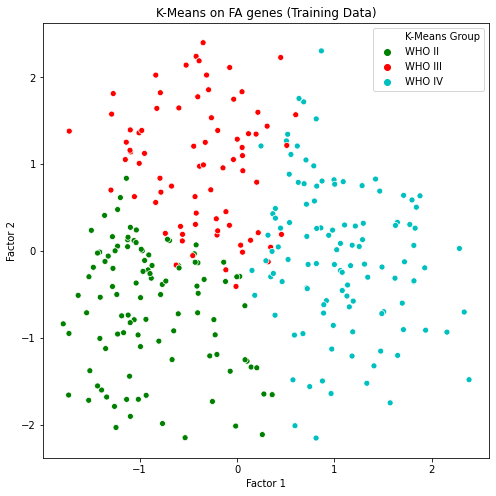

In [194]:
x = fa_top_kmeans_train['Factor 1']
y = fa_top_kmeans_train['Factor 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = fa_top_kmeans_train['K-Means Group'], palette = ['g', 'r', 'c'], hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("K-Means on FA genes (Training Data)")
plt.show()

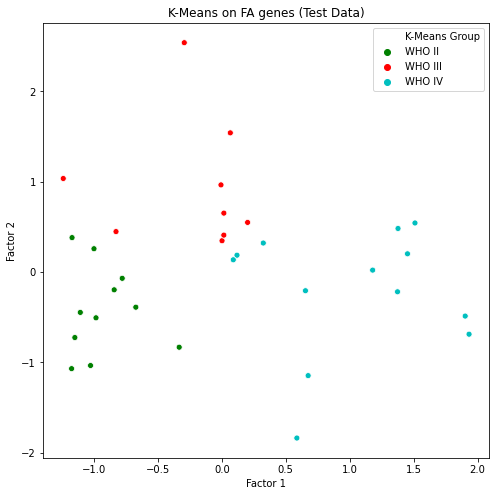

In [195]:
x = fa_top_kmeans_test['Factor 1']
y = fa_top_kmeans_test['Factor 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = fa_top_kmeans_test['K-Means Group'], palette = ['g', 'r', 'c'], hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("K-Means on FA genes (Test Data)")
plt.show()

### Compare Clusters to Grades

#### Accuracy Score

In [196]:
get_accuracy(fa_top_kmeans_train['Grade'], fa_top_kmeans_train['K-Means Group'])

0.6027397260273972

In [197]:
get_accuracy(fa_top_kmeans_test['Grade'], fa_top_kmeans_test['K-Means Group'])

0.6666666666666666

## On n Sparse PCs

### Implement

In [0]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)

kmeans.fit(sparse_train_genes)
test_pred = kmeans.predict(sparse_test_genes)

In [79]:
sparse_kmeans_test = pd.concat([pd.DataFrame(sparse_test), pd.DataFrame(test_pred)], axis = 1)

col_titles[:-2] = sparse_train.columns.values[:-1]
col_titles[-2:] = ['Grade', 'K-Means Group']
sparse_kmeans_test.columns = col_titles

sparse_kmeans_test = sparse_kmeans_test.replace({'K-Means Group': {0:'WHO III', 1:'WHO IV', 2:'WHO II'}})

sparse_kmeans_test.head()

,PC 1,PC 2,Grade,K-Means Group
0,12.643017,-77.676817,WHO IV,WHO III
1,10.648963,4.422605,WHO IV,WHO IV
2,-51.132604,5.446989,WHO II,WHO II
3,-40.303974,-20.365345,WHO II,WHO II
4,-35.936849,-13.596389,WHO II,WHO II


In [80]:
sparse_kmeans_train = pd.concat([pd.DataFrame(sparse_train), pd.DataFrame(kmeans.labels_)], axis = 1)

col_titles[:-2] = sparse_train.columns.values[:-1]
col_titles[-2:] = ['Grade', 'K-Means Group']
sparse_kmeans_train.columns = col_titles

sparse_kmeans_train = sparse_kmeans_train.replace({'K-Means Group': {0:'WHO III', 1:'WHO IV', 2:'WHO II'}})

sparse_kmeans_train.head()

,PC 1,PC 2,Grade,K-Means Group
0,-36.413191,4.815777,WHO II,WHO II
1,24.458767,0.265303,WHO IV,WHO IV
2,-39.690841,-5.777740,WHO II,WHO II
3,-6.991711,4.505546,WHO II,WHO II
4,-34.857176,2.318579,WHO II,WHO II


### Plot clusters

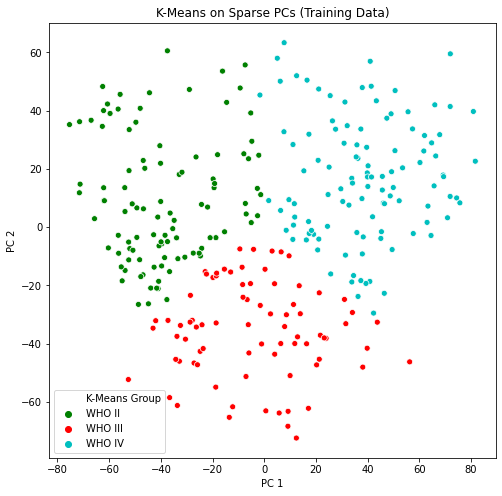

In [81]:
x = sparse_kmeans_train['PC 1']
y = sparse_kmeans_train['PC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = sparse_kmeans_train['K-Means Group'], palette = ['g', 'r', 'c'], hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("K-Means on Sparse PCs (Training Data)")
plt.show()

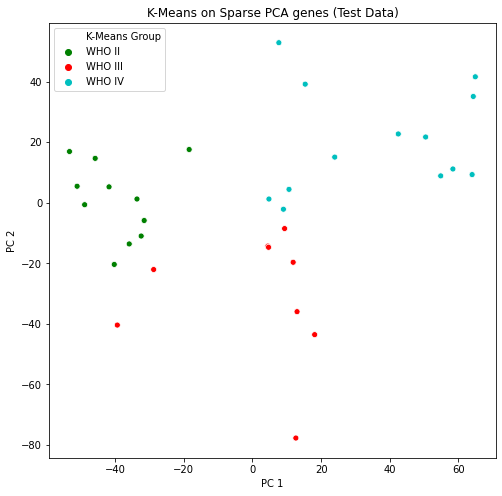

In [82]:
x = sparse_kmeans_test['PC 1']
y = sparse_kmeans_test['PC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = sparse_kmeans_test['K-Means Group'], palette = ['g', 'r', 'c'], hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("K-Means on Sparse PCA genes (Test Data)")
plt.show()

### Compare Clusters to Grades

#### Visually

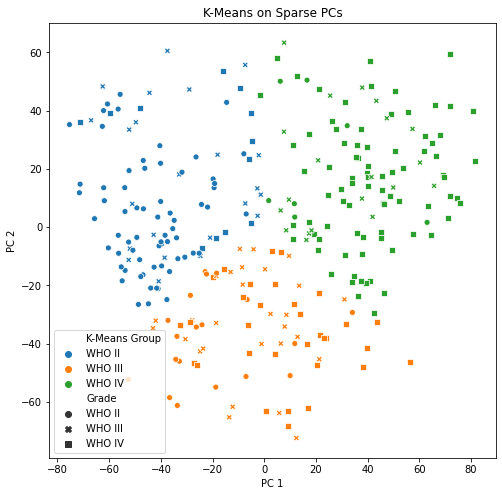

In [83]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'K-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = sparse_kmeans_train)
plt.title("K-Means on Sparse PCs")
plt.show()

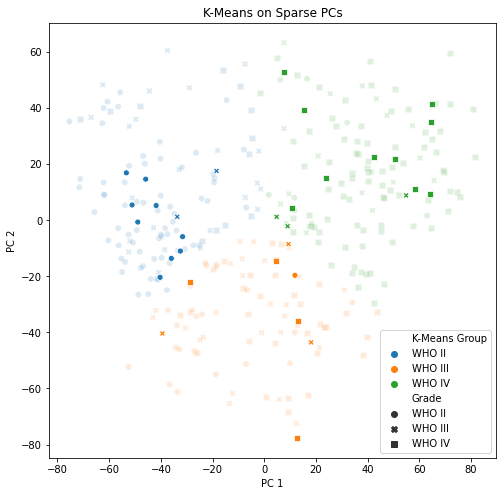

In [84]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'K-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = sparse_kmeans_train, alpha = .15)
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'K-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = sparse_kmeans_test, legend = False)
plt.title("K-Means on Sparse PCs")
plt.show()

#### Accuracy Score

In [85]:
get_accuracy(sparse_kmeans_train['Grade'], sparse_kmeans_train['K-Means Group'])

0.613013698630137

In [86]:
get_accuracy(sparse_kmeans_test['Grade'], sparse_kmeans_test['K-Means Group'])

0.6666666666666666

## On genes identified by Sparse PCA

### Implement

In [0]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)

kmeans.fit(sparse_important_train)
test_pred = kmeans.predict(sparse_important_test)

In [88]:
sparse_top_kmeans_test = pd.concat([pd.DataFrame(sparse_test), pd.DataFrame(test_pred)], axis = 1)

col_titles[:-2] = sparse_train.columns.values[:-1]
col_titles[-2:] = ['Grade', 'K-Means Group']
sparse_top_kmeans_test.columns = col_titles

sparse_top_kmeans_test = sparse_top_kmeans_test.replace({'K-Means Group': {0:'WHO III', 1:'WHO IV', 2:'WHO II'}})

sparse_top_kmeans_test.head()

,PC 1,PC 2,Grade,K-Means Group
0,12.643017,-77.676817,WHO IV,WHO III
1,10.648963,4.422605,WHO IV,WHO IV
2,-51.132604,5.446989,WHO II,WHO II
3,-40.303974,-20.365345,WHO II,WHO II
4,-35.936849,-13.596389,WHO II,WHO II


In [89]:
sparse_top_kmeans_train = pd.concat([pd.DataFrame(sparse_train), pd.DataFrame(kmeans.labels_)], axis = 1)

col_titles[:-2] = sparse_train.columns.values[:-1]
col_titles[-2:] = ['Grade', 'K-Means Group']
sparse_top_kmeans_train.columns = col_titles

sparse_top_kmeans_train = sparse_top_kmeans_train.replace({'K-Means Group': {0:'WHO III', 1:'WHO IV', 2:'WHO II'}})

sparse_top_kmeans_train.head()

,PC 1,PC 2,Grade,K-Means Group
0,-36.413191,4.815777,WHO II,WHO II
1,24.458767,0.265303,WHO IV,WHO IV
2,-39.690841,-5.777740,WHO II,WHO II
3,-6.991711,4.505546,WHO II,WHO III
4,-34.857176,2.318579,WHO II,WHO II


### Plot clusters

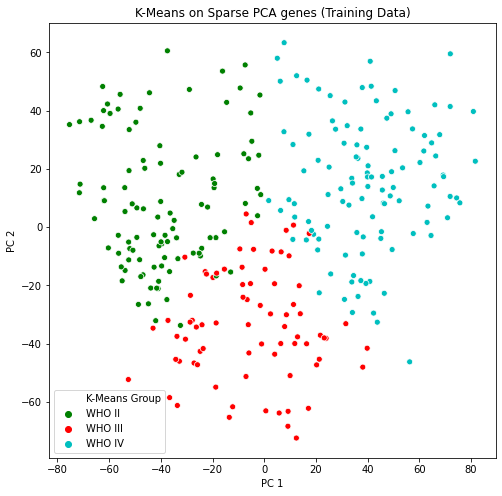

In [90]:
x = sparse_top_kmeans_train['PC 1']
y = sparse_top_kmeans_train['PC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = sparse_top_kmeans_train['K-Means Group'], palette = ['g', 'r', 'c'], hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("K-Means on Sparse PCA genes (Training Data)")
plt.show()

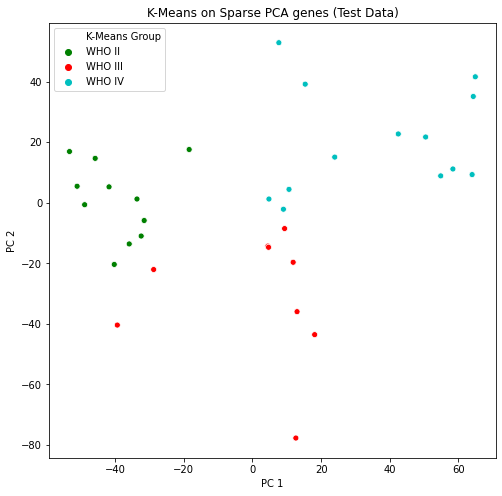

In [91]:
x = sparse_top_kmeans_test['PC 1']
y = sparse_top_kmeans_test['PC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = sparse_top_kmeans_test['K-Means Group'], palette = ['g', 'r', 'c'], hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("K-Means on Sparse PCA genes (Test Data)")
plt.show()

### Compare Clusters to Grades

#### Visually

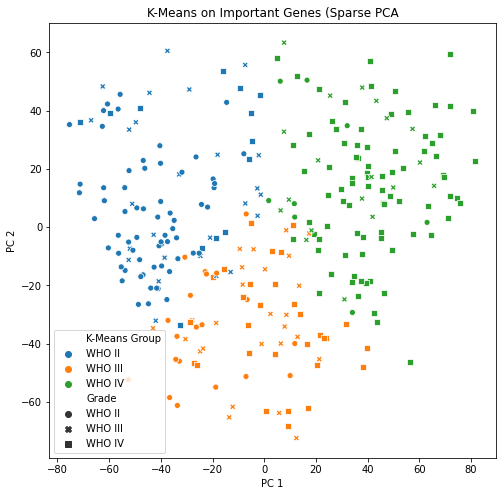

In [92]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'K-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = sparse_top_kmeans_train)
plt.title("K-Means on Important Genes (Sparse PCA")
plt.show()

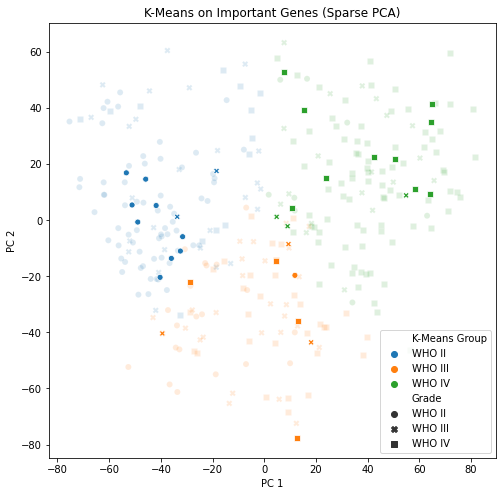

In [93]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'K-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = sparse_top_kmeans_train, alpha = .15)
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'K-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = sparse_top_kmeans_test, legend = False)
plt.title("K-Means on Important Genes (Sparse PCA)")
plt.show()

#### Accuracy Score

In [94]:
get_accuracy(sparse_top_kmeans_train['Grade'], sparse_top_kmeans_train['K-Means Group'])

0.6027397260273972

In [95]:
get_accuracy(sparse_top_kmeans_test['Grade'], sparse_top_kmeans_test['K-Means Group'])

0.6666666666666666

# Fuzzy C-Means

## On all 8000+ genes

### Implement

In [0]:
centers, c_train, init, distance, idk, iterations, fpc_train = cmeans(train_data.T, 
                                                                c = 3, m = 2, error=0.005, 
                                                                maxiter=1000, seed = 40)
c_test, init, distance, idk, iterations, fpc_test = cmeans_predict(test_data.T,
                                                                   centers, m = 2, error = 0.005,
                                                                   maxiter = 1000, seed = 30)

In [97]:
clusters_train = pd.DataFrame(np.argmax(c_train, axis = 0))

cmeans_train = pd.concat([pd.DataFrame(pca_train_genes), pd.DataFrame(clusters_train), pd.DataFrame(train_lbl)], axis = 1)

col_titles = [f'PC {x}' for x in range(1, 103)]
col_titles[-2:] = ['C-Means Group', 'Grade']
cmeans_train.columns = col_titles

cmeans_train = cmeans_train.replace({'C-Means Group': {0:'WHO III', 2:'WHO IV', 1:'WHO II'}})

cmeans_train.head()

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,PC 11,PC 12,PC 13,PC 14,PC 15,PC 16,PC 17,PC 18,PC 19,PC 20,PC 21,PC 22,PC 23,PC 24,PC 25,PC 26,PC 27,PC 28,PC 29,PC 30,PC 31,PC 32,PC 33,PC 34,PC 35,PC 36,PC 37,PC 38,PC 39,PC 40,...,PC 63,PC 64,PC 65,PC 66,PC 67,PC 68,PC 69,PC 70,PC 71,PC 72,PC 73,PC 74,PC 75,PC 76,PC 77,PC 78,PC 79,PC 80,PC 81,PC 82,PC 83,PC 84,PC 85,PC 86,PC 87,PC 88,PC 89,PC 90,PC 91,PC 92,PC 93,PC 94,PC 95,PC 96,PC 97,PC 98,PC 99,PC 100,C-Means Group,Grade
0,-33.435050,22.490684,38.097767,33.143324,-17.619484,-3.171189,20.422848,-43.082417,-8.627835,-40.189724,-5.465844,12.660643,6.474901,1.849231,17.776083,3.826548,5.573438,-7.040284,5.135255,-1.664143,-6.166108,4.009497,-1.826724,9.007044,6.159015,-7.805794,-4.325186,1.482421,-4.201913,4.000561,3.878437,-5.415432,-7.375138,-0.160841,-0.510255,2.192920,-2.173354,0.006804,-1.058477,-3.204084,...,5.008607,4.860570,4.643102,-0.535064,3.778756,0.622315,-2.530857,4.880558,1.727614,2.745107,4.730745,-1.841157,-0.922712,-2.406000,3.271590,5.472156,-3.876619,-1.981077,0.952377,-0.021147,1.547086,1.605269,4.035455,-1.445632,2.115250,5.634296,5.456446,0.133883,-1.037756,-1.739495,-0.737192,1.721679,-2.759915,2.641812,6.675747,-5.530448,2.266418,4.370240,WHO II,WHO II
1,23.423648,-7.423201,-17.507606,8.792664,6.431291,18.670121,9.897023,4.258872,-5.588874,-21.095125,-0.321909,0.209251,0.053999,-8.668732,0.180358,-4.388500,-2.999501,16.385283,-4.155462,-6.636527,-1.222793,-4.239253,5.987897,2.546961,-3.713511,1.623914,11.720301,4.274339,6.207523,2.401989,4.092058,-1.791507,-5.777590,-3.696712,6.245213,-4.232292,2.452928,-8.434929,10.449914,-0.615956,...,-0.177286,5.996773,-4.823631,-2.647002,-9.367976,-10.885565,-8.859610,1.501207,-6.202868,2.906427,-1.303148,5.989333,0.385217,-0.763037,-3.998872,4.238178,-2.304791,2.287783,-3.320622,-2.134242,7.699306,-10.091441,4.306083,8.596004,5.962502,1.032129,-7.437804,1.079408,4.134540,1.039711,4.062908,-4.534138,-4.315585,-1.729684,2.638636,0.672170,2.707216,-2.451562,WHO IV,WHO IV
2,-40.110197,7.114938,26.472899,-2.714789,2.348760,10.846684,24.951122,-15.587004,-12.524130,-13.831128,-8.257988,3.049685,-0.538335,4.341137,2.305903,13.010602,2.595942,-4.470677,-2.298029,17.880752,8.246806,7.951111,7.983959,4.172903,-6.476397,6.306320,-5.137204,0.316387,-6.379483,-3.291119,-3.082158,2.749579,4.906964,5.152140,-1.855474,-0.824835,-5.212199,-0.619580,-0.234999,2.049923,...,4.424833,0.820835,-5.940682,1.485920,-0.638603,-1.068303,-0.719452,-1.932281,-0.022624,-2.848085,0.989540,-2.472028,-1.842685,-7.521721,-0.533741,1.000672,-0.399758,-2.406002,-1.631125,-2.001025,-0.436460,-2.966490,0.405604,-1.663369,-4.180945,2.441507,2.205418,-1.501229,-7.001969,-1.207149,0.160861,-0.084642,-0.494133,4.142929,1.720335,0.097721,1.767304,-1.775615,WHO II,WHO II
3,-4.322818,5.918644,3.995310,-19.628973,-7.751300,-32.174274,-13.651554,2.071610,15.121478,-6.344321,-5.886538,0.644106,14.281353,-13.589629,9.364735,4.462571,-8.259393,2.416554,8.725246,0.637509,6.550074,2.068744,-4.283571,-0.981149,4.214905,1.755215,-3.518319,1.838896,7.655245,-3.166945,-6.106775,0.376025,-2.966488,-3.766382,-1.383230,-4.179557,-7.832833,-2.305416,3.079826,5.916520,...,2.708370,0.059107,0.979330,-0.170404,5.636206,3.116163,-4.319594,-2.107568,-2.268727,-1.356017,1.838254,-2.516068,-0.840261,2.778595,-5.101432,0.086985,4.971005,3.675710,-2.676070,2.651018,-0.397403,-0.418024,2.366223,-3.909779,-3.999657,1.217934,3.429463,-0.535684,-0.427905,-2.719327,-6.443787,0.926428,-3.243689,-0.012364,-1.114525,1.036728,-1.833460,4.305802,WHO II,WHO II
4,-32.589107,10.796249,10.908327,-21.124218,-3.384022,1.144420,17.386548,-5.382829,19.263883,8.949041,2.557392,6.291835,-4.473040,8.318883,-10.763494,0.588640,-2.126829,-7.916746,-0.148645,-3.248871,-7.025282,-4.662379,1.824813,1.262275,1.846083,-0.825017,-4.342887,-1.906904,7.044814,-4.714351,4.018129,5.869568,3.870139,7.186362,-0.670991,0.010142,-2.045424,0.002795,5.167696,-1.381443,...,-1.502334,1.260479,-0.364275,-2.770996,-2.3

In [98]:
clusters_test = pd.DataFrame(np.argmax(c_test, axis = 0))

cmeans_test = pd.concat([pd.DataFrame(pca_test_genes), pd.DataFrame(clusters_test), pd.DataFrame(test_lbl)], axis = 1)

col_titles = [f'PC {x}' for x in range(1, 103)]
col_titles[-2:] = ['C-Means Group', 'Grade']
cmeans_test.columns = col_titles

cmeans_test = cmeans_test.replace({'C-Means Group': {0:'WHO III', 2:'WHO IV', 1:'WHO II'}})

cmeans_test.head()

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,PC 11,PC 12,PC 13,PC 14,PC 15,PC 16,PC 17,PC 18,PC 19,PC 20,PC 21,PC 22,PC 23,PC 24,PC 25,PC 26,PC 27,PC 28,PC 29,PC 30,PC 31,PC 32,PC 33,PC 34,PC 35,PC 36,PC 37,PC 38,PC 39,PC 40,...,PC 63,PC 64,PC 65,PC 66,PC 67,PC 68,PC 69,PC 70,PC 71,PC 72,PC 73,PC 74,PC 75,PC 76,PC 77,PC 78,PC 79,PC 80,PC 81,PC 82,PC 83,PC 84,PC 85,PC 86,PC 87,PC 88,PC 89,PC 90,PC 91,PC 92,PC 93,PC 94,PC 95,PC 96,PC 97,PC 98,PC 99,PC 100,C-Means Group,Grade
0,-17.018512,-76.678514,15.561575,3.062705,-7.722775,-8.775855,-4.664845,23.154769,0.509306,7.973493,-3.623431,5.865838,-4.550082,12.146977,-1.392681,-18.247655,6.898328,0.944234,11.385726,6.992770,12.331238,11.713086,0.710077,2.287172,-13.372765,6.968041,-10.298332,8.281167,-2.427184,-1.382116,-4.428495,1.189871,9.345460,11.165574,8.224162,0.316288,-5.162597,6.389885,9.948396,-1.074746,...,-3.197128,-0.143310,-1.270086,7.528369,2.055503,-5.333428,6.268508,0.078297,-3.276162,-0.453180,1.323430,-9.156285,8.630677,5.765287,6.622815,3.409527,-9.926912,-6.116751,5.465556,-0.973197,-3.731823,6.626961,-4.109379,-0.879745,0.127893,-3.803998,3.614193,0.048250,-2.899580,-1.551742,4.094361,-0.328319,-2.426534,3.283960,-4.978379,-2.093411,-4.246000,1.392405,WHO II,WHO IV
1,10.671509,6.637014,61.410853,35.650646,23.106030,-2.143411,-25.585952,-1.896259,-3.161317,29.643123,20.772154,-8.631343,10.109134,-4.321388,-1.290504,12.302256,5.606665,10.250756,-11.291593,8.424251,-7.446641,0.821122,6.364189,-1.287883,-0.528536,-2.792364,-0.898207,3.480841,13.059164,9.267527,-0.347305,-0.757466,9.309101,-10.087992,-1.771065,-4.107091,1.861269,-1.857201,0.604133,4.200106,...,1.809971,-2.988788,0.647669,2.470109,-2.665681,-1.667134,5.049326,5.713522,-2.427822,-3.809754,3.298483,2.034078,1.610837,-2.650715,0.027485,1.787696,2.078637,-2.181849,-0.176825,3.988677,0.841327,0.843844,-4.294727,-2.569276,-3.677456,2.771831,3.985848,1.352749,-4.459143,-4.306666,-0.474310,0.815713,1.557357,-0.717527,-3.843549,-2.087681,3.733449,0.008205,WHO IV,WHO IV
2,-47.478944,19.938839,0.775281,-5.393338,1.060001,-1.258295,18.845096,10.749328,8.432678,-1.510646,2.499019,2.215205,-3.571154,5.633107,3.777485,3.711312,-0.019695,-0.570238,-3.033789,4.688640,9.407064,-0.977668,-0.793261,0.618236,-4.136842,8.104762,1.443780,2.798849,-0.375756,-5.154681,-0.702524,3.024305,7.074151,6.507438,-4.232588,-4.472853,2.409570,-2.027083,-0.704039,5.608382,...,1.095985,-0.129219,-2.472738,1.127178,-3.152503,-0.426621,-2.651263,-2.184907,1.679962,-0.023509,1.857405,0.330693,-0.111450,-1.890244,3.137612,2.764058,-3.171187,0.351696,1.795306,-3.253062,0.999530,1.235816,0.087417,-0.315057,-2.167105,-2.291935,-2.714354,0.613106,0.767404,1.055777,-0.316400,0.281573,0.362711,-0.987278,2.479443,1.605464,-1.518974,0.128048,WHO II,WHO II
3,-46.293701,-8.338783,-8.556460,-11.787487,7.931988,-12.844719,6.540818,-18.449527,8.280566,2.268330,6.155864,6.697970,12.439044,-3.760193,3.322000,1.446556,-10.136128,-5.682184,-2.643613,3.815846,-2.070176,7.834681,-0.858004,-0.564004,-3.170614,-0.353465,-2.031324,3.339676,-3.248661,3.050186,3.204771,-0.560890,0.363286,3.926756,-1.125296,-1.214816,-0.560080,1.225001,-1.566592,0.479275,...,2.890916,-0.705937,-0.002263,0.538249,0.925144,-0.943887,-0.997912,-0.542422,-0.795057,1.968297,3.123509,0.191454,0.629973,-0.802764,1.378244,1.614012,0.906229,2.049833,-0.569304,0.790234,-0.425043,-2.275452,1.844780,1.288615,-0.603150,0.371771,1.635540,-0.873952,1.444501,-1.680922,-0.551190,-0.391136,-0.765349,0.254669,2.381193,0.293890,-1.085323,-0.797865,WHO II,WHO II
4,-39.708933,-1.918164,-1.080752,-5.932954,7.909139,-28.034350,4.023441,-14.541410,18.140569,-0.283968,4.532058,6.897554,6.876141,-6.633340,1.865254,2.966991,-10.198865,1.619051,-1.489895,2.532259,4.959692,6.446161,-2.915481,-0.140089,-4.472868,4.331271,-2.180906,0.614712,-1.106064,-1.564332,-3.963458,-4.127570,-1.506200,0.807357,-1.416793,-0.039085,0.160181,-0.614034,1.396443,-0.092935,...,2.369309,0.646424,-1.479211,0.584148,2.040954,-0.

### Plot Clusters

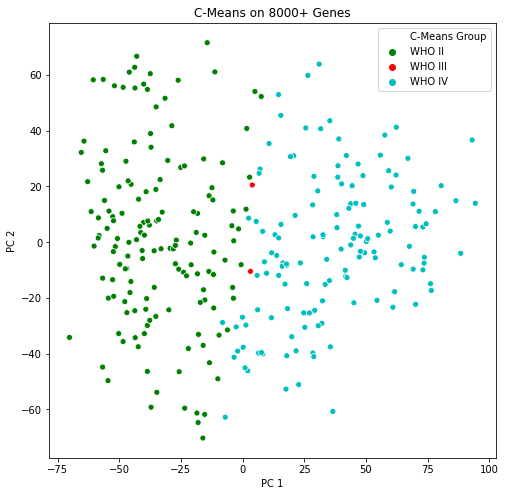

In [99]:
x = cmeans_train['PC 1']
y = cmeans_train['PC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = cmeans_train['C-Means Group'], palette = ['g', 'r', 'c'], 
               hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("C-Means on 8000+ Genes")
plt.show()

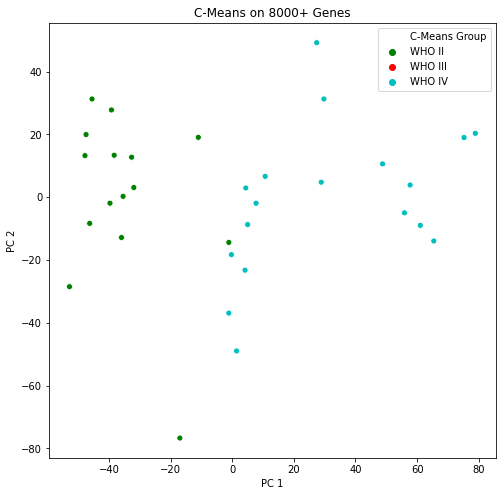

In [100]:
x = cmeans_test['PC 1']
y = cmeans_test['PC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = cmeans_test['C-Means Group'], palette = ['g', 'r', 'c'], 
               hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("C-Means on 8000+ Genes")
plt.show()

### Compare Clusters to Grades

#### Visually

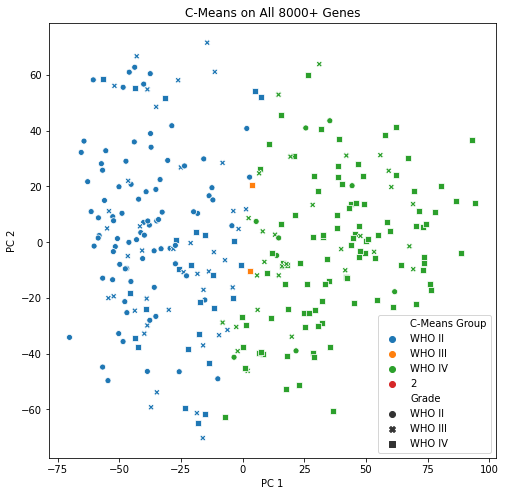

In [101]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV',2],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_train)
plt.title("C-Means on All 8000+ Genes")
plt.show()

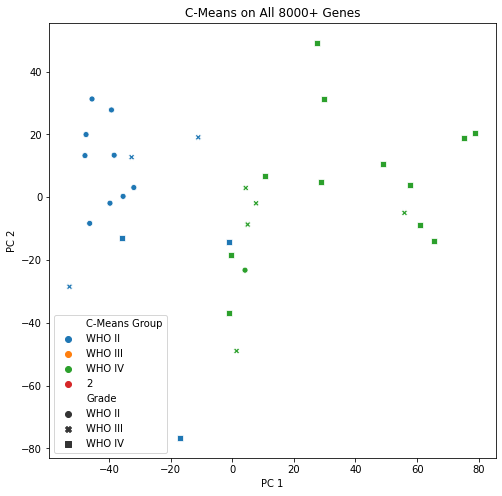

In [102]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV',2],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_test)
plt.title("C-Means on All 8000+ Genes")
plt.show()

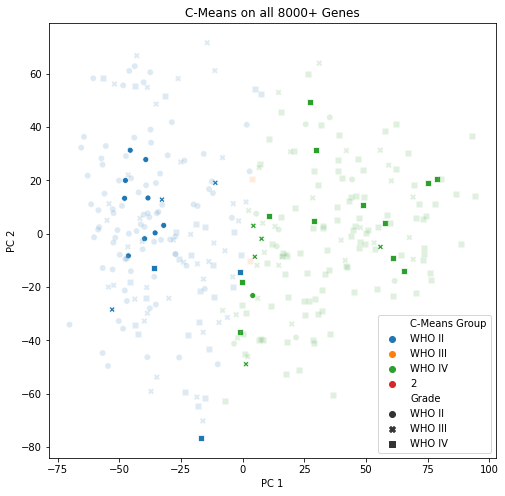

In [103]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV',2],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_test)
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV',2],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_train, alpha = .15, legend = False)
plt.title("C-Means on all 8000+ Genes")
plt.show()

#### Accuracy Score

In [104]:
get_accuracy(cmeans_train['Grade'], cmeans_train['C-Means Group'])

0.6301369863013698

In [105]:
get_accuracy(cmeans_test['Grade'], cmeans_test['C-Means Group'])

0.6363636363636364

## On 100 PCs

### Implement

In [0]:
centers_pca, c_train_pca, init, distance, idk, iterations, fpc_train = cmeans(pca_train_genes.T, 
                                                                c = 3, m = 2, error=0.005, 
                                                                maxiter=1000, seed = 40)
c_test_pca, init, distance, idk, iterations, fpc_test = cmeans_predict(pca_test_genes.T,
                                                                   centers_pca, m = 2, error = 0.005,
                                                                   maxiter = 1000, seed = 30)

In [107]:
clusters_train_pca = pd.DataFrame(np.argmax(c_train_pca, axis = 0))

cmeans_train_pca = pd.concat([pd.DataFrame(pca_train_genes), pd.DataFrame(clusters_train_pca), pd.DataFrame(train_lbl)], axis = 1)

col_titles = [f'PC {x}' for x in range(1, 103)]
col_titles[-2:] = ['C-Means Group', 'Grade']
cmeans_train_pca.columns = col_titles

cmeans_train_pca = cmeans_train_pca.replace({'C-Means Group': {0:'WHO III', 2:'WHO IV', 1:'WHO II'}})

cmeans_train_pca.head()

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,PC 11,PC 12,PC 13,PC 14,PC 15,PC 16,PC 17,PC 18,PC 19,PC 20,PC 21,PC 22,PC 23,PC 24,PC 25,PC 26,PC 27,PC 28,PC 29,PC 30,PC 31,PC 32,PC 33,PC 34,PC 35,PC 36,PC 37,PC 38,PC 39,PC 40,...,PC 63,PC 64,PC 65,PC 66,PC 67,PC 68,PC 69,PC 70,PC 71,PC 72,PC 73,PC 74,PC 75,PC 76,PC 77,PC 78,PC 79,PC 80,PC 81,PC 82,PC 83,PC 84,PC 85,PC 86,PC 87,PC 88,PC 89,PC 90,PC 91,PC 92,PC 93,PC 94,PC 95,PC 96,PC 97,PC 98,PC 99,PC 100,C-Means Group,Grade
0,-33.435050,22.490684,38.097767,33.143324,-17.619484,-3.171189,20.422848,-43.082417,-8.627835,-40.189724,-5.465844,12.660643,6.474901,1.849231,17.776083,3.826548,5.573438,-7.040284,5.135255,-1.664143,-6.166108,4.009497,-1.826724,9.007044,6.159015,-7.805794,-4.325186,1.482421,-4.201913,4.000561,3.878437,-5.415432,-7.375138,-0.160841,-0.510255,2.192920,-2.173354,0.006804,-1.058477,-3.204084,...,5.008607,4.860570,4.643102,-0.535064,3.778756,0.622315,-2.530857,4.880558,1.727614,2.745107,4.730745,-1.841157,-0.922712,-2.406000,3.271590,5.472156,-3.876619,-1.981077,0.952377,-0.021147,1.547086,1.605269,4.035455,-1.445632,2.115250,5.634296,5.456446,0.133883,-1.037756,-1.739495,-0.737192,1.721679,-2.759915,2.641812,6.675747,-5.530448,2.266418,4.370240,WHO II,WHO II
1,23.423648,-7.423201,-17.507606,8.792664,6.431291,18.670121,9.897023,4.258872,-5.588874,-21.095125,-0.321909,0.209251,0.053999,-8.668732,0.180358,-4.388500,-2.999501,16.385283,-4.155462,-6.636527,-1.222793,-4.239253,5.987897,2.546961,-3.713511,1.623914,11.720301,4.274339,6.207523,2.401989,4.092058,-1.791507,-5.777590,-3.696712,6.245213,-4.232292,2.452928,-8.434929,10.449914,-0.615956,...,-0.177286,5.996773,-4.823631,-2.647002,-9.367976,-10.885565,-8.859610,1.501207,-6.202868,2.906427,-1.303148,5.989333,0.385217,-0.763037,-3.998872,4.238178,-2.304791,2.287783,-3.320622,-2.134242,7.699306,-10.091441,4.306083,8.596004,5.962502,1.032129,-7.437804,1.079408,4.134540,1.039711,4.062908,-4.534138,-4.315585,-1.729684,2.638636,0.672170,2.707216,-2.451562,WHO IV,WHO IV
2,-40.110197,7.114938,26.472899,-2.714789,2.348760,10.846684,24.951122,-15.587004,-12.524130,-13.831128,-8.257988,3.049685,-0.538335,4.341137,2.305903,13.010602,2.595942,-4.470677,-2.298029,17.880752,8.246806,7.951111,7.983959,4.172903,-6.476397,6.306320,-5.137204,0.316387,-6.379483,-3.291119,-3.082158,2.749579,4.906964,5.152140,-1.855474,-0.824835,-5.212199,-0.619580,-0.234999,2.049923,...,4.424833,0.820835,-5.940682,1.485920,-0.638603,-1.068303,-0.719452,-1.932281,-0.022624,-2.848085,0.989540,-2.472028,-1.842685,-7.521721,-0.533741,1.000672,-0.399758,-2.406002,-1.631125,-2.001025,-0.436460,-2.966490,0.405604,-1.663369,-4.180945,2.441507,2.205418,-1.501229,-7.001969,-1.207149,0.160861,-0.084642,-0.494133,4.142929,1.720335,0.097721,1.767304,-1.775615,WHO II,WHO II
3,-4.322818,5.918644,3.995310,-19.628973,-7.751300,-32.174274,-13.651554,2.071610,15.121478,-6.344321,-5.886538,0.644106,14.281353,-13.589629,9.364735,4.462571,-8.259393,2.416554,8.725246,0.637509,6.550074,2.068744,-4.283571,-0.981149,4.214905,1.755215,-3.518319,1.838896,7.655245,-3.166945,-6.106775,0.376025,-2.966488,-3.766382,-1.383230,-4.179557,-7.832833,-2.305416,3.079826,5.916520,...,2.708370,0.059107,0.979330,-0.170404,5.636206,3.116163,-4.319594,-2.107568,-2.268727,-1.356017,1.838254,-2.516068,-0.840261,2.778595,-5.101432,0.086985,4.971005,3.675710,-2.676070,2.651018,-0.397403,-0.418024,2.366223,-3.909779,-3.999657,1.217934,3.429463,-0.535684,-0.427905,-2.719327,-6.443787,0.926428,-3.243689,-0.012364,-1.114525,1.036728,-1.833460,4.305802,WHO II,WHO II
4,-32.589107,10.796249,10.908327,-21.124218,-3.384022,1.144420,17.386548,-5.382829,19.263883,8.949041,2.557392,6.291835,-4.473040,8.318883,-10.763494,0.588640,-2.126829,-7.916746,-0.148645,-3.248871,-7.025282,-4.662379,1.824813,1.262275,1.846083,-0.825017,-4.342887,-1.906904,7.044814,-4.714351,4.018129,5.869568,3.870139,7.186362,-0.670991,0.010142,-2.045424,0.002795,5.167696,-1.381443,...,-1.502334,1.260479,-0.364275,-2.770996,-2.3

In [108]:
clusters_test_pca = pd.DataFrame(np.argmax(c_test_pca, axis = 0))

cmeans_test_pca = pd.concat([pd.DataFrame(pca_test_genes), pd.DataFrame(clusters_test_pca), 
                             pd.DataFrame(test_lbl)], axis = 1)

col_titles = [f'PC {x}' for x in range(1, 103)]
col_titles[-2:] = ['C-Means Group', 'Grade']
cmeans_test_pca.columns = col_titles

cmeans_test_pca = cmeans_test_pca.replace({'C-Means Group': {0:'WHO III', 2:'WHO IV', 1:'WHO II'}})

cmeans_test_pca.head()

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,PC 11,PC 12,PC 13,PC 14,PC 15,PC 16,PC 17,PC 18,PC 19,PC 20,PC 21,PC 22,PC 23,PC 24,PC 25,PC 26,PC 27,PC 28,PC 29,PC 30,PC 31,PC 32,PC 33,PC 34,PC 35,PC 36,PC 37,PC 38,PC 39,PC 40,...,PC 63,PC 64,PC 65,PC 66,PC 67,PC 68,PC 69,PC 70,PC 71,PC 72,PC 73,PC 74,PC 75,PC 76,PC 77,PC 78,PC 79,PC 80,PC 81,PC 82,PC 83,PC 84,PC 85,PC 86,PC 87,PC 88,PC 89,PC 90,PC 91,PC 92,PC 93,PC 94,PC 95,PC 96,PC 97,PC 98,PC 99,PC 100,C-Means Group,Grade
0,-17.018512,-76.678514,15.561575,3.062705,-7.722775,-8.775855,-4.664845,23.154769,0.509306,7.973493,-3.623431,5.865838,-4.550082,12.146977,-1.392681,-18.247655,6.898328,0.944234,11.385726,6.992770,12.331238,11.713086,0.710077,2.287172,-13.372765,6.968041,-10.298332,8.281167,-2.427184,-1.382116,-4.428495,1.189871,9.345460,11.165574,8.224162,0.316288,-5.162597,6.389885,9.948396,-1.074746,...,-3.197128,-0.143310,-1.270086,7.528369,2.055503,-5.333428,6.268508,0.078297,-3.276162,-0.453180,1.323430,-9.156285,8.630677,5.765287,6.622815,3.409527,-9.926912,-6.116751,5.465556,-0.973197,-3.731823,6.626961,-4.109379,-0.879745,0.127893,-3.803998,3.614193,0.048250,-2.899580,-1.551742,4.094361,-0.328319,-2.426534,3.283960,-4.978379,-2.093411,-4.246000,1.392405,WHO II,WHO IV
1,10.671509,6.637014,61.410853,35.650646,23.106030,-2.143411,-25.585952,-1.896259,-3.161317,29.643123,20.772154,-8.631343,10.109134,-4.321388,-1.290504,12.302256,5.606665,10.250756,-11.291593,8.424251,-7.446641,0.821122,6.364189,-1.287883,-0.528536,-2.792364,-0.898207,3.480841,13.059164,9.267527,-0.347305,-0.757466,9.309101,-10.087992,-1.771065,-4.107091,1.861269,-1.857201,0.604133,4.200106,...,1.809971,-2.988788,0.647669,2.470109,-2.665681,-1.667134,5.049326,5.713522,-2.427822,-3.809754,3.298483,2.034078,1.610837,-2.650715,0.027485,1.787696,2.078637,-2.181849,-0.176825,3.988677,0.841327,0.843844,-4.294727,-2.569276,-3.677456,2.771831,3.985848,1.352749,-4.459143,-4.306666,-0.474310,0.815713,1.557357,-0.717527,-3.843549,-2.087681,3.733449,0.008205,WHO IV,WHO IV
2,-47.478944,19.938839,0.775281,-5.393338,1.060001,-1.258295,18.845096,10.749328,8.432678,-1.510646,2.499019,2.215205,-3.571154,5.633107,3.777485,3.711312,-0.019695,-0.570238,-3.033789,4.688640,9.407064,-0.977668,-0.793261,0.618236,-4.136842,8.104762,1.443780,2.798849,-0.375756,-5.154681,-0.702524,3.024305,7.074151,6.507438,-4.232588,-4.472853,2.409570,-2.027083,-0.704039,5.608382,...,1.095985,-0.129219,-2.472738,1.127178,-3.152503,-0.426621,-2.651263,-2.184907,1.679962,-0.023509,1.857405,0.330693,-0.111450,-1.890244,3.137612,2.764058,-3.171187,0.351696,1.795306,-3.253062,0.999530,1.235816,0.087417,-0.315057,-2.167105,-2.291935,-2.714354,0.613106,0.767404,1.055777,-0.316400,0.281573,0.362711,-0.987278,2.479443,1.605464,-1.518974,0.128048,WHO II,WHO II
3,-46.293701,-8.338783,-8.556460,-11.787487,7.931988,-12.844719,6.540818,-18.449527,8.280566,2.268330,6.155864,6.697970,12.439044,-3.760193,3.322000,1.446556,-10.136128,-5.682184,-2.643613,3.815846,-2.070176,7.834681,-0.858004,-0.564004,-3.170614,-0.353465,-2.031324,3.339676,-3.248661,3.050186,3.204771,-0.560890,0.363286,3.926756,-1.125296,-1.214816,-0.560080,1.225001,-1.566592,0.479275,...,2.890916,-0.705937,-0.002263,0.538249,0.925144,-0.943887,-0.997912,-0.542422,-0.795057,1.968297,3.123509,0.191454,0.629973,-0.802764,1.378244,1.614012,0.906229,2.049833,-0.569304,0.790234,-0.425043,-2.275452,1.844780,1.288615,-0.603150,0.371771,1.635540,-0.873952,1.444501,-1.680922,-0.551190,-0.391136,-0.765349,0.254669,2.381193,0.293890,-1.085323,-0.797865,WHO II,WHO II
4,-39.708933,-1.918164,-1.080752,-5.932954,7.909139,-28.034350,4.023441,-14.541410,18.140569,-0.283968,4.532058,6.897554,6.876141,-6.633340,1.865254,2.966991,-10.198865,1.619051,-1.489895,2.532259,4.959692,6.446161,-2.915481,-0.140089,-4.472868,4.331271,-2.180906,0.614712,-1.106064,-1.564332,-3.963458,-4.127570,-1.506200,0.807357,-1.416793,-0.039085,0.160181,-0.614034,1.396443,-0.092935,...,2.369309,0.646424,-1.479211,0.584148,2.040954,-0.

### Plot Clusters

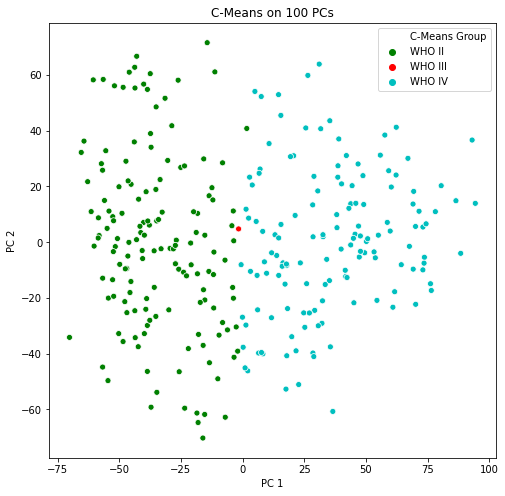

In [109]:
x = cmeans_train_pca['PC 1']
y = cmeans_train_pca['PC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = cmeans_train_pca['C-Means Group'], palette = ['g', 'r', 'c'], 
               hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("C-Means on 100 PCs")
plt.show()

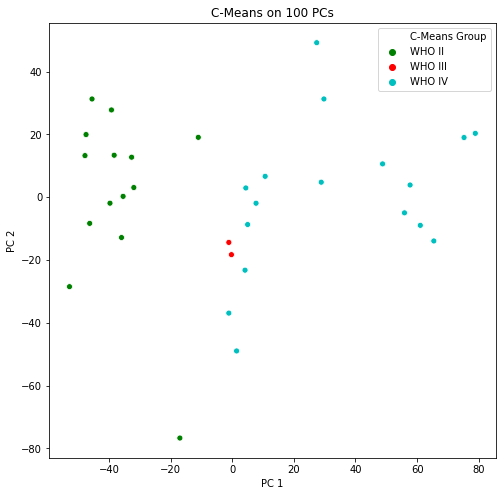

In [110]:
x = cmeans_test_pca['PC 1']
y = cmeans_test_pca['PC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = cmeans_test_pca['C-Means Group'], palette = ['g', 'r', 'c'], 
               hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("C-Means on 100 PCs")
plt.show()

### Compare Clusters to Grades

#### Visually

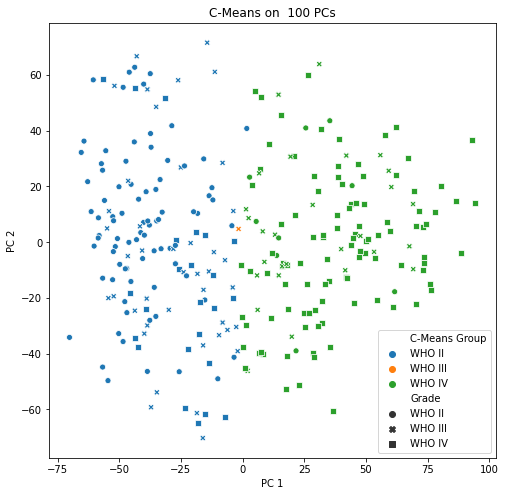

In [111]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_train_pca)
plt.title("C-Means on  100 PCs")
plt.show()

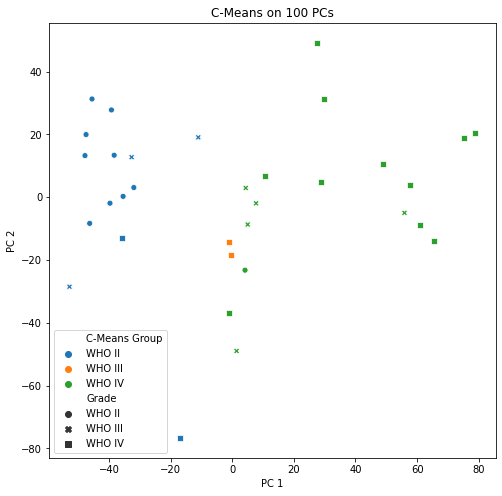

In [112]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_test_pca)
plt.title("C-Means on 100 PCs")
plt.show()

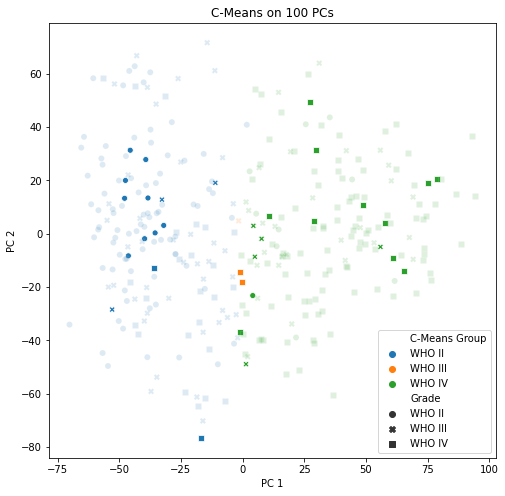

In [113]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_test_pca)
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_train_pca, alpha = .15, legend = False)
plt.title("C-Means on 100 PCs")
plt.show()

#### Accuracy Score

In [114]:
get_accuracy(cmeans_train_pca['Grade'], cmeans_train_pca['C-Means Group'])

0.6472602739726028

In [115]:
get_accuracy(cmeans_test_pca['Grade'], cmeans_test_pca['C-Means Group'])

0.6060606060606061

## On important genes identified by PCA

### Implement

In [0]:
centers_top, c_train_top, init, distance, idk, iterations, fpc_train = cmeans(important_train.T, 
                                                                c = 3, m = 2, error=0.005, 
                                                                maxiter=1000, seed = 40)
c_test_top, init, distance, idk, iterations, fpc_test = cmeans_predict(important_test.T,
                                                                   centers_top, m = 2, error = 0.005,
                                                                   maxiter = 1000, seed = 30)

In [117]:
clusters_train_top = pd.DataFrame(np.argmax(c_train_top, axis = 0))

cmeans_train_top = pd.concat([pd.DataFrame(pca_train_genes), pd.DataFrame(clusters_train_top), pd.DataFrame(train_lbl)], axis = 1)

col_titles = [f'PC {x}' for x in range(1, 103)]
col_titles[-2:] = ['C-Means Group', 'Grade']
cmeans_train_top.columns = col_titles

cmeans_train_top = cmeans_train_top.replace({'C-Means Group': {0:'WHO III', 2:'WHO IV', 1:'WHO II'}})

cmeans_train_top.head()

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,PC 11,PC 12,PC 13,PC 14,PC 15,PC 16,PC 17,PC 18,PC 19,PC 20,PC 21,PC 22,PC 23,PC 24,PC 25,PC 26,PC 27,PC 28,PC 29,PC 30,PC 31,PC 32,PC 33,PC 34,PC 35,PC 36,PC 37,PC 38,PC 39,PC 40,...,PC 63,PC 64,PC 65,PC 66,PC 67,PC 68,PC 69,PC 70,PC 71,PC 72,PC 73,PC 74,PC 75,PC 76,PC 77,PC 78,PC 79,PC 80,PC 81,PC 82,PC 83,PC 84,PC 85,PC 86,PC 87,PC 88,PC 89,PC 90,PC 91,PC 92,PC 93,PC 94,PC 95,PC 96,PC 97,PC 98,PC 99,PC 100,C-Means Group,Grade
0,-33.435050,22.490684,38.097767,33.143324,-17.619484,-3.171189,20.422848,-43.082417,-8.627835,-40.189724,-5.465844,12.660643,6.474901,1.849231,17.776083,3.826548,5.573438,-7.040284,5.135255,-1.664143,-6.166108,4.009497,-1.826724,9.007044,6.159015,-7.805794,-4.325186,1.482421,-4.201913,4.000561,3.878437,-5.415432,-7.375138,-0.160841,-0.510255,2.192920,-2.173354,0.006804,-1.058477,-3.204084,...,5.008607,4.860570,4.643102,-0.535064,3.778756,0.622315,-2.530857,4.880558,1.727614,2.745107,4.730745,-1.841157,-0.922712,-2.406000,3.271590,5.472156,-3.876619,-1.981077,0.952377,-0.021147,1.547086,1.605269,4.035455,-1.445632,2.115250,5.634296,5.456446,0.133883,-1.037756,-1.739495,-0.737192,1.721679,-2.759915,2.641812,6.675747,-5.530448,2.266418,4.370240,WHO II,WHO II
1,23.423648,-7.423201,-17.507606,8.792664,6.431291,18.670121,9.897023,4.258872,-5.588874,-21.095125,-0.321909,0.209251,0.053999,-8.668732,0.180358,-4.388500,-2.999501,16.385283,-4.155462,-6.636527,-1.222793,-4.239253,5.987897,2.546961,-3.713511,1.623914,11.720301,4.274339,6.207523,2.401989,4.092058,-1.791507,-5.777590,-3.696712,6.245213,-4.232292,2.452928,-8.434929,10.449914,-0.615956,...,-0.177286,5.996773,-4.823631,-2.647002,-9.367976,-10.885565,-8.859610,1.501207,-6.202868,2.906427,-1.303148,5.989333,0.385217,-0.763037,-3.998872,4.238178,-2.304791,2.287783,-3.320622,-2.134242,7.699306,-10.091441,4.306083,8.596004,5.962502,1.032129,-7.437804,1.079408,4.134540,1.039711,4.062908,-4.534138,-4.315585,-1.729684,2.638636,0.672170,2.707216,-2.451562,WHO IV,WHO IV
2,-40.110197,7.114938,26.472899,-2.714789,2.348760,10.846684,24.951122,-15.587004,-12.524130,-13.831128,-8.257988,3.049685,-0.538335,4.341137,2.305903,13.010602,2.595942,-4.470677,-2.298029,17.880752,8.246806,7.951111,7.983959,4.172903,-6.476397,6.306320,-5.137204,0.316387,-6.379483,-3.291119,-3.082158,2.749579,4.906964,5.152140,-1.855474,-0.824835,-5.212199,-0.619580,-0.234999,2.049923,...,4.424833,0.820835,-5.940682,1.485920,-0.638603,-1.068303,-0.719452,-1.932281,-0.022624,-2.848085,0.989540,-2.472028,-1.842685,-7.521721,-0.533741,1.000672,-0.399758,-2.406002,-1.631125,-2.001025,-0.436460,-2.966490,0.405604,-1.663369,-4.180945,2.441507,2.205418,-1.501229,-7.001969,-1.207149,0.160861,-0.084642,-0.494133,4.142929,1.720335,0.097721,1.767304,-1.775615,WHO II,WHO II
3,-4.322818,5.918644,3.995310,-19.628973,-7.751300,-32.174274,-13.651554,2.071610,15.121478,-6.344321,-5.886538,0.644106,14.281353,-13.589629,9.364735,4.462571,-8.259393,2.416554,8.725246,0.637509,6.550074,2.068744,-4.283571,-0.981149,4.214905,1.755215,-3.518319,1.838896,7.655245,-3.166945,-6.106775,0.376025,-2.966488,-3.766382,-1.383230,-4.179557,-7.832833,-2.305416,3.079826,5.916520,...,2.708370,0.059107,0.979330,-0.170404,5.636206,3.116163,-4.319594,-2.107568,-2.268727,-1.356017,1.838254,-2.516068,-0.840261,2.778595,-5.101432,0.086985,4.971005,3.675710,-2.676070,2.651018,-0.397403,-0.418024,2.366223,-3.909779,-3.999657,1.217934,3.429463,-0.535684,-0.427905,-2.719327,-6.443787,0.926428,-3.243689,-0.012364,-1.114525,1.036728,-1.833460,4.305802,WHO II,WHO II
4,-32.589107,10.796249,10.908327,-21.124218,-3.384022,1.144420,17.386548,-5.382829,19.263883,8.949041,2.557392,6.291835,-4.473040,8.318883,-10.763494,0.588640,-2.126829,-7.916746,-0.148645,-3.248871,-7.025282,-4.662379,1.824813,1.262275,1.846083,-0.825017,-4.342887,-1.906904,7.044814,-4.714351,4.018129,5.869568,3.870139,7.186362,-0.670991,0.010142,-2.045424,0.002795,5.167696,-1.381443,...,-1.502334,1.260479,-0.364275,-2.770996,-2.3

In [118]:
clusters_test_top = pd.DataFrame(np.argmax(c_test_top, axis = 0))

cmeans_test_top = pd.concat([pd.DataFrame(pca_test_genes), pd.DataFrame(clusters_test_top), pd.DataFrame(test_lbl)], axis = 1)

col_titles = [f'PC {x}' for x in range(1, 103)]
col_titles[-2:] = ['C-Means Group', 'Grade']
cmeans_test_top.columns = col_titles

cmeans_test_top = cmeans_test_top.replace({'C-Means Group': {0:'WHO III', 2:'WHO IV', 1:'WHO II'}})

cmeans_test_top.head()

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,PC 11,PC 12,PC 13,PC 14,PC 15,PC 16,PC 17,PC 18,PC 19,PC 20,PC 21,PC 22,PC 23,PC 24,PC 25,PC 26,PC 27,PC 28,PC 29,PC 30,PC 31,PC 32,PC 33,PC 34,PC 35,PC 36,PC 37,PC 38,PC 39,PC 40,...,PC 63,PC 64,PC 65,PC 66,PC 67,PC 68,PC 69,PC 70,PC 71,PC 72,PC 73,PC 74,PC 75,PC 76,PC 77,PC 78,PC 79,PC 80,PC 81,PC 82,PC 83,PC 84,PC 85,PC 86,PC 87,PC 88,PC 89,PC 90,PC 91,PC 92,PC 93,PC 94,PC 95,PC 96,PC 97,PC 98,PC 99,PC 100,C-Means Group,Grade
0,-17.018512,-76.678514,15.561575,3.062705,-7.722775,-8.775855,-4.664845,23.154769,0.509306,7.973493,-3.623431,5.865838,-4.550082,12.146977,-1.392681,-18.247655,6.898328,0.944234,11.385726,6.992770,12.331238,11.713086,0.710077,2.287172,-13.372765,6.968041,-10.298332,8.281167,-2.427184,-1.382116,-4.428495,1.189871,9.345460,11.165574,8.224162,0.316288,-5.162597,6.389885,9.948396,-1.074746,...,-3.197128,-0.143310,-1.270086,7.528369,2.055503,-5.333428,6.268508,0.078297,-3.276162,-0.453180,1.323430,-9.156285,8.630677,5.765287,6.622815,3.409527,-9.926912,-6.116751,5.465556,-0.973197,-3.731823,6.626961,-4.109379,-0.879745,0.127893,-3.803998,3.614193,0.048250,-2.899580,-1.551742,4.094361,-0.328319,-2.426534,3.283960,-4.978379,-2.093411,-4.246000,1.392405,WHO II,WHO IV
1,10.671509,6.637014,61.410853,35.650646,23.106030,-2.143411,-25.585952,-1.896259,-3.161317,29.643123,20.772154,-8.631343,10.109134,-4.321388,-1.290504,12.302256,5.606665,10.250756,-11.291593,8.424251,-7.446641,0.821122,6.364189,-1.287883,-0.528536,-2.792364,-0.898207,3.480841,13.059164,9.267527,-0.347305,-0.757466,9.309101,-10.087992,-1.771065,-4.107091,1.861269,-1.857201,0.604133,4.200106,...,1.809971,-2.988788,0.647669,2.470109,-2.665681,-1.667134,5.049326,5.713522,-2.427822,-3.809754,3.298483,2.034078,1.610837,-2.650715,0.027485,1.787696,2.078637,-2.181849,-0.176825,3.988677,0.841327,0.843844,-4.294727,-2.569276,-3.677456,2.771831,3.985848,1.352749,-4.459143,-4.306666,-0.474310,0.815713,1.557357,-0.717527,-3.843549,-2.087681,3.733449,0.008205,WHO IV,WHO IV
2,-47.478944,19.938839,0.775281,-5.393338,1.060001,-1.258295,18.845096,10.749328,8.432678,-1.510646,2.499019,2.215205,-3.571154,5.633107,3.777485,3.711312,-0.019695,-0.570238,-3.033789,4.688640,9.407064,-0.977668,-0.793261,0.618236,-4.136842,8.104762,1.443780,2.798849,-0.375756,-5.154681,-0.702524,3.024305,7.074151,6.507438,-4.232588,-4.472853,2.409570,-2.027083,-0.704039,5.608382,...,1.095985,-0.129219,-2.472738,1.127178,-3.152503,-0.426621,-2.651263,-2.184907,1.679962,-0.023509,1.857405,0.330693,-0.111450,-1.890244,3.137612,2.764058,-3.171187,0.351696,1.795306,-3.253062,0.999530,1.235816,0.087417,-0.315057,-2.167105,-2.291935,-2.714354,0.613106,0.767404,1.055777,-0.316400,0.281573,0.362711,-0.987278,2.479443,1.605464,-1.518974,0.128048,WHO II,WHO II
3,-46.293701,-8.338783,-8.556460,-11.787487,7.931988,-12.844719,6.540818,-18.449527,8.280566,2.268330,6.155864,6.697970,12.439044,-3.760193,3.322000,1.446556,-10.136128,-5.682184,-2.643613,3.815846,-2.070176,7.834681,-0.858004,-0.564004,-3.170614,-0.353465,-2.031324,3.339676,-3.248661,3.050186,3.204771,-0.560890,0.363286,3.926756,-1.125296,-1.214816,-0.560080,1.225001,-1.566592,0.479275,...,2.890916,-0.705937,-0.002263,0.538249,0.925144,-0.943887,-0.997912,-0.542422,-0.795057,1.968297,3.123509,0.191454,0.629973,-0.802764,1.378244,1.614012,0.906229,2.049833,-0.569304,0.790234,-0.425043,-2.275452,1.844780,1.288615,-0.603150,0.371771,1.635540,-0.873952,1.444501,-1.680922,-0.551190,-0.391136,-0.765349,0.254669,2.381193,0.293890,-1.085323,-0.797865,WHO II,WHO II
4,-39.708933,-1.918164,-1.080752,-5.932954,7.909139,-28.034350,4.023441,-14.541410,18.140569,-0.283968,4.532058,6.897554,6.876141,-6.633340,1.865254,2.966991,-10.198865,1.619051,-1.489895,2.532259,4.959692,6.446161,-2.915481,-0.140089,-4.472868,4.331271,-2.180906,0.614712,-1.106064,-1.564332,-3.963458,-4.127570,-1.506200,0.807357,-1.416793,-0.039085,0.160181,-0.614034,1.396443,-0.092935,...,2.369309,0.646424,-1.479211,0.584148,2.040954,-0.

### Plot Clusters

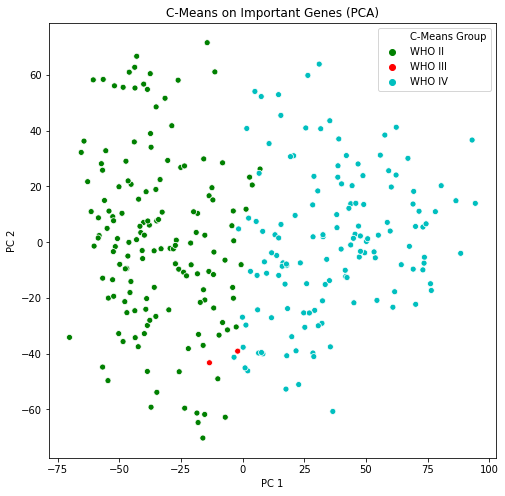

In [119]:
x = cmeans_train_top['PC 1']
y = cmeans_train_top['PC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = cmeans_train_top['C-Means Group'], palette = ['g', 'r', 'c'], 
               hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("C-Means on Important Genes (PCA)")
plt.show()

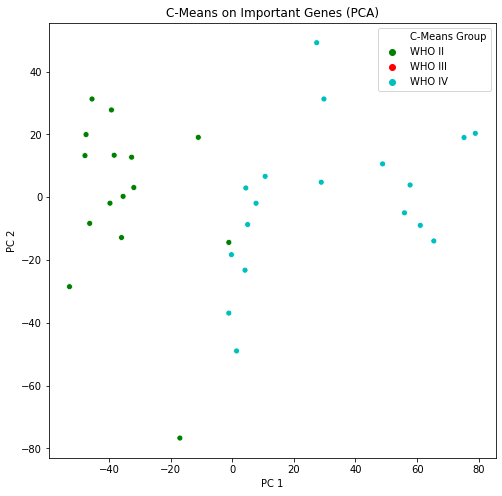

In [120]:
x = cmeans_test['PC 1']
y = cmeans_test['PC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = cmeans_test['C-Means Group'], palette = ['g', 'r', 'c'], 
               hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("C-Means on Important Genes (PCA)")
plt.show()

### Compare Clusters to Grades

#### Visually

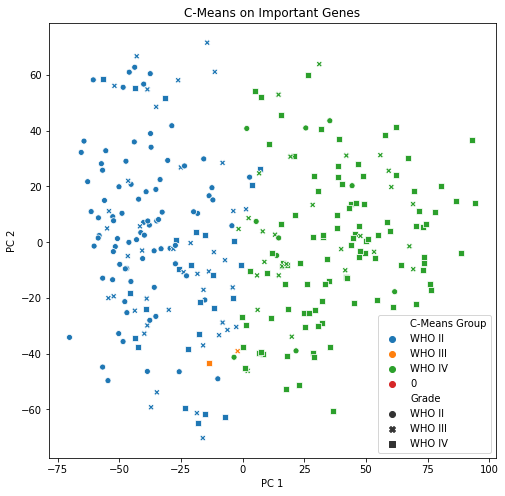

In [121]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV',0],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_train_top)
plt.title("C-Means on Important Genes")
plt.show()

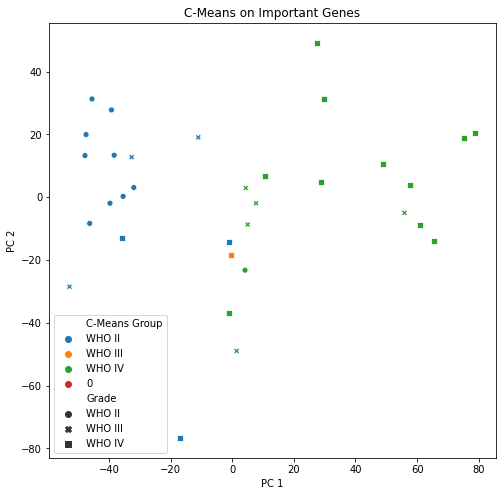

In [122]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV',0],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_test_top)
plt.title("C-Means on Important Genes")
plt.show()

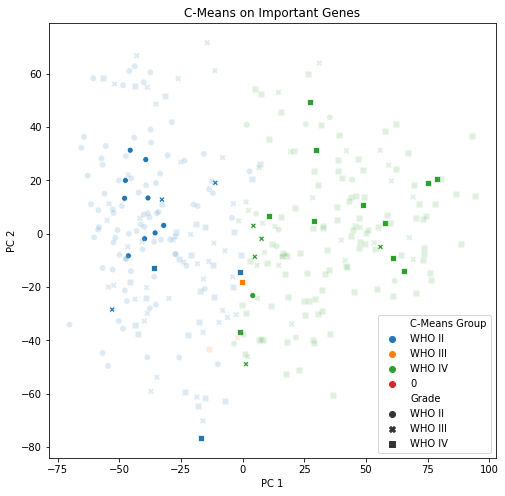

In [123]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV',0],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_test_top)
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV',0],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_train_top, alpha = .15, legend = False)
plt.title("C-Means on Important Genes")
plt.show()

#### Accuracy Score

In [124]:
get_accuracy(cmeans_train_top['Grade'], cmeans_train_top['C-Means Group'])

0.6335616438356164

In [125]:
get_accuracy(cmeans_test_top['Grade'], cmeans_test_top['C-Means Group'])

0.6060606060606061

## On 100 Factors

### Implement

In [0]:
centers_fa, c_train_fa, init, distance, idk, iterations, fpc_train = cmeans(fa_train_genes.T, 
                                                                c = 3, m = 2, error=0.005, 
                                                                maxiter=1000, seed = 40)
c_test_fa, init, distance, idk, iterations, fpc_test = cmeans_predict(fa_test_genes.T,
                                                                   centers_fa, m = 2, error = 0.005,
                                                                   maxiter = 1000, seed = 30)

In [127]:
clusters_train_fa = pd.DataFrame(np.argmax(c_train_fa, axis = 0))

cmeans_train_fa = pd.concat([pd.DataFrame(fa_train_genes), pd.DataFrame(clusters_train_fa), pd.DataFrame(train_lbl)], axis = 1)

col_titles = [f'Factor {x}' for x in range(1, 103)]
col_titles[-2:] = ['C-Means Group', 'Grade']
cmeans_train_fa.columns = col_titles

cmeans_train_fa = cmeans_train_fa.replace({'C-Means Group': {2:'WHO III', 0:'WHO IV', 1:'WHO II'}})

cmeans_train_fa.head()

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9,Factor 10,Factor 11,Factor 12,Factor 13,Factor 14,Factor 15,Factor 16,Factor 17,Factor 18,Factor 19,Factor 20,Factor 21,Factor 22,Factor 23,Factor 24,Factor 25,Factor 26,Factor 27,Factor 28,Factor 29,Factor 30,Factor 31,Factor 32,Factor 33,Factor 34,Factor 35,Factor 36,Factor 37,Factor 38,Factor 39,Factor 40,...,Factor 63,Factor 64,Factor 65,Factor 66,Factor 67,Factor 68,Factor 69,Factor 70,Factor 71,Factor 72,Factor 73,Factor 74,Factor 75,Factor 76,Factor 77,Factor 78,Factor 79,Factor 80,Factor 81,Factor 82,Factor 83,Factor 84,Factor 85,Factor 86,Factor 87,Factor 88,Factor 89,Factor 90,Factor 91,Factor 92,Factor 93,Factor 94,Factor 95,Factor 96,Factor 97,Factor 98,Factor 99,Factor 100,C-Means Group,Grade
0,-0.767871,-0.385531,0.115836,2.388345,-0.383484,-0.467369,0.561467,-2.350664,0.418821,3.973832,1.393458,0.537795,-1.186955,0.241165,-2.461988,-0.384562,-0.998326,0.576849,1.282513,0.930144,-1.114290,-0.555400,0.582111,-1.286940,-0.756003,-0.851512,0.500168,-0.302530,-1.151444,1.133120,0.066960,-0.897220,0.713943,0.469944,0.523972,0.829169,-0.259754,0.334612,0.638612,0.837120,...,0.667772,-0.687835,-1.093906,0.663421,1.777082,0.403360,1.039033,0.014080,0.939824,-0.798166,-0.012489,-1.292066,-1.089388,0.435321,1.080004,-0.580681,0.193973,-0.696573,0.209947,1.181998,1.581319,0.001383,-0.257150,0.536074,0.311319,0.998915,-0.095354,2.095175,0.483481,0.344128,1.088099,-1.533397,0.904053,-0.544323,-2.056798,1.683718,-0.716638,-0.717733,WHO II,WHO II
1,0.539117,0.327107,0.852022,-0.332517,-0.004732,0.745542,0.420696,0.905649,-0.866477,1.996034,0.113299,-0.303487,-0.368289,-0.738100,-0.355224,-0.306828,1.579579,-0.624290,-0.943939,-0.140500,-0.371726,1.095854,-0.376742,-0.131920,1.156971,0.019174,0.526034,1.989616,1.022750,0.108739,-0.671821,-0.700076,0.210346,0.400768,-0.186391,-1.013761,1.210125,0.822048,-0.608654,0.412536,...,-1.716859,0.398347,0.363219,0.184676,-0.871169,2.087683,-2.375473,4.507718,0.359282,0.120722,-1.184790,-1.131110,0.596269,-1.417280,3.027256,-1.059554,-1.926482,-1.727431,0.575586,-1.020027,-0.035904,-0.445189,0.958550,1.122069,-1.147704,1.916830,0.175825,-1.755637,-0.108784,0.047249,-2.818945,2.346825,-2.154707,-0.128855,-1.230194,0.923162,-1.032598,0.883319,WHO II,WHO IV
2,-0.914146,-0.218124,-0.782675,1.019773,0.375657,0.519532,0.913710,-1.079186,-0.907992,1.785236,0.315228,0.503691,-0.523415,0.600933,-0.377421,1.659806,0.111216,-0.507630,0.373521,1.309040,2.158432,-0.649656,2.112633,-0.537144,-0.300375,0.304272,-1.232271,-0.303918,-0.466015,-0.998909,0.478124,0.124541,-0.578029,-0.843605,0.154575,0.143870,-0.867417,-0.063425,0.102344,-0.828719,...,-0.342601,-1.091383,0.584348,0.084750,-0.297700,0.573446,-0.372649,0.069827,-0.060793,0.694590,1.544628,1.004739,1.563913,-0.019049,0.554957,0.060621,-0.619902,0.381322,0.727567,-0.004370,-0.079075,1.533853,-0.318394,0.100634,-0.178083,-0.220553,0.727758,-1.449127,0.138948,0.788301,0.348312,0.520673,1.320611,-0.702829,-0.331891,-0.452675,-0.783852,-0.367775,WHO IV,WHO II
3,-0.010240,-0.408593,-1.194213,-0.386557,0.003723,-1.695766,-0.276458,0.752302,1.858447,-0.038924,-0.494421,-0.505349,-1.804313,-0.779621,-1.425660,0.286663,0.260123,1.654794,-0.879751,-0.318515,0.663504,-0.573909,-0.654317,0.076841,-1.708391,-1.136160,-0.360114,0.521692,0.938267,-0.223938,-0.616241,-0.095428,-0.039779,1.251148,-0.454566,0.253899,-1.674527,0.542885,-0.161628,-0.132685,...,0.414760,-1.054944,-0.810270,0.392132,0.229581,-0.028218,1.044777,0.852055,-0.145478,0.086758,-0.776033,0.473123,0.725105,0.000560,0.576832,-0.573361,-0.678358,1.069336,-0.443874,1.552338,-0.308504,-0.923042,-1.355427,0.088791,0.648256,-0.374091,-0.184248,-0.618326,-0.348110,1.108395,-0.278188,-0.167396,-0.417089,-0.212686,0.996606,0.270324,0.030926,0.107322,WHO III,WHO II
4,-0.785148,-0.501948,-1.059175,-0.116568,-0.353897,1.322514,1.409249,-0.578670,0.985555,-0.809191,0.794120,0.010905,0.750028,0.052386,0.721943,0.340907,-1.09

In [128]:
clusters_test_fa = pd.DataFrame(np.argmax(c_test_fa, axis = 0))

cmeans_test_fa = pd.concat([pd.DataFrame(fa_test_genes), pd.DataFrame(clusters_test_fa), 
                             pd.DataFrame(test_lbl)], axis = 1)

col_titles = [f'Factor {x}' for x in range(1, 103)]
col_titles[-2:] = ['C-Means Group', 'Grade']
cmeans_test_fa.columns = col_titles

cmeans_test_fa = cmeans_test_fa.replace({'C-Means Group': {2:'WHO III', 0:'WHO IV', 1:'WHO II'}})

cmeans_test_fa.head()

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9,Factor 10,Factor 11,Factor 12,Factor 13,Factor 14,Factor 15,Factor 16,Factor 17,Factor 18,Factor 19,Factor 20,Factor 21,Factor 22,Factor 23,Factor 24,Factor 25,Factor 26,Factor 27,Factor 28,Factor 29,Factor 30,Factor 31,Factor 32,Factor 33,Factor 34,Factor 35,Factor 36,Factor 37,Factor 38,Factor 39,Factor 40,...,Factor 63,Factor 64,Factor 65,Factor 66,Factor 67,Factor 68,Factor 69,Factor 70,Factor 71,Factor 72,Factor 73,Factor 74,Factor 75,Factor 76,Factor 77,Factor 78,Factor 79,Factor 80,Factor 81,Factor 82,Factor 83,Factor 84,Factor 85,Factor 86,Factor 87,Factor 88,Factor 89,Factor 90,Factor 91,Factor 92,Factor 93,Factor 94,Factor 95,Factor 96,Factor 97,Factor 98,Factor 99,Factor 100,C-Means Group,Grade
0,-0.293440,2.538886,-0.681511,0.568800,-0.486379,-0.779511,0.319821,1.345924,-0.322250,-1.543843,0.583401,1.232805,1.015854,0.371118,0.726277,-1.793935,0.595507,1.381473,0.146248,-0.627867,1.816056,-1.514732,1.279376,-0.541915,-0.503033,0.677510,-2.602009,0.990409,-1.203804,-1.624827,1.442395,0.003285,-0.806711,-2.130532,-0.922185,1.211113,0.675092,0.930663,-0.030370,0.327993,...,0.181058,1.941298,-2.222015,-0.918663,-1.127551,0.955807,-0.755799,0.019922,3.750914,-0.136771,2.480472,1.341996,1.514001,-1.479348,-2.774186,2.167005,1.845020,-0.688455,-1.843069,-0.394638,2.116943,-0.407150,0.818184,-0.816016,0.064942,0.986092,0.205071,1.520231,-0.337685,-1.020581,-0.319427,-2.768241,0.609570,0.387526,-0.541136,0.203349,0.843216,-0.207020,WHO III,WHO IV
1,0.324620,0.320905,-0.001379,3.038895,1.789471,0.165920,-2.021166,-1.015364,0.394811,-2.838859,-0.892280,-2.068333,0.330254,0.075194,-0.361176,0.709951,1.915603,-1.290557,-0.529883,1.427255,-0.678221,0.282330,0.281810,0.989438,0.133487,-0.813798,0.024551,1.098699,1.331911,-0.247413,1.089651,1.520390,2.552489,0.659972,0.443962,-1.244502,-0.129881,-0.534517,-0.642364,-0.998721,...,-1.190419,0.839269,-0.432565,-0.610082,0.100808,-0.780341,-1.514881,0.213097,0.493203,-1.221235,0.915697,0.513288,0.614149,-0.283112,0.548249,-0.632030,1.084227,0.111545,1.039633,-0.012621,0.441137,0.886790,-0.718504,-1.305706,0.202242,-0.760016,1.094748,-0.414678,0.618624,-0.250067,-0.622165,-0.176920,1.646883,-1.226587,0.509953,0.791242,-0.390949,-0.668325,WHO IV,WHO IV
2,-1.149085,-0.725466,-0.161190,0.100292,-0.135751,0.447639,1.397324,0.732199,0.198626,-0.174552,0.252575,0.098434,-0.201954,1.109297,-0.362313,0.611463,0.252529,-0.328643,0.187580,-0.351575,1.453071,-0.282818,0.086284,-0.131108,-0.075098,0.546457,-0.347318,0.404466,0.175415,-0.935541,0.697452,0.543868,-1.326968,-0.798311,0.110845,-1.492511,-0.294801,0.442117,-0.170704,-1.192030,...,-0.183156,-0.440594,0.938233,-0.046092,-0.661072,0.329273,-0.586578,0.515794,-0.039014,0.324517,0.114069,-0.110840,0.209480,-0.006129,-0.641516,0.481802,0.213864,0.377849,0.004588,-0.405983,-0.021938,1.210337,0.795871,-0.848095,0.590221,0.391976,-0.268752,-0.157662,-0.176234,0.056113,-0.188803,-0.267155,0.447616,-0.704491,0.614786,0.263612,0.665294,-0.383083,WHO III,WHO II
3,-1.171114,0.380817,-0.509393,-0.778159,0.568190,0.228791,0.408663,-1.304155,0.910656,-0.400083,0.108526,-0.780755,-0.610037,-0.624102,-1.455385,0.215294,-1.350310,-0.298107,-0.909006,0.128485,-0.005939,-1.041672,0.504513,0.006271,0.233487,0.173494,-0.586015,0.290266,-0.825464,0.271224,0.395707,-0.256013,0.119838,-0.852398,0.395025,-0.068228,-0.552795,-0.170839,0.146349,-0.367205,...,0.171287,-0.204903,0.103397,-0.068474,0.006126,-0.111813,0.439918,0.409053,0.541837,-0.766683,-0.208610,0.150967,0.201722,0.477650,0.570681,-0.450848,-0.179122,-0.210300,-0.046033,-0.044556,-0.177725,-0.080124,-0.229516,0.140195,0.034021,0.122877,0.360044,0.347633,0.132775,0.123528,0.107490,0.339592,-0.311282,0.034030,-0.348044,0.098321,-0.154382,-0.752504,WHO II,WHO II
4,-0.999554,0.257892,-0.399793,-0.399037,0.653508,-0.356721,0.683092,-0.835377,2.041559,-0.493432,0.701805,-0.706554,-1.159834,-0.390775,-0.939134,0.467496,-0.0028

### Plot Clusters

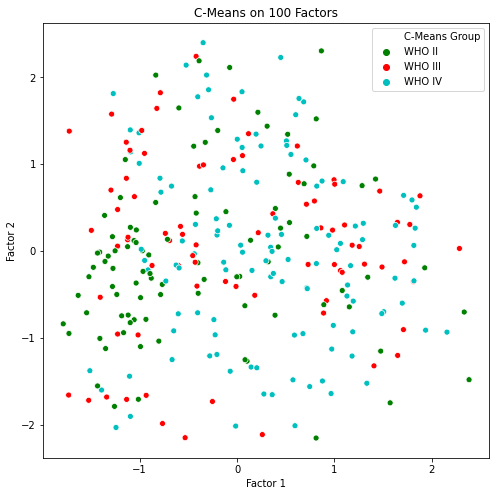

In [129]:
x = cmeans_train_fa['Factor 1']
y = cmeans_train_fa['Factor 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = cmeans_train_fa['C-Means Group'], palette = ['g', 'r', 'c'], 
               hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("C-Means on 100 Factors")
plt.show()

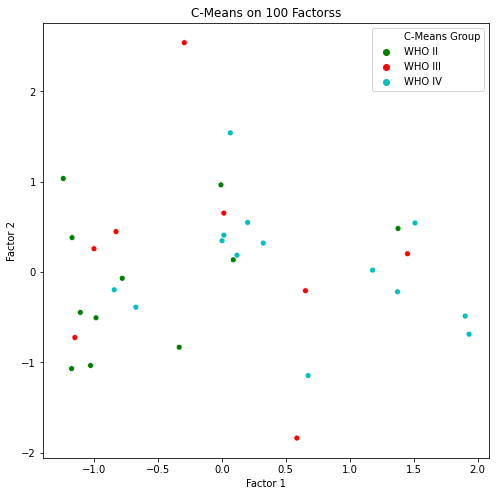

In [130]:
x = cmeans_test_fa['Factor 1']
y = cmeans_test_fa['Factor 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = cmeans_test_fa['C-Means Group'], palette = ['g', 'r', 'c'], 
               hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("C-Means on 100 Factorss")
plt.show()

### Compare Clusters to Grades

#### Visually

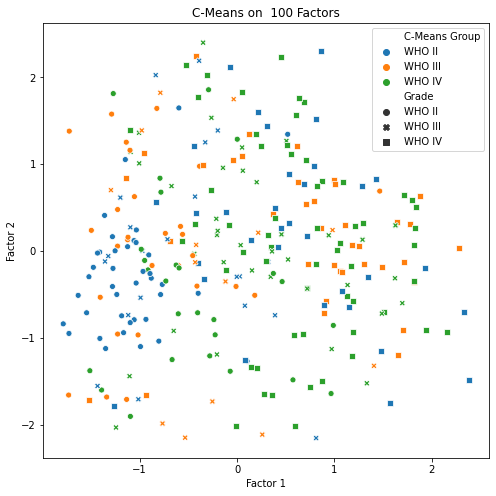

In [131]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'Factor 1', y = 'Factor 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_train_fa)
plt.title("C-Means on  100 Factors")
plt.show()

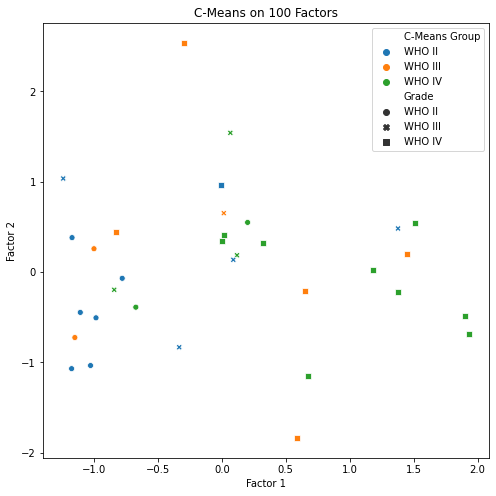

In [132]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'Factor 1', y = 'Factor 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_test_fa)
plt.title("C-Means on 100 Factors")
plt.show()

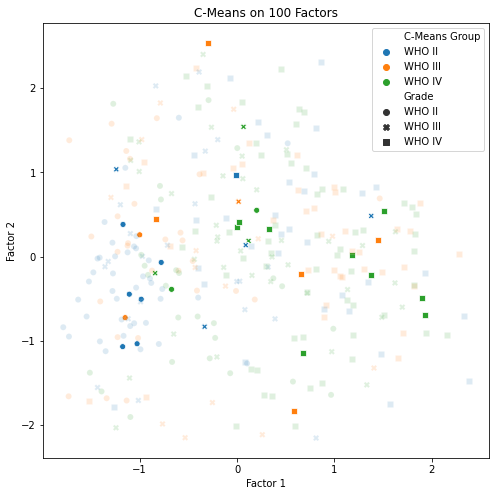

In [133]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'Factor 1', y = 'Factor 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_test_fa)
sb.scatterplot(x = 'Factor 1', y = 'Factor 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_train_fa, alpha = .15, legend = False)
plt.title("C-Means on 100 Factors")
plt.show()

#### Accuracy Score

In [134]:
get_accuracy(cmeans_train_fa['Grade'], cmeans_train_fa['C-Means Group'])

0.3801369863013699

In [135]:
get_accuracy(cmeans_test_fa['Grade'], cmeans_test_fa['C-Means Group'])

0.48484848484848486

## On important genes identified by FA

### Implement

In [0]:
centers_top_fa, c_train_top_fa, init, distance, idk, iterations, fpc_train = cmeans(fa_important_train.T, 
                                                                c = 3, m = 2, error=0.005, 
                                                                maxiter=1000, seed = 40)
c_test_top_fa, init, distance, idk, iterations, fpc_test = cmeans_predict(fa_important_test.T,
                                                                   centers_top_fa, m = 2, error = 0.005,
                                                                   maxiter = 1000, seed = 30)

In [137]:
clusters_train_top_fa = pd.DataFrame(np.argmax(c_train_top_fa, axis = 0))

cmeans_train_top_fa = pd.concat([pd.DataFrame(fa_train_genes), pd.DataFrame(clusters_train_top_fa), pd.DataFrame(train_lbl)], axis = 1)

col_titles = [f'Factor {x}' for x in range(1, 103)]
col_titles[-2:] = ['C-Means Group', 'Grade']
cmeans_train_top_fa.columns = col_titles

cmeans_train_top_fa = cmeans_train_top_fa.replace({'C-Means Group': {0:'WHO III', 2:'WHO IV', 1:'WHO II'}})

cmeans_train_top_fa.head()

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9,Factor 10,Factor 11,Factor 12,Factor 13,Factor 14,Factor 15,Factor 16,Factor 17,Factor 18,Factor 19,Factor 20,Factor 21,Factor 22,Factor 23,Factor 24,Factor 25,Factor 26,Factor 27,Factor 28,Factor 29,Factor 30,Factor 31,Factor 32,Factor 33,Factor 34,Factor 35,Factor 36,Factor 37,Factor 38,Factor 39,Factor 40,...,Factor 63,Factor 64,Factor 65,Factor 66,Factor 67,Factor 68,Factor 69,Factor 70,Factor 71,Factor 72,Factor 73,Factor 74,Factor 75,Factor 76,Factor 77,Factor 78,Factor 79,Factor 80,Factor 81,Factor 82,Factor 83,Factor 84,Factor 85,Factor 86,Factor 87,Factor 88,Factor 89,Factor 90,Factor 91,Factor 92,Factor 93,Factor 94,Factor 95,Factor 96,Factor 97,Factor 98,Factor 99,Factor 100,C-Means Group,Grade
0,-0.767871,-0.385531,0.115836,2.388345,-0.383484,-0.467369,0.561467,-2.350664,0.418821,3.973832,1.393458,0.537795,-1.186955,0.241165,-2.461988,-0.384562,-0.998326,0.576849,1.282513,0.930144,-1.114290,-0.555400,0.582111,-1.286940,-0.756003,-0.851512,0.500168,-0.302530,-1.151444,1.133120,0.066960,-0.897220,0.713943,0.469944,0.523972,0.829169,-0.259754,0.334612,0.638612,0.837120,...,0.667772,-0.687835,-1.093906,0.663421,1.777082,0.403360,1.039033,0.014080,0.939824,-0.798166,-0.012489,-1.292066,-1.089388,0.435321,1.080004,-0.580681,0.193973,-0.696573,0.209947,1.181998,1.581319,0.001383,-0.257150,0.536074,0.311319,0.998915,-0.095354,2.095175,0.483481,0.344128,1.088099,-1.533397,0.904053,-0.544323,-2.056798,1.683718,-0.716638,-0.717733,WHO II,WHO II
1,0.539117,0.327107,0.852022,-0.332517,-0.004732,0.745542,0.420696,0.905649,-0.866477,1.996034,0.113299,-0.303487,-0.368289,-0.738100,-0.355224,-0.306828,1.579579,-0.624290,-0.943939,-0.140500,-0.371726,1.095854,-0.376742,-0.131920,1.156971,0.019174,0.526034,1.989616,1.022750,0.108739,-0.671821,-0.700076,0.210346,0.400768,-0.186391,-1.013761,1.210125,0.822048,-0.608654,0.412536,...,-1.716859,0.398347,0.363219,0.184676,-0.871169,2.087683,-2.375473,4.507718,0.359282,0.120722,-1.184790,-1.131110,0.596269,-1.417280,3.027256,-1.059554,-1.926482,-1.727431,0.575586,-1.020027,-0.035904,-0.445189,0.958550,1.122069,-1.147704,1.916830,0.175825,-1.755637,-0.108784,0.047249,-2.818945,2.346825,-2.154707,-0.128855,-1.230194,0.923162,-1.032598,0.883319,WHO IV,WHO IV
2,-0.914146,-0.218124,-0.782675,1.019773,0.375657,0.519532,0.913710,-1.079186,-0.907992,1.785236,0.315228,0.503691,-0.523415,0.600933,-0.377421,1.659806,0.111216,-0.507630,0.373521,1.309040,2.158432,-0.649656,2.112633,-0.537144,-0.300375,0.304272,-1.232271,-0.303918,-0.466015,-0.998909,0.478124,0.124541,-0.578029,-0.843605,0.154575,0.143870,-0.867417,-0.063425,0.102344,-0.828719,...,-0.342601,-1.091383,0.584348,0.084750,-0.297700,0.573446,-0.372649,0.069827,-0.060793,0.694590,1.544628,1.004739,1.563913,-0.019049,0.554957,0.060621,-0.619902,0.381322,0.727567,-0.004370,-0.079075,1.533853,-0.318394,0.100634,-0.178083,-0.220553,0.727758,-1.449127,0.138948,0.788301,0.348312,0.520673,1.320611,-0.702829,-0.331891,-0.452675,-0.783852,-0.367775,WHO II,WHO II
3,-0.010240,-0.408593,-1.194213,-0.386557,0.003723,-1.695766,-0.276458,0.752302,1.858447,-0.038924,-0.494421,-0.505349,-1.804313,-0.779621,-1.425660,0.286663,0.260123,1.654794,-0.879751,-0.318515,0.663504,-0.573909,-0.654317,0.076841,-1.708391,-1.136160,-0.360114,0.521692,0.938267,-0.223938,-0.616241,-0.095428,-0.039779,1.251148,-0.454566,0.253899,-1.674527,0.542885,-0.161628,-0.132685,...,0.414760,-1.054944,-0.810270,0.392132,0.229581,-0.028218,1.044777,0.852055,-0.145478,0.086758,-0.776033,0.473123,0.725105,0.000560,0.576832,-0.573361,-0.678358,1.069336,-0.443874,1.552338,-0.308504,-0.923042,-1.355427,0.088791,0.648256,-0.374091,-0.184248,-0.618326,-0.348110,1.108395,-0.278188,-0.167396,-0.417089,-0.212686,0.996606,0.270324,0.030926,0.107322,WHO II,WHO II
4,-0.785148,-0.501948,-1.059175,-0.116568,-0.353897,1.322514,1.409249,-0.578670,0.985555,-0.809191,0.794120,0.010905,0.750028,0.052386,0.721943,0.340907,-1.095

In [138]:
clusters_test_top_fa = pd.DataFrame(np.argmax(c_test_top_fa, axis = 0))

cmeans_test_top_fa = pd.concat([pd.DataFrame(fa_test_genes), pd.DataFrame(clusters_test_top_fa), pd.DataFrame(test_lbl)], axis = 1)

col_titles = [f'Factor {x}' for x in range(1, 103)]
col_titles[-2:] = ['C-Means Group', 'Grade']
cmeans_test_top_fa.columns = col_titles

cmeans_test_top_fa = cmeans_test_top_fa.replace({'C-Means Group': {0:'WHO III', 2:'WHO IV', 1:'WHO II'}})

cmeans_test_top_fa.head()

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9,Factor 10,Factor 11,Factor 12,Factor 13,Factor 14,Factor 15,Factor 16,Factor 17,Factor 18,Factor 19,Factor 20,Factor 21,Factor 22,Factor 23,Factor 24,Factor 25,Factor 26,Factor 27,Factor 28,Factor 29,Factor 30,Factor 31,Factor 32,Factor 33,Factor 34,Factor 35,Factor 36,Factor 37,Factor 38,Factor 39,Factor 40,...,Factor 63,Factor 64,Factor 65,Factor 66,Factor 67,Factor 68,Factor 69,Factor 70,Factor 71,Factor 72,Factor 73,Factor 74,Factor 75,Factor 76,Factor 77,Factor 78,Factor 79,Factor 80,Factor 81,Factor 82,Factor 83,Factor 84,Factor 85,Factor 86,Factor 87,Factor 88,Factor 89,Factor 90,Factor 91,Factor 92,Factor 93,Factor 94,Factor 95,Factor 96,Factor 97,Factor 98,Factor 99,Factor 100,C-Means Group,Grade
0,-0.293440,2.538886,-0.681511,0.568800,-0.486379,-0.779511,0.319821,1.345924,-0.322250,-1.543843,0.583401,1.232805,1.015854,0.371118,0.726277,-1.793935,0.595507,1.381473,0.146248,-0.627867,1.816056,-1.514732,1.279376,-0.541915,-0.503033,0.677510,-2.602009,0.990409,-1.203804,-1.624827,1.442395,0.003285,-0.806711,-2.130532,-0.922185,1.211113,0.675092,0.930663,-0.030370,0.327993,...,0.181058,1.941298,-2.222015,-0.918663,-1.127551,0.955807,-0.755799,0.019922,3.750914,-0.136771,2.480472,1.341996,1.514001,-1.479348,-2.774186,2.167005,1.845020,-0.688455,-1.843069,-0.394638,2.116943,-0.407150,0.818184,-0.816016,0.064942,0.986092,0.205071,1.520231,-0.337685,-1.020581,-0.319427,-2.768241,0.609570,0.387526,-0.541136,0.203349,0.843216,-0.207020,WHO IV,WHO IV
1,0.324620,0.320905,-0.001379,3.038895,1.789471,0.165920,-2.021166,-1.015364,0.394811,-2.838859,-0.892280,-2.068333,0.330254,0.075194,-0.361176,0.709951,1.915603,-1.290557,-0.529883,1.427255,-0.678221,0.282330,0.281810,0.989438,0.133487,-0.813798,0.024551,1.098699,1.331911,-0.247413,1.089651,1.520390,2.552489,0.659972,0.443962,-1.244502,-0.129881,-0.534517,-0.642364,-0.998721,...,-1.190419,0.839269,-0.432565,-0.610082,0.100808,-0.780341,-1.514881,0.213097,0.493203,-1.221235,0.915697,0.513288,0.614149,-0.283112,0.548249,-0.632030,1.084227,0.111545,1.039633,-0.012621,0.441137,0.886790,-0.718504,-1.305706,0.202242,-0.760016,1.094748,-0.414678,0.618624,-0.250067,-0.622165,-0.176920,1.646883,-1.226587,0.509953,0.791242,-0.390949,-0.668325,WHO IV,WHO IV
2,-1.149085,-0.725466,-0.161190,0.100292,-0.135751,0.447639,1.397324,0.732199,0.198626,-0.174552,0.252575,0.098434,-0.201954,1.109297,-0.362313,0.611463,0.252529,-0.328643,0.187580,-0.351575,1.453071,-0.282818,0.086284,-0.131108,-0.075098,0.546457,-0.347318,0.404466,0.175415,-0.935541,0.697452,0.543868,-1.326968,-0.798311,0.110845,-1.492511,-0.294801,0.442117,-0.170704,-1.192030,...,-0.183156,-0.440594,0.938233,-0.046092,-0.661072,0.329273,-0.586578,0.515794,-0.039014,0.324517,0.114069,-0.110840,0.209480,-0.006129,-0.641516,0.481802,0.213864,0.377849,0.004588,-0.405983,-0.021938,1.210337,0.795871,-0.848095,0.590221,0.391976,-0.268752,-0.157662,-0.176234,0.056113,-0.188803,-0.267155,0.447616,-0.704491,0.614786,0.263612,0.665294,-0.383083,WHO II,WHO II
3,-1.171114,0.380817,-0.509393,-0.778159,0.568190,0.228791,0.408663,-1.304155,0.910656,-0.400083,0.108526,-0.780755,-0.610037,-0.624102,-1.455385,0.215294,-1.350310,-0.298107,-0.909006,0.128485,-0.005939,-1.041672,0.504513,0.006271,0.233487,0.173494,-0.586015,0.290266,-0.825464,0.271224,0.395707,-0.256013,0.119838,-0.852398,0.395025,-0.068228,-0.552795,-0.170839,0.146349,-0.367205,...,0.171287,-0.204903,0.103397,-0.068474,0.006126,-0.111813,0.439918,0.409053,0.541837,-0.766683,-0.208610,0.150967,0.201722,0.477650,0.570681,-0.450848,-0.179122,-0.210300,-0.046033,-0.044556,-0.177725,-0.080124,-0.229516,0.140195,0.034021,0.122877,0.360044,0.347633,0.132775,0.123528,0.107490,0.339592,-0.311282,0.034030,-0.348044,0.098321,-0.154382,-0.752504,WHO II,WHO II
4,-0.999554,0.257892,-0.399793,-0.399037,0.653508,-0.356721,0.683092,-0.835377,2.041559,-0.493432,0.701805,-0.706554,-1.159834,-0.390775,-0.939134,0.467496,-0.002841

### Plot Clusters

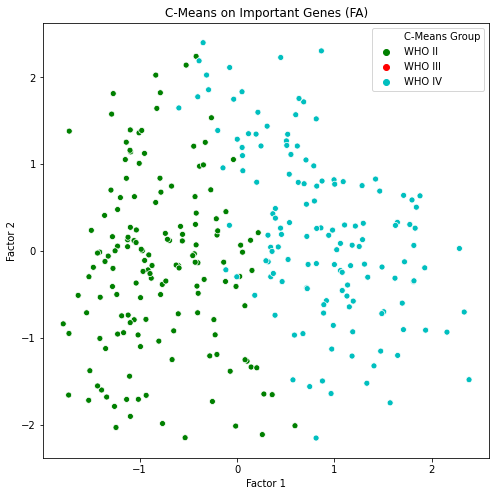

In [139]:
x = cmeans_train_top_fa['Factor 1']
y = cmeans_train_top_fa['Factor 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = cmeans_train_top_fa['C-Means Group'], palette = ['g', 'r', 'c'], 
               hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("C-Means on Important Genes (FA)")
plt.show()

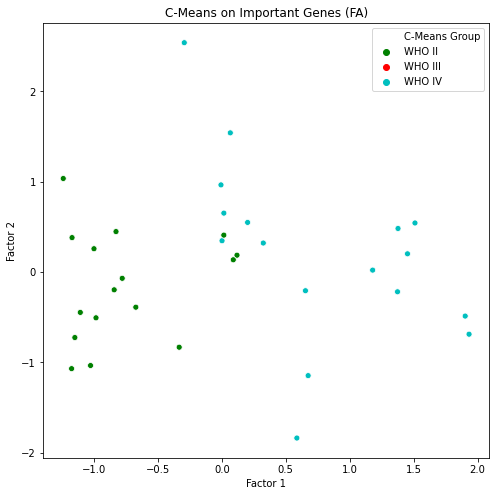

In [140]:
x = cmeans_test_top_fa['Factor 1']
y = cmeans_test_top_fa['Factor 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = cmeans_test_top_fa['C-Means Group'], palette = ['g', 'r', 'c'], 
               hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("C-Means on Important Genes (FA)")
plt.show()

### Compare Clusters to Grades

#### Accuracy Score

In [141]:
get_accuracy(cmeans_train_top_fa['Grade'], cmeans_train_top_fa['C-Means Group'])

0.6198630136986302

In [142]:
get_accuracy(cmeans_test_top_fa['Grade'], cmeans_test_top_fa['C-Means Group'])

0.6666666666666666

## On n Sparse PCs

### Implement

In [0]:
centers_sparse, c_train_sparse, init, distance, idk, iterations, fpc_train = cmeans(sparse_train_genes.T, 
                                                                c = 3, m = 2, error=0.005, 
                                                                maxiter=1000, seed = 40)
c_test_sparse, init, distance, idk, iterations, fpc_test = cmeans_predict(sparse_test_genes.T,
                                                                   centers_sparse, m = 2, error = 0.005,
                                                                   maxiter = 1000, seed = 30)

In [144]:
clusters_train_sparse = pd.DataFrame(np.argmax(c_train_sparse, axis = 0))

cmeans_train_sparse = pd.concat([pd.DataFrame(sparse_train_genes), pd.DataFrame(clusters_train_sparse), pd.DataFrame(train_lbl)], axis = 1)

col_titles = [f'PC {x}' for x in range(1, n+3)]
col_titles[-2:] = ['C-Means Group', 'Grade']
cmeans_train_sparse.columns = col_titles

cmeans_train_sparse = cmeans_train_sparse.replace({'C-Means Group': {0:'WHO III', 2:'WHO IV', 1:'WHO II'}})

cmeans_train_sparse.head()

,PC 1,PC 2,C-Means Group,Grade
0,-36.413191,4.815777,WHO II,WHO II
1,24.458767,0.265303,WHO IV,WHO IV
2,-39.690841,-5.777740,WHO II,WHO II
3,-6.991711,4.505546,WHO III,WHO II
4,-34.857176,2.318579,WHO II,WHO II


In [145]:
clusters_test_sparse = pd.DataFrame(np.argmax(c_test_sparse, axis = 0))

cmeans_test_sparse = pd.concat([pd.DataFrame(sparse_test_genes), pd.DataFrame(clusters_test_sparse), 
                             pd.DataFrame(test_lbl)], axis = 1)

col_titles = [f'PC {x}' for x in range(1, n+3)]
col_titles[-2:] = ['C-Means Group', 'Grade']
cmeans_test_sparse.columns = col_titles

cmeans_test_sparse = cmeans_test_sparse.replace({'C-Means Group': {0:'WHO III', 2:'WHO IV', 1:'WHO II'}})

cmeans_test_sparse.head()

,PC 1,PC 2,C-Means Group,Grade
0,12.643017,-77.676817,WHO III,WHO IV
1,10.648963,4.422605,WHO III,WHO IV
2,-51.132604,5.446989,WHO II,WHO II
3,-40.303974,-20.365345,WHO II,WHO II
4,-35.936849,-13.596389,WHO II,WHO II


### Plot Clusters

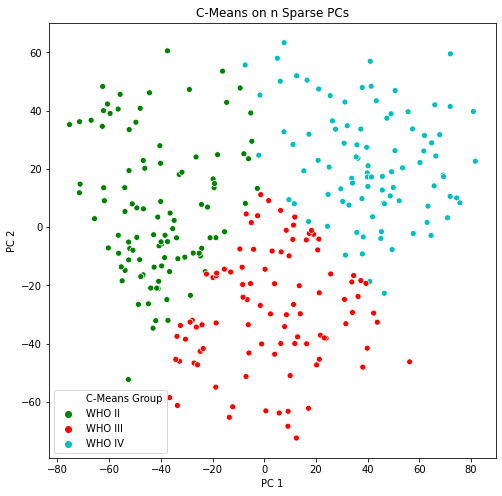

In [146]:
x = cmeans_train_sparse['PC 1']
y = cmeans_train_sparse['PC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = cmeans_train_sparse['C-Means Group'], palette = ['g', 'r', 'c'], 
               hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("C-Means on n Sparse PCs")
plt.show()

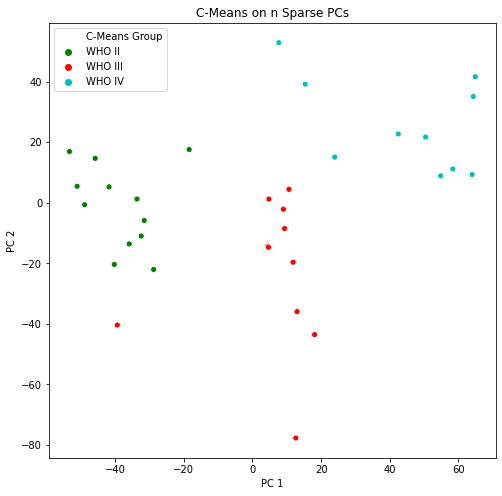

In [147]:
x = cmeans_test_sparse['PC 1']
y = cmeans_test_sparse['PC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = cmeans_test_sparse['C-Means Group'], palette = ['g', 'r', 'c'], 
               hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("C-Means on n Sparse PCs")
plt.show()

### Compare Clusters to Grades

#### Visually

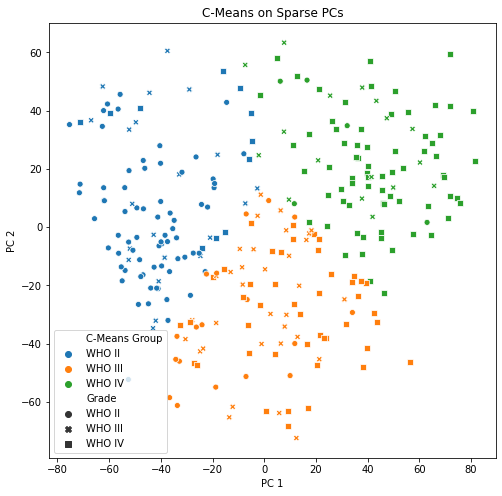

In [148]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_train_sparse)
plt.title("C-Means on Sparse PCs")
plt.show()

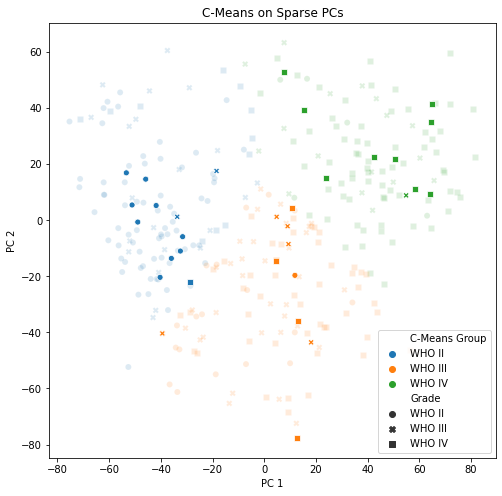

In [149]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_train_sparse, alpha = .15)
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_test_sparse, legend = False)
plt.title("C-Means on Sparse PCs")
plt.show()

#### Accuracy Score

In [150]:
get_accuracy(cmeans_train_sparse['Grade'], cmeans_train_sparse['C-Means Group'])

0.5958904109589042

In [151]:
get_accuracy(cmeans_test_sparse['Grade'], cmeans_test_sparse['C-Means Group'])

0.696969696969697

## On important genes identified by Sparse PCA

### Implement

In [0]:
centers_top_sparse, c_train_top_sparse, init, distance, idk, iterations, fpc_train = cmeans(sparse_important_train.T, 
                                                                c = 3, m = 2, error=0.005, 
                                                                maxiter=1000, seed = 40)
c_test_top_sparse, init, distance, idk, iterations, fpc_test = cmeans_predict(sparse_important_test.T,
                                                                   centers_top_sparse, m = 2, error = 0.005,
                                                                   maxiter = 1000, seed = 30)

In [198]:
clusters_train_top_sparse = pd.DataFrame(np.argmax(c_train_top_sparse, axis = 0))

cmeans_train_top_sparse = pd.concat([pd.DataFrame(sparse_train_genes), 
                                     pd.DataFrame(clusters_train_top_sparse), 
                                     pd.DataFrame(train_lbl)], axis = 1)

col_titles = [f'PC {x}' for x in range(1, n+3)]
col_titles[-2:] = ['C-Means Group', 'Grade']
cmeans_train_top_sparse.columns = col_titles

cmeans_train_top_sparse = cmeans_train_top_sparse.replace({'C-Means Group': {0:'WHO III', 2:'WHO IV', 1:'WHO II'}})

cmeans_train_top_sparse.head()

,PC 1,PC 2,C-Means Group,Grade
0,-36.413191,4.815777,WHO II,WHO II
1,24.458767,0.265303,WHO IV,WHO IV
2,-39.690841,-5.777740,WHO II,WHO II
3,-6.991711,4.505546,WHO III,WHO II
4,-34.857176,2.318579,WHO II,WHO II


In [209]:
clusters_test_top_sparse = pd.DataFrame(np.argmax(c_test_top_sparse, axis = 0))

cmeans_test_top_sparse = pd.concat([pd.DataFrame(sparse_test_genes), pd.DataFrame(clusters_test_top_sparse), 
                                    pd.DataFrame(test_lbl)], axis = 1)

col_titles = [f'PC {x}' for x in range(1, n+3)]
col_titles[-2:] = ['C-Means Group', 'Grade']
cmeans_test_top_sparse.columns = col_titles

cmeans_test_top_sparse = cmeans_test_top_sparse.replace({'C-Means Group': {0:'WHO III', 2:'WHO IV', 1:'WHO II'}})

cmeans_test_top_sparse.head()

,PC 1,PC 2,C-Means Group,Grade
0,12.643017,-77.676817,WHO III,WHO IV
1,10.648963,4.422605,WHO III,WHO IV
2,-51.132604,5.446989,WHO II,WHO II
3,-40.303974,-20.365345,WHO II,WHO II
4,-35.936849,-13.596389,WHO II,WHO II


### Plot Clusters

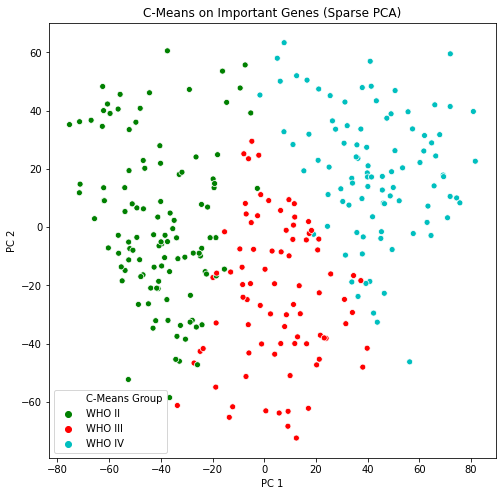

In [210]:
x = cmeans_train_top_sparse['PC 1']
y = cmeans_train_top_sparse['PC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = cmeans_train_top_sparse['C-Means Group'], palette = ['g', 'r', 'c'], 
               hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("C-Means on Important Genes (Sparse PCA)")
plt.show()

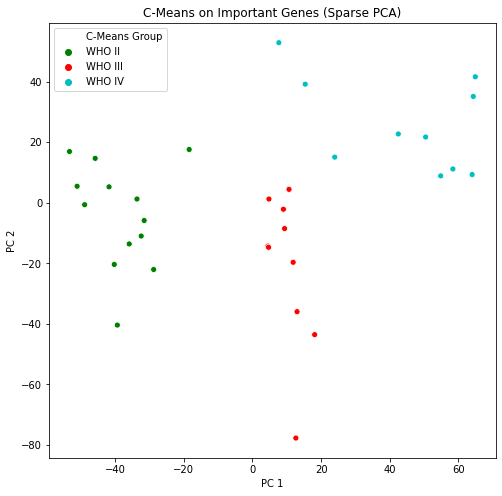

In [211]:
x = cmeans_test_top_sparse['PC 1']
y = cmeans_test_top_sparse['PC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = cmeans_test_top_sparse['C-Means Group'], palette = ['g', 'r', 'c'], 
               hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("C-Means on Important Genes (Sparse PCA)")
plt.show()

### Compare Clusters to Grades

#### Visually

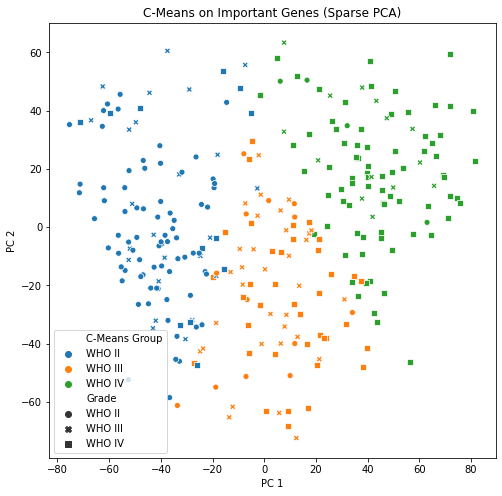

In [212]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_train_top_sparse)
plt.title("C-Means on Important Genes (Sparse PCA)")
plt.show()

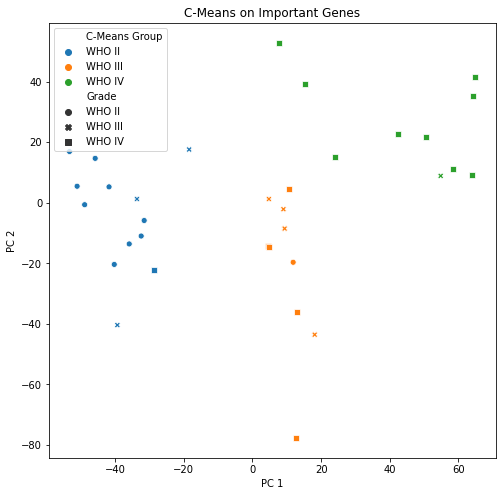

In [213]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_test_top_sparse)
plt.title("C-Means on Important Genes")
plt.show()

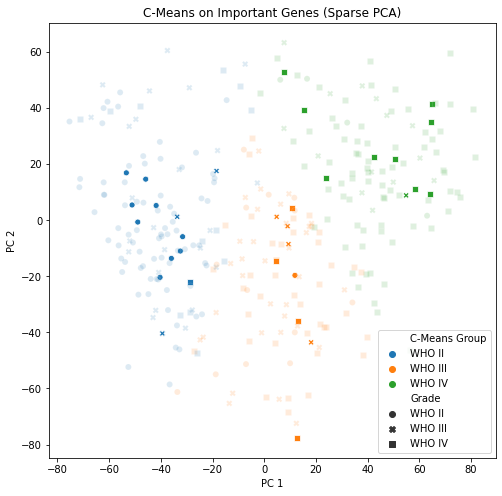

In [214]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_test_top_sparse)
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_train_top_sparse, alpha = .15, legend = False)
plt.title("C-Means on Important Genes (Sparse PCA)")
plt.show()

#### Accuracy Score

In [215]:
get_accuracy(cmeans_train_top_sparse['Grade'], cmeans_train_top_sparse['C-Means Group'])

0.636986301369863

In [216]:
get_accuracy(cmeans_test_top_sparse['Grade'], cmeans_test_top_sparse['C-Means Group'])

0.6666666666666666